In [ ]:
from notebooks import *
print_sys_info()

platform:
  machine: x86_64
  node: Dan-B.local
  processor: i386
  release: 15.6.0
  system: Darwin
  version: 'Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64'
cpu: 8
mem: 16g
swap: 19g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[20:41:57.683] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_us  # 400k/9.4k -> 60k/1.1k -> 53k/774
# countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 168,  20  # ca[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # Familiar set
# recs_at_least, num_species, num_recs =  20, 336,  20  # us[774/53k -> 528/51k -> 336/33k -> 336/ 6.7k -> 336/ 6.7k]  # Scale species
recs_at_least, num_species, num_recs =  10, 168,  20  # ca[334/35k ->                                             ]  # Class imbalance
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   50  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   20  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   10  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,    5  # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          774/52707 (sp/recs)
(downloaded)       774/52702 (sp/recs)
recs_at_least      616/52020 (sp/recs)
num_species        168/14529 (sp/recs)


num_recs            168/3243 (sp/recs)
recs ≥ 2            168/3243 (sp/recs)


'sp[168], recs[3243]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,90804,3243,3243,1,NaN,NaN,True,True,True,True,True
species,category,171879,3243,3243,168,NaN,NaN,FUWD,SBDO,PINF,WEWA,AMGO
id,int64,90804,3243,3243,3243,210152.808,109561.767,657,132521,192965,310832,417459
sci_name,category,218015,3243,3243,169,NaN,NaN,Dendrocygna bicolor,Limnodromus griseus,Empidonax affinis,Helmitheros vermivorum,Spinus tristis
com_name,category,213255,3243,3243,169,NaN,NaN,Fulvous Whistling Duck,Short-billed Dowitcher,Pine Flycatcher,Worm-eating Warbler,American Goldfinch
subspecies,object,174480,3243,3243,182,NaN,NaN,,,,,x cyanoptera
recordist,object,205038,3243,3243,279,NaN,NaN,ASJ26,Eric Hough,Mike Nelson,Peter Boesman,mtaylor
country,object,195536,3243,3243,3,NaN,NaN,Canada,Mexico,United States,United States,United States
locality,object,303626,3243,3243,1627,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca",Dawson Creek,"McFarland Park, Cocoa, Brevard County, Florida","Rocky Point Bird Observatory, Metchosin, Vancouver Island, BC","Álamos, Sonora"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
HOGR,223019,True,HOGR,188789,Podiceps auritus,Horned Grebe,,Andrew Spencer,United States,"Peat Ponds Wildlife Area, Fairbanks-North Star Borough, Alaska",64.9,-148.0,begging call,A,2014-07-08 00:00:00,09:20,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/188789,//www.xeno-canto.org/188789/download
WTDO,82376,True,WTDO,333856,Leptotila verreauxi,White-tipped Dove,bangsi,Richard E. Webster,Mexico,"Paval, Chiapas",15.6,-92.8,song,B,2015-03-29 00:00:00,07:56,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/333856,//www.xeno-canto.org/333856/download
NOPO,391357,True,NOPO,9668,Glaucidium gnoma,Mountain Pygmy Owl,,Allen T. Chartier,Mexico,"La Cumbre, Oaxaca",17.2,-96.6,Song,B,1995-02-27 00:00:00,?,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/9668,//www.xeno-canto.org/9668/download
BEWR,12804,True,BEWR,404736,Thryomanes bewickii,Bewick's Wren,,Jacob R. Saucier,United States,"Texas: Kinney County; 26.1 km NE Brackettville, Miguel Canyon",29.5,-100.0,"call, song",A,2015-05-07 00:00:00,07:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/404736,//www.xeno-canto.org/404736/download
NOMO,209761,True,NOMO,202398,Mimus polyglottos,Northern Mockingbird,polyglottos,Albert & Max Lastukhin,United States,"Glen Cove, Nassau, New York",40.9,-73.7,song,B,2014-06-28 00:00:00,11:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/202398,//www.xeno-canto.org/202398/download
WEWA,227479,True,WEWA,184219,Helmitheros vermivorum,Worm-eating Warbler,,Paul Driver,United States,"Glassboro, NJ",39.7,-75.1,song,B,2014-06-28 00:00:00,05:47,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/184219,//www.xeno-canto.org/184219/download
GRWA,207171,True,GRWA,205392,Setophaga graciae,Grace's Warbler,,Eric DeFonso,United States,"FR378/Q2 junction, Manti-La Sal National Forest, Montrose County, Colorado",38.4,-109.0,song,A,2014-05-19 00:00:00,15:22,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/205392,//www.xeno-canto.org/205392/download
BTYW,263014,True,BTYW,147286,Setophaga nigrescens,Black-throated Grey Warbler,,Paul Marvin,United States,"Little Firehole Road, Flaming Gorge NRA, Wyoming",41.5,-109.0,song,A,2013-05-17 00:00:00,08:39,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/147286,//www.xeno-canto.org/147286/download
HESP,355266,True,HESP,49210,Ammodramus henslowii,Henslow's Sparrow,,Andrew Spencer,United States,"Beech Run Road, Preston Co., West Virginia",39.6,-79.7,call,A,2010-05-07 00:00:00,08:30,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/49210,//www.xeno-canto.org/49210/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    f"{len(xcs_paths)}/{len(xcs)}",
    # xcs_paths[:2],
)

'3243/3243'

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

[20:52:55.050] DEBUG  Load.metadata:in
  len(recs): 3243
  len(recs) per dataset: {xc: 3243}
[20:52:55.207] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/147332/audio.wav


[                                                                                          ] | 0% Completed |  0.0s

[20:52:55.519] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/239617/audio.wav
[20:52:55.521] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/116368/audio.wav
[20:52:55.523] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/81277/audio.wav
[20:52:55.527] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/135836/audio.wav
[                                                                                          ] | 0% Completed |  0.1s

[20:52:55.644] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121671/audio.wav

[20:52:55.661] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/104580/audio.wav


[                                                                                          ] | 0% Completed |  0.2s

[20:52:55.772] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/MOUQ/226933/audio.wav


[20:52:55.791] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/MOUQ/27580/audio.wav
[#                                                                                         ] | 1% Completed |  0.3s

[#                                                                                         ] | 1% Completed |  0.4s

[#                                                                                         ] | 1% Completed |  0.5s

[#                                                                                         ] | 1% Completed |  0.6s

[#                                                                                         ] | 1% Completed |  0.8s

[#                                                                                         ] | 1% Completed |  0.9s

[20:52:56.416] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/222339/audio.wav


[#                                                                                         ] | 1% Completed |  1.0s

[#                                                                                         ] | 1% Completed |  1.1s

[#                                                                                         ] | 1% Completed |  1.2s

[#                                                                                         ] | 1% Completed |  1.3s

[#                                                                                         ] | 1% Completed |  1.4s

[20:52:56.952] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/135762/audio.wav


[#                                                                                         ] | 1% Completed |  1.5s

[20:52:57.076] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/357737/audio.wav
[##                                                                                        ] | 2% Completed |  1.6s

[##                                                                                        ] | 2% Completed |  1.7s

[20:52:57.244] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/181782/audio.wav


[##                                                                                        ] | 2% Completed |  1.8s

[##                                                                                        ] | 2% Completed |  1.9s

[##                                                                                        ] | 2% Completed |  2.0s

[##                                                                                        ] | 2% Completed |  2.1s

[##                                                                                        ] | 2% Completed |  2.2s

[##                                                                                        ] | 2% Completed |  2.3s

[20:52:57.864] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/161349/audio.wav


[##                                                                                        ] | 2% Completed |  2.4s

[##                                                                                        ] | 2% Completed |  2.5s

[##                                                                                        ] | 2% Completed |  2.6s

[##                                                                                        ] | 2% Completed |  2.7s

[20:52:58.310] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/325493/audio.wav


[##                                                                                        ] | 2% Completed |  2.8s

[20:52:58.361] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/267759/audio.wav


[##                                                                                        ] | 2% Completed |  2.9s

[##                                                                                        ] | 2% Completed |  3.0s

[##                                                                                        ] | 2% Completed |  3.1s

[20:52:58.696] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/222338/audio.wav


[##                                                                                        ] | 2% Completed |  3.2s

[##                                                                                        ] | 2% Completed |  3.4s

[##                                                                                        ] | 2% Completed |  3.5s

[20:52:59.029] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/287369/audio.wav
[20:52:59.038] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/MOUQ/146189/audio.wav


[##                                                                                        ] | 3% Completed |  3.6s

[20:52:59.153] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/77510/audio.wav


[##                                                                                        ] | 3% Completed |  3.7s

[##                                                                                        ] | 3% Completed |  3.8s

[##                                                                                        ] | 3% Completed |  3.9s

[##                                                                                        ] | 3% Completed |  4.0s

[20:52:59.521] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/97310/audio.wav


[##                                                                                        ] | 3% Completed |  4.1s

[20:52:59.662] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/83152/audio.wav


[##                                                                                        ] | 3% Completed |  4.2s

[##                                                                                        ] | 3% Completed |  4.3s

[20:52:59.896] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/163167/audio.wav


[###                                                                                       ] | 3% Completed |  4.4s

[###                                                                                       ] | 4% Completed |  4.5s

[####                                                                                      ] | 5% Completed |  4.6s

[#####                                                                                     ] | 6% Completed |  4.7s

[#####                                                                                     ] | 6% Completed |  4.8s

[######                                                                                    ] | 7% Completed |  5.0s

[20:53:00.479] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/143568/audio.wav


[######                                                                                    ] | 7% Completed |  5.1s

[20:53:00.563] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/173885/audio.wav


[######                                                                                    ] | 7% Completed |  5.2s

[######                                                                                    ] | 7% Completed |  5.3s

[20:53:00.811] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/179662/audio.wav


[######                                                                                    ] | 7% Completed |  5.4s

[20:53:00.891] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/163168/audio.wav
[20:53:00.895] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/30794/audio.wav


[######                                                                                    ] | 7% Completed |  5.5s

[20:53:01.019] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/147330/audio.wav


[######                                                                                    ] | 7% Completed |  5.6s

[######                                                                                    ] | 7% Completed |  5.7s

[20:53:01.211] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/87165/audio.wav


[######                                                                                    ] | 7% Completed |  5.8s

[######                                                                                    ] | 7% Completed |  5.9s

[20:53:01.436] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/316535/audio.wav


[######                                                                                    ] | 7% Completed |  6.0s

[######                                                                                    ] | 7% Completed |  6.1s

[######                                                                                    ] | 7% Completed |  6.2s

[######                                                                                    ] | 7% Completed |  6.3s

[######                                                                                    ] | 7% Completed |  6.4s

[######                                                                                    ] | 7% Completed |  6.5s

[######                                                                                    ] | 7% Completed |  6.6s

[######                                                                                    ] | 7% Completed |  6.7s

[######                                                                                    ] | 7% Completed |  6.8s

[20:53:02.425] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/311616/audio.wav


[######                                                                                    ] | 7% Completed |  7.0s

[######                                                                                    ] | 7% Completed |  7.1s

[20:53:02.612] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/205559/audio.wav


[######                                                                                    ] | 7% Completed |  7.2s

[######                                                                                    ] | 7% Completed |  7.3s

[20:53:02.831] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/MOUQ/239475/audio.wav
[20:53:02.869] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/147331/audio.wav


[######                                                                                    ] | 7% Completed |  7.4s

[20:53:03.010] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/408105/audio.wav


[######                                                                                    ] | 7% Completed |  7.5s

[######                                                                                    ] | 7% Completed |  7.7s

[20:53:03.171] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FUWD/147329/audio.wav


[######                                                                                    ] | 7% Completed |  7.8s

[######                                                                                    ] | 7% Completed |  7.9s

[######                                                                                    ] | 7% Completed |  8.0s

[######                                                                                    ] | 7% Completed |  8.1s

[######                                                                                    ] | 7% Completed |  8.2s

[20:53:03.654] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/339907/audio.wav


[######                                                                                    ] | 7% Completed |  8.3s

[######                                                                                    ] | 7% Completed |  8.4s

[######                                                                                    ] | 7% Completed |  8.5s

[######                                                                                    ] | 7% Completed |  8.6s

[######                                                                                    ] | 7% Completed |  8.7s

[######                                                                                    ] | 7% Completed |  8.8s

[20:53:04.360] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/123297/audio.wav


[#######                                                                                   ] | 8% Completed |  8.9s

[########                                                                                  ] | 9% Completed |  9.0s

[20:53:04.538] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/166593/audio.wav


[20:53:04.560] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/382058/audio.wav


[########                                                                                  ] | 9% Completed |  9.1s

[########                                                                                  ] | 9% Completed |  9.2s

[20:53:04.772] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/143247/audio.wav


[########                                                                                  ] | 9% Completed |  9.3s

[20:53:04.839] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/145936/audio.wav


[########                                                                                  ] | 9% Completed |  9.5s

[20:53:04.992] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/161621/audio.wav


[########                                                                                  ] | 9% Completed |  9.6s

[20:53:05.061] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/367258/audio.wav


[########                                                                                  ] | 9% Completed |  9.7s

[########                                                                                  ] | 9% Completed |  9.8s

[20:53:05.315] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/162051/audio.wav


[########                                                                                  ] | 9% Completed |  9.9s

[########                                                                                  ] | 9% Completed | 10.0s

[########                                                                                  ] | 9% Completed | 10.1s

[20:53:05.612] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/143249/audio.wav
[20:53:05.636] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/143581/audio.wav


[########                                                                                  ] | 9% Completed | 10.2s

[########                                                                                  ] | 9% Completed | 10.3s

[20:53:05.876] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/102894/audio.wav


[########                                                                                  ] | 9% Completed | 10.4s

[########                                                                                  ] | 9% Completed | 10.5s

[########                                                                                  ] | 9% Completed | 10.6s

[########                                                                                  ] | 9% Completed | 10.7s

[20:53:06.240] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/657/audio.wav


[########                                                                                  ] | 9% Completed | 10.8s

[########                                                                                  ] | 9% Completed | 10.9s

[20:53:06.418] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/193129/audio.wav


[########                                                                                  ] | 9% Completed | 11.0s

[########                                                                                  ] | 9% Completed | 11.1s

[########                                                                                  ] | 9% Completed | 11.2s

[########                                                                                  ] | 9% Completed | 11.3s

[########                                                                                  ] | 9% Completed | 11.5s

[########                                                                                  ] | 9% Completed | 11.6s

[########                                                                                  ] | 9% Completed | 11.7s

[20:53:07.211] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/16976/audio.wav


[########                                                                                  ] | 9% Completed | 11.8s

[########                                                                                  ] | 9% Completed | 11.9s

[20:53:07.420] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/115583/audio.wav


[########                                                                                  ] | 9% Completed | 12.0s

[20:53:07.465] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/143246/audio.wav


[########                                                                                  ] | 9% Completed | 12.1s

[########                                                                                  ] | 9% Completed | 12.2s

[########                                                                                  ] | 9% Completed | 12.3s

[########                                                                                  ] | 9% Completed | 12.4s

[20:53:07.976] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/193124/audio.wav
[########                                                                                  ] | 9% Completed | 12.5s

[########                                                                                  ] | 9% Completed | 12.6s

[20:53:08.119] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/205561/audio.wav


[########                                                                                  ] | 9% Completed | 12.7s

[########                                                                                  ] | 9% Completed | 12.8s

[########                                                                                  ] | 9% Completed | 13.0s

[########                                                                                  ] | 9% Completed | 13.2s

[20:53:08.679] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/102898/audio.wav


[########                                                                                  ] | 9% Completed | 13.3s

[########                                                                                  ] | 9% Completed | 13.4s

[20:53:08.882] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121673/audio.wav


[########                                                                                  ] | 9% Completed | 13.5s

[########                                                                                  ] | 9% Completed | 13.6s

[########                                                                                  ] | 9% Completed | 13.7s

[########                                                                                  ] | 9% Completed | 13.8s

[########                                                                                  ] | 9% Completed | 13.9s

[#########                                                                                 ] | 10% Completed | 14.0s

[#########                                                                                 ] | 10% Completed | 14.1s

[20:53:09.618] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/162053/audio.wav


[#########                                                                                 ] | 11% Completed | 14.2s

[20:53:09.697] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/159953/audio.wav


[##########                                                                                ] | 11% Completed | 14.3s

[20:53:09.806] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RSHA/149521/audio.wav


[##########                                                                                ] | 11% Completed | 14.4s

[20:53:09.975] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/192727/audio.wav


[##########                                                                                ] | 11% Completed | 14.5s

[##########                                                                                ] | 11% Completed | 14.6s

[##########                                                                                ] | 11% Completed | 14.7s

[##########                                                                                ] | 11% Completed | 14.8s

[20:53:10.339] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/102895/audio.wav


[##########                                                                                ] | 11% Completed | 14.9s

[##########                                                                                ] | 11% Completed | 15.0s

[##########                                                                                ] | 11% Completed | 15.1s

[##########                                                                                ] | 11% Completed | 15.2s

[20:53:10.739] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/395484/audio.wav


[##########                                                                                ] | 11% Completed | 15.3s

[##########                                                                                ] | 11% Completed | 15.4s

[20:53:11.004] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/324736/audio.wav


[##########                                                                                ] | 11% Completed | 15.5s

[20:53:11.079] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/143580/audio.wav


[##########                                                                                ] | 11% Completed | 15.6s

[##########                                                                                ] | 11% Completed | 15.7s

[20:53:11.305] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RSHA/164570/audio.wav


[##########                                                                                ] | 12% Completed | 15.9s

[##########                                                                                ] | 12% Completed | 16.0s

[##########                                                                                ] | 12% Completed | 16.1s

[##########                                                                                ] | 12% Completed | 16.2s

[20:53:11.705] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/102893/audio.wav
[20:53:11.726] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RSHA/149526/audio.wav


[##########                                                                                ] | 12% Completed | 16.3s

[##########                                                                                ] | 12% Completed | 16.4s

[20:53:12.005] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RSHA/168959/audio.wav
[###########                                                                               ] | 12% Completed | 16.5s

[20:53:12.054] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121664/audio.wav


[###########                                                                               ] | 12% Completed | 16.6s

[20:53:12.151] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RSHA/179308/audio.wav


[###########                                                                               ] | 12% Completed | 16.7s

[###########                                                                               ] | 12% Completed | 16.8s

[20:53:12.362] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/396290/audio.wav


[###########                                                                               ] | 12% Completed | 16.9s

[###########                                                                               ] | 12% Completed | 17.0s

[###########                                                                               ] | 12% Completed | 17.2s

[###########                                                                               ] | 12% Completed | 17.3s

[###########                                                                               ] | 12% Completed | 17.4s

[20:53:12.907] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RSHA/212487/audio.wav


[###########                                                                               ] | 12% Completed | 17.5s

[###########                                                                               ] | 12% Completed | 17.6s

[20:53:13.086] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/193132/audio.wav


[###########                                                                               ] | 12% Completed | 17.7s

[###########                                                                               ] | 12% Completed | 17.8s

[###########                                                                               ] | 12% Completed | 17.9s

[###########                                                                               ] | 12% Completed | 18.0s

[###########                                                                               ] | 12% Completed | 18.2s

[20:53:13.648] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/368627/audio.wav


[###########                                                                               ] | 13% Completed | 18.3s

[############                                                                              ] | 14% Completed | 18.4s

[20:53:13.941] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RSHA/110754/audio.wav


[#############                                                                             ] | 14% Completed | 18.5s

[#############                                                                             ] | 15% Completed | 18.6s

[#############                                                                             ] | 15% Completed | 18.8s

[#############                                                                             ] | 15% Completed | 18.9s

[##############                                                                            ] | 16% Completed | 19.0s

[###############                                                                           ] | 17% Completed | 19.1s

[20:53:14.643] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/369624/audio.wav


[20:53:14.664] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/328023/audio.wav


[###############                                                                           ] | 17% Completed | 19.2s

[###############                                                                           ] | 17% Completed | 19.4s

[20:53:14.913] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/TRHE/376549/audio.wav


[###############                                                                           ] | 17% Completed | 19.5s

[20:53:14.980] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121672/audio.wav


[###############                                                                           ] | 17% Completed | 19.6s

[###############                                                                           ] | 17% Completed | 19.7s

[20:53:15.220] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RSHA/149523/audio.wav
[20:53:15.272] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121675/audio.wav


[###############                                                                           ] | 17% Completed | 19.8s

[20:53:15.374] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/278888/audio.wav


[################                                                                          ] | 18% Completed | 19.9s

[################                                                                          ] | 18% Completed | 20.0s

[20:53:15.589] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CLGR/206647/audio.wav


[################                                                                          ] | 18% Completed | 20.1s

[20:53:15.713] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/58534/audio.wav


[################                                                                          ] | 18% Completed | 20.2s

[################                                                                          ] | 18% Completed | 20.3s

[#################                                                                         ] | 19% Completed | 20.5s

[20:53:15.951] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/174373/audio.wav
[20:53:15.955] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/103863/audio.wav


[#################                                                                         ] | 19% Completed | 20.6s

[20:53:16.112] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/406194/audio.wav


[#################                                                                         ] | 19% Completed | 20.7s

[20:53:16.224] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/58535/audio.wav


[#################                                                                         ] | 19% Completed | 20.8s

[20:53:16.363] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/368690/audio.wav
[#################                                                                         ] | 19% Completed | 20.9s

[#################                                                                         ] | 19% Completed | 21.0s

[20:53:16.540] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/169255/audio.wav


[#################                                                                         ] | 19% Completed | 21.1s

[#################                                                                         ] | 19% Completed | 21.2s

[20:53:16.739] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/160406/audio.wav


[#################                                                                         ] | 19% Completed | 21.3s

[20:53:16.805] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/145875/audio.wav


[#################                                                                         ] | 19% Completed | 21.4s

[20:53:16.995] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121668/audio.wav
[#################                                                                         ] | 19% Completed | 21.5s

[20:53:17.075] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RNEP/185573/audio.wav


[#################                                                                         ] | 19% Completed | 21.6s

[#################                                                                         ] | 19% Completed | 21.7s

[20:53:17.269] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/106034/audio.wav


[#################                                                                         ] | 19% Completed | 21.8s

[#################                                                                         ] | 19% Completed | 21.9s

[20:53:17.524] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/182335/audio.wav


[#################                                                                         ] | 19% Completed | 22.0s

[20:53:17.600] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/109346/audio.wav


[#################                                                                         ] | 19% Completed | 22.2s

[20:53:17.736] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/169260/audio.wav


[#################                                                                         ] | 19% Completed | 22.3s

[#################                                                                         ] | 19% Completed | 22.4s

[#################                                                                         ] | 19% Completed | 22.5s

[#################                                                                         ] | 19% Completed | 22.6s

[#################                                                                         ] | 19% Completed | 22.7s

[#################                                                                         ] | 19% Completed | 22.8s

[20:53:18.274] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/145872/audio.wav


[#################                                                                         ] | 19% Completed | 22.9s

[#################                                                                         ] | 19% Completed | 23.0s

[20:53:18.531] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/165350/audio.wav


[#################                                                                         ] | 19% Completed | 23.1s

[#################                                                                         ] | 19% Completed | 23.2s

[#################                                                                         ] | 19% Completed | 23.3s

[20:53:18.873] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/169256/audio.wav


[#################                                                                         ] | 19% Completed | 23.4s

[#################                                                                         ] | 19% Completed | 23.5s

[#################                                                                         ] | 19% Completed | 23.6s

[20:53:19.135] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/180078/audio.wav
[20:53:19.154] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/106035/audio.wav


[#################                                                                         ] | 19% Completed | 23.7s

[#################                                                                         ] | 19% Completed | 23.8s

[#################                                                                         ] | 19% Completed | 23.9s

[#################                                                                         ] | 19% Completed | 24.0s

[20:53:19.536] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/145874/audio.wav


[#################                                                                         ] | 19% Completed | 24.1s

[20:53:19.692] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/278886/audio.wav


[#################                                                                         ] | 19% Completed | 24.3s

[20:53:19.820] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/237768/audio.wav


[#################                                                                         ] | 19% Completed | 24.4s

[##################                                                                        ] | 20% Completed | 24.5s

[20:53:20.067] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/269315/audio.wav
[20:53:20.068] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/323070/audio.wav
[##################                                                                        ] | 21% Completed | 24.6s

[20:53:20.099] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/254312/audio.wav


[##################                                                                        ] | 21% Completed | 24.7s

[20:53:20.217] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/406195/audio.wav


[##################                                                                        ] | 21% Completed | 24.8s

[##################                                                                        ] | 21% Completed | 24.9s

[##################                                                                        ] | 21% Completed | 25.0s

[##################                                                                        ] | 21% Completed | 25.1s

[20:53:20.682] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/276932/audio.wav


[##################                                                                        ] | 21% Completed | 25.2s

[20:53:20.760] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/239634/audio.wav


[##################                                                                        ] | 21% Completed | 25.3s

[##################                                                                        ] | 21% Completed | 25.4s

[20:53:21.015] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/331647/audio.wav


[##################                                                                        ] | 21% Completed | 25.5s

[20:53:21.108] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/160407/audio.wav


[##################                                                                        ] | 21% Completed | 25.7s

[20:53:21.208] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/177306/audio.wav


[##################                                                                        ] | 21% Completed | 25.8s

[##################                                                                        ] | 21% Completed | 25.9s

[20:53:21.385] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/406469/audio.wav


[###################                                                                       ] | 21% Completed | 26.0s

[20:53:21.530] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/276934/audio.wav


[###################                                                                       ] | 21% Completed | 26.1s

[20:53:21.662] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/58533/audio.wav


[###################                                                                       ] | 21% Completed | 26.2s

[###################                                                                       ] | 21% Completed | 26.3s

[20:53:21.821] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/106037/audio.wav


[20:53:21.890] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/182334/audio.wav
[###################                                                                       ] | 21% Completed | 26.4s

[###################                                                                       ] | 21% Completed | 26.5s

[###################                                                                       ] | 21% Completed | 26.6s

[20:53:22.112] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/141707/audio.wav


[###################                                                                       ] | 21% Completed | 26.7s

[###################                                                                       ] | 21% Completed | 26.8s

[###################                                                                       ] | 21% Completed | 26.9s

[20:53:22.430] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/127732/audio.wav


[###################                                                                       ] | 21% Completed | 27.0s

[###################                                                                       ] | 21% Completed | 27.1s

[20:53:22.690] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/406463/audio.wav


[###################                                                                       ] | 21% Completed | 27.2s

[###################                                                                       ] | 21% Completed | 27.3s

[###################                                                                       ] | 21% Completed | 27.4s

[20:53:23.012] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/139705/audio.wav


[###################                                                                       ] | 21% Completed | 27.5s

[###################                                                                       ] | 21% Completed | 27.6s

[###################                                                                       ] | 21% Completed | 27.7s

[20:53:23.320] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/323064/audio.wav


[###################                                                                       ] | 21% Completed | 27.8s

[###################                                                                       ] | 21% Completed | 28.0s

[20:53:23.530] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/406456/audio.wav


[###################                                                                       ] | 21% Completed | 28.1s

[###################                                                                       ] | 21% Completed | 28.2s

[20:53:23.752] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUTU/145873/audio.wav
[###################                                                                       ] | 21% Completed | 28.3s

[###################                                                                       ] | 21% Completed | 28.4s

[20:53:23.972] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/406459/audio.wav
[###################                                                                       ] | 21% Completed | 28.5s

[###################                                                                       ] | 21% Completed | 28.6s

[###################                                                                       ] | 21% Completed | 28.7s

[20:53:24.206] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/276933/audio.wav


[###################                                                                       ] | 21% Completed | 28.8s

[20:53:24.349] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/333386/audio.wav


[20:53:24.404] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/76194/audio.wav


[####################                                                                      ] | 22% Completed | 28.9s

[####################                                                                      ] | 22% Completed | 29.0s

[20:53:24.619] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/276936/audio.wav
[####################                                                                      ] | 22% Completed | 29.1s

[####################                                                                      ] | 22% Completed | 29.2s

[####################                                                                      ] | 22% Completed | 29.4s

[####################                                                                      ] | 22% Completed | 29.5s

[20:53:25.035] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/328024/audio.wav


[####################                                                                      ] | 22% Completed | 29.6s

[20:53:25.091] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/163380/audio.wav


[####################                                                                      ] | 22% Completed | 29.7s

[20:53:25.251] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/139702/audio.wav


[####################                                                                      ] | 22% Completed | 29.8s

[####################                                                                      ] | 22% Completed | 29.9s

[20:53:25.447] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/143728/audio.wav


[####################                                                                      ] | 22% Completed | 30.0s

[20:53:25.552] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/283632/audio.wav


[####################                                                                      ] | 22% Completed | 30.1s

[####################                                                                      ] | 22% Completed | 30.2s

[20:53:25.740] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/220047/audio.wav


[20:53:25.790] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/101729/audio.wav


[####################                                                                      ] | 22% Completed | 30.3s

[20:53:25.890] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/367260/audio.wav


[####################                                                                      ] | 22% Completed | 30.5s

[20:53:25.991] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/323082/audio.wav


[####################                                                                      ] | 22% Completed | 30.6s

[20:53:26.060] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/317177/audio.wav


[####################                                                                      ] | 22% Completed | 30.7s

[20:53:26.191] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/239639/audio.wav

[####################                                                                      ] | 22% Completed | 30.8s

[####################                                                                      ] | 22% Completed | 30.9s

[20:53:26.434] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/76192/audio.wav


[####################                                                                      ] | 22% Completed | 31.0s

[####################                                                                      ] | 22% Completed | 31.1s

[####################                                                                      ] | 22% Completed | 31.2s

[20:53:26.711] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/245657/audio.wav
[20:53:26.753] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/191536/audio.wav


[####################                                                                      ] | 22% Completed | 31.3s

[####################                                                                      ] | 22% Completed | 31.4s

[####################                                                                      ] | 22% Completed | 31.5s

[20:53:26.993] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/406466/audio.wav


[####################                                                                      ] | 22% Completed | 31.6s

[20:53:27.107] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/56426/audio.wav


[####################                                                                      ] | 22% Completed | 31.7s

[20:53:27.247] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/57654/audio.wav


[####################                                                                      ] | 22% Completed | 31.8s

[20:53:27.363] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/355415/audio.wav


[#####################                                                                     ] | 23% Completed | 31.9s

[20:53:27.479] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/283628/audio.wav


[#####################                                                                     ] | 23% Completed | 32.0s

[20:53:27.557] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/76196/audio.wav


[#####################                                                                     ] | 23% Completed | 32.2s

[#####################                                                                     ] | 23% Completed | 32.3s

[#####################                                                                     ] | 23% Completed | 32.4s

[#####################                                                                     ] | 23% Completed | 32.5s

[#####################                                                                     ] | 23% Completed | 32.6s

[#####################                                                                     ] | 23% Completed | 32.7s

[#####################                                                                     ] | 23% Completed | 32.8s

[#####################                                                                     ] | 23% Completed | 32.9s

[20:53:28.450] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/76195/audio.wav


[#####################                                                                     ] | 23% Completed | 33.0s

[20:53:28.556] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121676/audio.wav


[#####################                                                                     ] | 23% Completed | 33.1s

[#####################                                                                     ] | 23% Completed | 33.2s

[20:53:28.723] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/294469/audio.wav


[#####################                                                                     ] | 23% Completed | 33.3s

[#####################                                                                     ] | 23% Completed | 33.4s

[#####################                                                                     ] | 23% Completed | 33.5s

[20:53:29.063] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/160809/audio.wav


[#####################                                                                     ] | 23% Completed | 33.6s

[20:53:29.220] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/355414/audio.wav
[#####################                                                                     ] | 23% Completed | 33.7s

[#####################                                                                     ] | 23% Completed | 33.9s

[#####################                                                                     ] | 23% Completed | 34.0s

[20:53:29.478] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/160712/audio.wav


[#####################                                                                     ] | 23% Completed | 34.1s

[#####################                                                                     ] | 23% Completed | 34.2s

[#####################                                                                     ] | 23% Completed | 34.3s

[#####################                                                                     ] | 23% Completed | 34.4s

[#####################                                                                     ] | 23% Completed | 34.5s

[#####################                                                                     ] | 23% Completed | 34.7s

[#####################                                                                     ] | 23% Completed | 34.8s

[#####################                                                                     ] | 23% Completed | 34.9s

[#####################                                                                     ] | 23% Completed | 35.0s

[20:53:30.583] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/116367/audio.wav


[#####################                                                                     ] | 23% Completed | 35.1s

[#####################                                                                     ] | 23% Completed | 35.2s

[#####################                                                                     ] | 23% Completed | 35.3s

[20:53:30.828] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/13737/audio.wav


[#####################                                                                     ] | 23% Completed | 35.4s

[20:53:30.937] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/283633/audio.wav


[#####################                                                                     ] | 23% Completed | 35.5s

[20:53:31.130] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/294553/audio.wav


[#####################                                                                     ] | 23% Completed | 35.7s

[#####################                                                                     ] | 23% Completed | 35.8s

[#####################                                                                     ] | 23% Completed | 35.9s

[#####################                                                                     ] | 23% Completed | 36.0s

[#####################                                                                     ] | 23% Completed | 36.1s

[20:53:31.630] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PIPL/369941/audio.wav


[#####################                                                                     ] | 23% Completed | 36.2s

[#####################                                                                     ] | 23% Completed | 36.4s

[20:53:31.954] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/406460/audio.wav
[#####################                                                                     ] | 23% Completed | 36.5s

[20:53:32.019] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/36555/audio.wav


[#####################                                                                     ] | 23% Completed | 36.6s

[#####################                                                                     ] | 23% Completed | 36.7s

[#####################                                                                     ] | 23% Completed | 36.9s

[#####################                                                                     ] | 23% Completed | 37.0s

[#####################                                                                     ] | 23% Completed | 37.1s

[#####################                                                                     ] | 23% Completed | 37.2s

[#####################                                                                     ] | 24% Completed | 37.3s

[20:53:32.789] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/203578/audio.wav


[######################                                                                    ] | 24% Completed | 37.4s

[20:53:32.865] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/203576/audio.wav


[######################                                                                    ] | 24% Completed | 37.5s

[20:53:32.989] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/160496/audio.wav


[######################                                                                    ] | 24% Completed | 37.6s

[######################                                                                    ] | 24% Completed | 37.7s

[######################                                                                    ] | 24% Completed | 37.8s

[######################                                                                    ] | 24% Completed | 37.9s

[######################                                                                    ] | 24% Completed | 38.0s

[######################                                                                    ] | 24% Completed | 38.1s

[######################                                                                    ] | 24% Completed | 38.2s

[20:53:33.742] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/328442/audio.wav


[######################                                                                    ] | 24% Completed | 38.3s

[20:53:33.801] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/187256/audio.wav


[######################                                                                    ] | 24% Completed | 38.4s

[######################                                                                    ] | 24% Completed | 38.5s

[20:53:34.006] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/156983/audio.wav


[######################                                                                    ] | 24% Completed | 38.6s

[######################                                                                    ] | 24% Completed | 38.7s

[######################                                                                    ] | 24% Completed | 38.8s

[20:53:34.377] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/82741/audio.wav
[20:53:34.397] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBDO/263636/audio.wav


[######################                                                                    ] | 24% Completed | 38.9s

[######################                                                                    ] | 24% Completed | 39.0s

[#######################                                                                   ] | 25% Completed | 39.1s

[#######################                                                                   ] | 26% Completed | 39.2s

[20:53:34.773] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/180850/audio.wav


[########################                                                                  ] | 27% Completed | 39.3s

[########################                                                                  ] | 27% Completed | 39.4s

[20:53:35.000] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/166017/audio.wav


[########################                                                                  ] | 27% Completed | 39.5s

[########################                                                                  ] | 27% Completed | 39.7s

[########################                                                                  ] | 27% Completed | 39.8s

[20:53:35.313] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/113636/audio.wav


[########################                                                                  ] | 27% Completed | 39.9s

[20:53:35.369] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/203619/audio.wav


[########################                                                                  ] | 27% Completed | 40.0s

[########################                                                                  ] | 27% Completed | 40.1s

[########################                                                                  ] | 27% Completed | 40.2s

[########################                                                                  ] | 27% Completed | 40.3s

[########################                                                                  ] | 27% Completed | 40.4s

[########################                                                                  ] | 27% Completed | 40.5s

[########################                                                                  ] | 27% Completed | 40.6s

[########################                                                                  ] | 27% Completed | 40.7s

[########################                                                                  ] | 27% Completed | 40.8s

[########################                                                                  ] | 27% Completed | 40.9s

[20:53:36.390] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/243972/audio.wav


[########################                                                                  ] | 27% Completed | 41.0s

[########################                                                                  ] | 27% Completed | 41.2s

[20:53:36.723] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/276938/audio.wav


[########################                                                                  ] | 27% Completed | 41.3s

[20:53:36.819] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/356273/audio.wav


[########################                                                                  ] | 27% Completed | 41.4s

[########################                                                                  ] | 27% Completed | 41.5s

[########################                                                                  ] | 27% Completed | 41.6s

[########################                                                                  ] | 27% Completed | 41.7s

[20:53:37.202] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/276915/audio.wav


[########################                                                                  ] | 27% Completed | 41.8s

[########################                                                                  ] | 27% Completed | 41.9s

[20:53:37.419] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PESA/188559/audio.wav


[########################                                                                  ] | 27% Completed | 42.0s

[20:53:37.560] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/203617/audio.wav


[########################                                                                  ] | 27% Completed | 42.1s

[########################                                                                  ] | 27% Completed | 42.2s

[########################                                                                  ] | 27% Completed | 42.3s

[20:53:37.915] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/70570/audio.wav
[########################                                                                  ] | 27% Completed | 42.4s

[########################                                                                  ] | 27% Completed | 42.5s

[########################                                                                  ] | 27% Completed | 42.6s

[########################                                                                  ] | 27% Completed | 42.8s

[########################                                                                  ] | 27% Completed | 42.9s

[########################                                                                  ] | 27% Completed | 43.0s

[########################                                                                  ] | 27% Completed | 43.1s

[20:53:38.666] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/294840/audio.wav
[########################                                                                  ] | 27% Completed | 43.2s

[########################                                                                  ] | 27% Completed | 43.3s

[########################                                                                  ] | 27% Completed | 43.4s

[########################                                                                  ] | 27% Completed | 43.5s

[20:53:39.096] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/113635/audio.wav
[20:53:39.108] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/386347/audio.wav
[########################                                                                  ] | 27% Completed | 43.6s

[########################                                                                  ] | 27% Completed | 43.7s

[20:53:39.215] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/403090/audio.wav
[20:53:39.216] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/121648/audio.wav


[########################                                                                  ] | 27% Completed | 43.8s

[########################                                                                  ] | 27% Completed | 43.9s

[20:53:39.457] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/166021/audio.wav
[20:53:39.494] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/161348/audio.wav


[########################                                                                  ] | 27% Completed | 44.0s

[########################                                                                  ] | 27% Completed | 44.1s

[########################                                                                  ] | 27% Completed | 44.2s

[########################                                                                  ] | 27% Completed | 44.4s

[########################                                                                  ] | 27% Completed | 44.5s

[########################                                                                  ] | 27% Completed | 44.6s

[########################                                                                  ] | 27% Completed | 44.7s

[########################                                                                  ] | 27% Completed | 44.8s

[#########################                                                                 ] | 27% Completed | 45.0s

[#########################                                                                 ] | 28% Completed | 45.1s

[20:53:40.646] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/145948/audio.wav


[##########################                                                                ] | 29% Completed | 45.2s

[20:53:40.789] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121670/audio.wav
[##########################                                                                ] | 29% Completed | 45.3s

[##########################                                                                ] | 29% Completed | 45.4s

[##########################                                                                ] | 29% Completed | 45.5s

[20:53:41.083] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/294533/audio.wav


[##########################                                                                ] | 29% Completed | 45.6s

[##########################                                                                ] | 29% Completed | 45.7s

[##########################                                                                ] | 29% Completed | 45.8s

[20:53:41.342] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/101349/audio.wav


[##########################                                                                ] | 29% Completed | 45.9s

[##########################                                                                ] | 29% Completed | 46.0s

[##########################                                                                ] | 29% Completed | 46.1s

[##########################                                                                ] | 29% Completed | 46.2s

[20:53:41.833] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WIPH/105342/audio.wav
[##########################                                                                ] | 29% Completed | 46.3s

[##########################                                                                ] | 29% Completed | 46.4s

[##########################                                                                ] | 29% Completed | 46.6s

[##########################                                                                ] | 29% Completed | 46.7s

[##########################                                                                ] | 29% Completed | 46.8s

[##########################                                                                ] | 29% Completed | 46.9s

[##########################                                                                ] | 29% Completed | 47.0s

[##########################                                                                ] | 29% Completed | 47.1s

[##########################                                                                ] | 29% Completed | 47.2s

[##########################                                                                ] | 29% Completed | 47.3s

[##########################                                                                ] | 29% Completed | 47.4s

[##########################                                                                ] | 29% Completed | 47.5s

[##########################                                                                ] | 29% Completed | 47.6s

[20:53:43.181] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/121649/audio.wav


[##########################                                                                ] | 29% Completed | 47.7s

[20:53:43.300] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/145950/audio.wav
[##########################                                                                ] | 29% Completed | 47.8s

[##########################                                                                ] | 29% Completed | 47.9s

[##########################                                                                ] | 29% Completed | 48.1s

[##########################                                                                ] | 29% Completed | 48.2s

[20:53:43.747] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/322823/audio.wav


[##########################                                                                ] | 29% Completed | 48.3s

[##########################                                                                ] | 29% Completed | 48.4s

[##########################                                                                ] | 29% Completed | 48.5s

[20:53:44.042] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/101348/audio.wav


[##########################                                                                ] | 29% Completed | 48.6s

[##########################                                                                ] | 29% Completed | 48.7s

[##########################                                                                ] | 29% Completed | 48.8s

[##########################                                                                ] | 29% Completed | 48.9s

[20:53:44.488] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/181616/audio.wav


[##########################                                                                ] | 29% Completed | 49.0s

[##########################                                                                ] | 29% Completed | 49.1s

[##########################                                                                ] | 29% Completed | 49.2s

[##########################                                                                ] | 29% Completed | 49.3s

[##########################                                                                ] | 29% Completed | 49.4s

[##########################                                                                ] | 29% Completed | 49.5s

[##########################                                                                ] | 29% Completed | 49.6s

[##########################                                                                ] | 29% Completed | 49.7s

[##########################                                                                ] | 29% Completed | 49.8s

[##########################                                                                ] | 29% Completed | 49.9s

[##########################                                                                ] | 29% Completed | 50.0s

[##########################                                                                ] | 29% Completed | 50.1s

[##########################                                                                ] | 29% Completed | 50.2s

[##########################                                                                ] | 29% Completed | 50.3s

[##########################                                                                ] | 29% Completed | 50.5s

[##########################                                                                ] | 29% Completed | 50.6s

[##########################                                                                ] | 29% Completed | 50.7s

[20:53:46.264] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/70569/audio.wav
[##########################                                                                ] | 29% Completed | 50.8s

[##########################                                                                ] | 29% Completed | 50.9s

[##########################                                                                ] | 29% Completed | 51.0s

[20:53:46.502] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/145945/audio.wav


[##########################                                                                ] | 29% Completed | 51.1s

[##########################                                                                ] | 29% Completed | 51.2s

[20:53:46.784] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/354706/audio.wav


[##########################                                                                ] | 29% Completed | 51.3s

[20:53:46.805] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/145946/audio.wav


[##########################                                                                ] | 29% Completed | 51.4s

[##########################                                                                ] | 29% Completed | 51.5s

[##########################                                                                ] | 29% Completed | 51.6s

[##########################                                                                ] | 29% Completed | 51.7s

[##########################                                                                ] | 29% Completed | 51.8s

[##########################                                                                ] | 29% Completed | 51.9s

[##########################                                                                ] | 29% Completed | 52.0s

[20:53:47.550] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LTJA/354763/audio.wav
[20:53:47.587] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/145944/audio.wav


[##########################                                                                ] | 29% Completed | 52.1s

[##########################                                                                ] | 29% Completed | 52.3s

[##########################                                                                ] | 29% Completed | 52.4s

[##########################                                                                ] | 29% Completed | 52.5s

[20:53:47.973] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121667/audio.wav


[##########################                                                                ] | 29% Completed | 52.6s

[20:53:48.155] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/145949/audio.wav
[##########################                                                                ] | 29% Completed | 52.7s

[##########################                                                                ] | 29% Completed | 52.8s

[##########################                                                                ] | 29% Completed | 53.0s

[##########################                                                                ] | 29% Completed | 53.1s

[20:53:48.627] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/174782/audio.wav


[##########################                                                                ] | 29% Completed | 53.2s

[##########################                                                                ] | 29% Completed | 53.3s

[20:53:48.844] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOPI/144366/audio.wav


[##########################                                                                ] | 29% Completed | 53.4s

[##########################                                                                ] | 29% Completed | 53.5s

[##########################                                                                ] | 29% Completed | 53.6s

[##########################                                                                ] | 29% Completed | 53.7s

[##########################                                                                ] | 29% Completed | 53.8s

[##########################                                                                ] | 29% Completed | 53.9s

[##########################                                                                ] | 29% Completed | 54.0s

[20:53:49.589] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/180827/audio.wav
[##########################                                                                ] | 29% Completed | 54.1s

[##########################                                                                ] | 29% Completed | 54.2s

[##########################                                                                ] | 29% Completed | 54.3s

[##########################                                                                ] | 29% Completed | 54.4s

[##########################                                                                ] | 29% Completed | 54.5s

[20:53:50.111] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/121647/audio.wav


[##########################                                                                ] | 29% Completed | 54.6s

[##########################                                                                ] | 29% Completed | 54.8s

[##########################                                                                ] | 29% Completed | 54.9s

[##########################                                                                ] | 29% Completed | 55.0s

[##########################                                                                ] | 29% Completed | 55.1s

[##########################                                                                ] | 29% Completed | 55.2s

[##########################                                                                ] | 29% Completed | 55.3s

[20:53:50.816] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/334732/audio.wav


[##########################                                                                ] | 29% Completed | 55.4s

[##########################                                                                ] | 29% Completed | 55.5s

[20:53:51.140] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/165110/audio.wav
[##########################                                                                ] | 29% Completed | 55.7s

[##########################                                                                ] | 29% Completed | 55.8s

[20:53:51.345] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/9064/audio.wav
[###########################                                                               ] | 30% Completed | 55.9s

[###########################                                                               ] | 30% Completed | 56.0s

[###########################                                                               ] | 30% Completed | 56.1s

[###########################                                                               ] | 30% Completed | 56.2s

[20:53:51.698] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/196305/audio.wav


[20:53:51.789] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/225109/audio.wav


[###########################                                                               ] | 31% Completed | 56.3s

[###########################                                                               ] | 31% Completed | 56.4s

[20:53:51.965] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/9065/audio.wav


[###########################                                                               ] | 31% Completed | 56.6s

[20:53:52.062] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/225095/audio.wav


[############################                                                              ] | 31% Completed | 56.7s

[20:53:52.218] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/277692/audio.wav


[############################                                                              ] | 31% Completed | 56.8s

[############################                                                              ] | 31% Completed | 56.9s

[############################                                                              ] | 31% Completed | 57.0s

[20:53:52.465] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/304678/audio.wav


[############################                                                              ] | 31% Completed | 57.1s

[20:53:52.593] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/225104/audio.wav


[############################                                                              ] | 31% Completed | 57.2s

[############################                                                              ] | 31% Completed | 57.3s

[############################                                                              ] | 31% Completed | 57.4s

[############################                                                              ] | 31% Completed | 57.5s

[############################                                                              ] | 31% Completed | 57.6s

[############################                                                              ] | 31% Completed | 57.7s

[############################                                                              ] | 31% Completed | 57.8s

[############################                                                              ] | 31% Completed | 58.0s

[############################                                                              ] | 31% Completed | 58.1s

[############################                                                              ] | 31% Completed | 58.2s

[############################                                                              ] | 31% Completed | 58.3s

[20:53:53.783] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/225106/audio.wav


[############################                                                              ] | 31% Completed | 58.4s

[############################                                                              ] | 31% Completed | 58.5s

[############################                                                              ] | 31% Completed | 58.6s

[20:53:54.190] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/360483/audio.wav


[############################                                                              ] | 31% Completed | 58.7s

[20:53:54.266] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/164964/audio.wav


[############################                                                              ] | 31% Completed | 58.8s

[############################                                                              ] | 31% Completed | 58.9s

[20:53:54.492] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/147511/audio.wav


[############################                                                              ] | 31% Completed | 59.0s

[############################                                                              ] | 31% Completed | 59.1s

[20:53:54.639] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/221368/audio.wav


[############################                                                              ] | 31% Completed | 59.2s

[############################                                                              ] | 31% Completed | 59.3s

[20:53:54.880] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/221355/audio.wav


[############################                                                              ] | 31% Completed | 59.4s

[############################                                                              ] | 31% Completed | 59.5s

[############################                                                              ] | 31% Completed | 59.7s

[############################                                                              ] | 31% Completed | 59.8s

[############################                                                              ] | 31% Completed | 59.9s

[############################                                                              ] | 31% Completed | 60.0s

[############################                                                              ] | 31% Completed |  1min  0.1s

[20:53:55.593] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/334730/audio.wav


[############################                                                              ] | 31% Completed |  1min  0.2s

[############################                                                              ] | 31% Completed |  1min  0.3s

[############################                                                              ] | 31% Completed |  1min  0.4s

[############################                                                              ] | 31% Completed |  1min  0.5s

[############################                                                              ] | 31% Completed |  1min  0.6s

[20:53:56.119] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAYD/121674/audio.wav
[20:53:56.190] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/334735/audio.wav


[############################                                                              ] | 31% Completed |  1min  0.7s

[############################                                                              ] | 31% Completed |  1min  0.8s

[############################                                                              ] | 31% Completed |  1min  1.0s

[############################                                                              ] | 31% Completed |  1min  1.1s

[20:53:56.556] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/221359/audio.wav


[############################                                                              ] | 31% Completed |  1min  1.2s

[############################                                                              ] | 31% Completed |  1min  1.3s

[############################                                                              ] | 31% Completed |  1min  1.4s

[############################                                                              ] | 31% Completed |  1min  1.5s

[############################                                                              ] | 31% Completed |  1min  1.6s

[20:53:57.108] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/82065/audio.wav


[############################                                                              ] | 31% Completed |  1min  1.7s

[############################                                                              ] | 31% Completed |  1min  1.8s

[20:53:57.289] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/134964/audio.wav


[############################                                                              ] | 31% Completed |  1min  1.9s

[############################                                                              ] | 31% Completed |  1min  2.0s

[############################                                                              ] | 31% Completed |  1min  2.1s

[############################                                                              ] | 31% Completed |  1min  2.2s

[############################                                                              ] | 31% Completed |  1min  2.3s

[############################                                                              ] | 31% Completed |  1min  2.4s

[############################                                                              ] | 31% Completed |  1min  2.5s

[############################                                                              ] | 31% Completed |  1min  2.6s

[20:53:58.191] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/221361/audio.wav


[############################                                                              ] | 31% Completed |  1min  2.7s

[############################                                                              ] | 31% Completed |  1min  2.8s

[############################                                                              ] | 31% Completed |  1min  2.9s

[20:53:58.447] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/221360/audio.wav


[############################                                                              ] | 31% Completed |  1min  3.0s

[############################                                                              ] | 31% Completed |  1min  3.1s

[############################                                                              ] | 31% Completed |  1min  3.2s

[############################                                                              ] | 31% Completed |  1min  3.4s

[20:53:58.841] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/351117/audio.wav
[20:53:58.905] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/221363/audio.wav


[############################                                                              ] | 31% Completed |  1min  3.5s

[############################                                                              ] | 31% Completed |  1min  3.6s

[20:53:59.133] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/331705/audio.wav


[############################                                                              ] | 31% Completed |  1min  3.7s

[############################                                                              ] | 31% Completed |  1min  3.8s

[############################                                                              ] | 31% Completed |  1min  3.9s

[############################                                                              ] | 31% Completed |  1min  4.0s

[20:53:59.509] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/352718/audio.wav


[############################                                                              ] | 31% Completed |  1min  4.1s

[############################                                                              ] | 31% Completed |  1min  4.2s

[############################                                                              ] | 31% Completed |  1min  4.3s

[############################                                                              ] | 31% Completed |  1min  4.4s

[############################                                                              ] | 31% Completed |  1min  4.5s

[############################                                                              ] | 31% Completed |  1min  4.6s

[20:54:00.161] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/276871/audio.wav


[############################                                                              ] | 31% Completed |  1min  4.7s

[############################                                                              ] | 31% Completed |  1min  4.8s

[############################                                                              ] | 31% Completed |  1min  5.0s

[20:54:00.454] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/360485/audio.wav


[############################                                                              ] | 31% Completed |  1min  5.1s

[############################                                                              ] | 31% Completed |  1min  5.2s

[############################                                                              ] | 31% Completed |  1min  5.3s

[############################                                                              ] | 31% Completed |  1min  5.4s

[############################                                                              ] | 31% Completed |  1min  5.5s

[############################                                                              ] | 31% Completed |  1min  5.6s

[############################                                                              ] | 31% Completed |  1min  5.7s

[############################                                                              ] | 31% Completed |  1min  5.8s

[############################                                                              ] | 31% Completed |  1min  5.9s

[############################                                                              ] | 31% Completed |  1min  6.0s

[############################                                                              ] | 31% Completed |  1min  6.1s

[############################                                                              ] | 31% Completed |  1min  6.2s

[############################                                                              ] | 31% Completed |  1min  6.3s

[############################                                                              ] | 31% Completed |  1min  6.4s

[############################                                                              ] | 31% Completed |  1min  6.5s

[############################                                                              ] | 31% Completed |  1min  6.6s

[20:54:02.164] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/216531/audio.wav


[############################                                                              ] | 31% Completed |  1min  6.8s

[############################                                                              ] | 31% Completed |  1min  6.9s

[############################                                                              ] | 31% Completed |  1min  7.0s

[20:54:02.508] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/129296/audio.wav


[############################                                                              ] | 31% Completed |  1min  7.1s

[############################                                                              ] | 31% Completed |  1min  7.2s

[20:54:02.755] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WCPI/145947/audio.wav


[############################                                                              ] | 31% Completed |  1min  7.3s

[############################                                                              ] | 31% Completed |  1min  7.4s

[############################                                                              ] | 31% Completed |  1min  7.5s

[############################                                                              ] | 31% Completed |  1min  7.6s

[############################                                                              ] | 31% Completed |  1min  7.7s

[20:54:03.257] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/268220/audio.wav


[############################                                                              ] | 31% Completed |  1min  7.8s

[############################                                                              ] | 31% Completed |  1min  7.9s

[############################                                                              ] | 31% Completed |  1min  8.0s

[20:54:03.569] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/21658/audio.wav


[############################                                                              ] | 31% Completed |  1min  8.2s

[############################                                                              ] | 31% Completed |  1min  8.3s

[############################                                                              ] | 31% Completed |  1min  8.4s

[############################                                                              ] | 31% Completed |  1min  8.5s

[############################                                                              ] | 31% Completed |  1min  8.6s

[############################                                                              ] | 31% Completed |  1min  8.7s

[20:54:04.237] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/71807/audio.wav


[############################                                                              ] | 32% Completed |  1min  8.8s

[############################                                                              ] | 32% Completed |  1min  8.9s

[############################                                                              ] | 32% Completed |  1min  9.1s

[############################                                                              ] | 32% Completed |  1min  9.2s

[20:54:04.664] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/225102/audio.wav


[############################                                                              ] | 32% Completed |  1min  9.3s

[############################                                                              ] | 32% Completed |  1min  9.4s

[############################                                                              ] | 32% Completed |  1min  9.5s

[############################                                                              ] | 32% Completed |  1min  9.6s

[############################                                                              ] | 32% Completed |  1min  9.7s

[############################                                                              ] | 32% Completed |  1min  9.8s

[20:54:05.376] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/256129/audio.wav


[############################                                                              ] | 32% Completed |  1min  9.9s

[20:54:05.478] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/121651/audio.wav


[############################                                                              ] | 32% Completed |  1min 10.1s

[############################                                                              ] | 32% Completed |  1min 10.2s

[############################                                                              ] | 32% Completed |  1min 10.3s

[############################                                                              ] | 32% Completed |  1min 10.4s

[20:54:05.905] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/309816/audio.wav


[############################                                                              ] | 32% Completed |  1min 10.5s

[############################                                                              ] | 32% Completed |  1min 10.6s

[############################                                                              ] | 32% Completed |  1min 10.7s

[20:54:06.239] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/225105/audio.wav


[############################                                                              ] | 32% Completed |  1min 10.8s

[############################                                                              ] | 32% Completed |  1min 10.9s

[############################                                                              ] | 32% Completed |  1min 11.0s

[############################                                                              ] | 32% Completed |  1min 11.2s

[############################                                                              ] | 32% Completed |  1min 11.3s

[############################                                                              ] | 32% Completed |  1min 11.4s

[############################                                                              ] | 32% Completed |  1min 11.5s

[20:54:07.072] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/164963/audio.wav
[############################                                                              ] | 32% Completed |  1min 11.6s

[############################                                                              ] | 32% Completed |  1min 11.7s

[20:54:07.222] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/352717/audio.wav


[############################                                                              ] | 32% Completed |  1min 11.8s

[############################                                                              ] | 32% Completed |  1min 11.9s

[############################                                                              ] | 32% Completed |  1min 12.0s

[############################                                                              ] | 32% Completed |  1min 12.1s

[############################                                                              ] | 32% Completed |  1min 12.2s

[############################                                                              ] | 32% Completed |  1min 12.3s

[############################                                                              ] | 32% Completed |  1min 12.4s

[20:54:07.952] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/232955/audio.wav


[############################                                                              ] | 32% Completed |  1min 12.5s

[############################                                                              ] | 32% Completed |  1min 12.6s

[20:54:08.136] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/337471/audio.wav


[############################                                                              ] | 32% Completed |  1min 12.7s

[############################                                                              ] | 32% Completed |  1min 12.8s

[############################                                                              ] | 32% Completed |  1min 13.0s

[############################                                                              ] | 32% Completed |  1min 13.1s

[20:54:08.603] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/79647/audio.wav


[############################                                                              ] | 32% Completed |  1min 13.2s

[############################                                                              ] | 32% Completed |  1min 13.3s

[############################                                                              ] | 32% Completed |  1min 13.4s

[############################                                                              ] | 32% Completed |  1min 13.5s

[############################                                                              ] | 32% Completed |  1min 13.6s

[############################                                                              ] | 32% Completed |  1min 13.7s

[20:54:09.251] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/232952/audio.wav


[############################                                                              ] | 32% Completed |  1min 13.8s

[############################                                                              ] | 32% Completed |  1min 13.9s

[############################                                                              ] | 32% Completed |  1min 14.0s

[############################                                                              ] | 32% Completed |  1min 14.1s

[############################                                                              ] | 32% Completed |  1min 14.3s

[############################                                                              ] | 32% Completed |  1min 14.4s

[20:54:09.912] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/221357/audio.wav


[############################                                                              ] | 32% Completed |  1min 14.5s

[############################                                                              ] | 32% Completed |  1min 14.6s

[############################                                                              ] | 32% Completed |  1min 14.7s

[############################                                                              ] | 32% Completed |  1min 14.8s

[############################                                                              ] | 32% Completed |  1min 14.9s

[############################                                                              ] | 32% Completed |  1min 15.0s

[############################                                                              ] | 32% Completed |  1min 15.1s

[############################                                                              ] | 32% Completed |  1min 15.2s

[############################                                                              ] | 32% Completed |  1min 15.4s

[############################                                                              ] | 32% Completed |  1min 15.5s

[############################                                                              ] | 32% Completed |  1min 15.6s

[############################                                                              ] | 32% Completed |  1min 15.7s

[############################                                                              ] | 32% Completed |  1min 15.8s

[############################                                                              ] | 32% Completed |  1min 15.9s

[############################                                                              ] | 32% Completed |  1min 16.0s

[############################                                                              ] | 32% Completed |  1min 16.1s

[############################                                                              ] | 32% Completed |  1min 16.2s

[############################                                                              ] | 32% Completed |  1min 16.3s

[############################                                                              ] | 32% Completed |  1min 16.4s

[############################                                                              ] | 32% Completed |  1min 16.5s

[############################                                                              ] | 32% Completed |  1min 16.6s

[############################                                                              ] | 32% Completed |  1min 16.7s

[############################                                                              ] | 32% Completed |  1min 16.8s

[############################                                                              ] | 32% Completed |  1min 16.9s

[############################                                                              ] | 32% Completed |  1min 17.0s

[############################                                                              ] | 32% Completed |  1min 17.1s

[############################                                                              ] | 32% Completed |  1min 17.3s

[############################                                                              ] | 32% Completed |  1min 17.4s

[############################                                                              ] | 32% Completed |  1min 17.5s

[############################                                                              ] | 32% Completed |  1min 17.6s

[############################                                                              ] | 32% Completed |  1min 17.7s

[############################                                                              ] | 32% Completed |  1min 17.8s

[############################                                                              ] | 32% Completed |  1min 17.9s

[############################                                                              ] | 32% Completed |  1min 18.0s

[############################                                                              ] | 32% Completed |  1min 18.1s

[############################                                                              ] | 32% Completed |  1min 18.2s

[############################                                                              ] | 32% Completed |  1min 18.3s

[############################                                                              ] | 32% Completed |  1min 18.4s

[############################                                                              ] | 32% Completed |  1min 18.5s

[20:54:14.075] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/232544/audio.wav


[############################                                                              ] | 32% Completed |  1min 18.6s

[20:54:14.170] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/221365/audio.wav


[############################                                                              ] | 32% Completed |  1min 18.7s

[############################                                                              ] | 32% Completed |  1min 18.8s

[############################                                                              ] | 32% Completed |  1min 18.9s

[############################                                                              ] | 32% Completed |  1min 19.1s

[############################                                                              ] | 32% Completed |  1min 19.2s

[############################                                                              ] | 32% Completed |  1min 19.3s

[############################                                                              ] | 32% Completed |  1min 19.4s

[############################                                                              ] | 32% Completed |  1min 19.5s

[############################                                                              ] | 32% Completed |  1min 19.6s

[20:54:15.140] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/71808/audio.wav


[############################                                                              ] | 32% Completed |  1min 19.7s

[############################                                                              ] | 32% Completed |  1min 19.8s

[############################                                                              ] | 32% Completed |  1min 19.9s

[20:54:15.416] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBPI/221362/audio.wav


[############################                                                              ] | 32% Completed |  1min 20.0s

[############################                                                              ] | 32% Completed |  1min 20.1s

[############################                                                              ] | 32% Completed |  1min 20.2s

[############################                                                              ] | 32% Completed |  1min 20.3s

[############################                                                              ] | 32% Completed |  1min 20.4s

[############################                                                              ] | 32% Completed |  1min 20.6s

[############################                                                              ] | 32% Completed |  1min 20.7s

[20:54:16.198] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/304173/audio.wav


[############################                                                              ] | 32% Completed |  1min 20.8s

[############################                                                              ] | 32% Completed |  1min 20.9s

[############################                                                              ] | 32% Completed |  1min 21.0s

[#############################                                                             ] | 32% Completed |  1min 21.1s

[#############################                                                             ] | 32% Completed |  1min 21.2s

[#############################                                                             ] | 32% Completed |  1min 21.3s

[#############################                                                             ] | 33% Completed |  1min 21.4s

[##############################                                                            ] | 33% Completed |  1min 21.5s

[##############################                                                            ] | 33% Completed |  1min 21.6s

[##############################                                                            ] | 34% Completed |  1min 21.7s

[###############################                                                           ] | 34% Completed |  1min 21.8s

[###############################                                                           ] | 34% Completed |  1min 21.9s

[###############################                                                           ] | 35% Completed |  1min 22.1s

[###############################                                                           ] | 35% Completed |  1min 22.2s

[################################                                                          ] | 36% Completed |  1min 22.3s

[################################                                                          ] | 36% Completed |  1min 22.4s

[20:54:17.951] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/332725/audio.wav
[################################                                                          ] | 36% Completed |  1min 22.5s

[################################                                                          ] | 36% Completed |  1min 22.6s

[#################################                                                         ] | 36% Completed |  1min 22.7s

[20:54:18.186] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/240483/audio.wav


[#################################                                                         ] | 36% Completed |  1min 22.8s

[#################################                                                         ] | 36% Completed |  1min 22.9s

[#################################                                                         ] | 36% Completed |  1min 23.0s

[#################################                                                         ] | 36% Completed |  1min 23.1s

[#################################                                                         ] | 36% Completed |  1min 23.2s

[#################################                                                         ] | 36% Completed |  1min 23.3s

[#################################                                                         ] | 36% Completed |  1min 23.4s

[#################################                                                         ] | 36% Completed |  1min 23.5s

[#################################                                                         ] | 36% Completed |  1min 23.6s

[#################################                                                         ] | 36% Completed |  1min 23.8s

[#################################                                                         ] | 36% Completed |  1min 23.9s

[#################################                                                         ] | 36% Completed |  1min 24.0s

[#################################                                                         ] | 36% Completed |  1min 24.1s

[#################################                                                         ] | 36% Completed |  1min 24.2s

[#################################                                                         ] | 36% Completed |  1min 24.3s

[#################################                                                         ] | 36% Completed |  1min 24.4s

[#################################                                                         ] | 36% Completed |  1min 24.5s

[#################################                                                         ] | 36% Completed |  1min 24.6s

[#################################                                                         ] | 36% Completed |  1min 24.7s

[#################################                                                         ] | 36% Completed |  1min 24.8s

[#################################                                                         ] | 36% Completed |  1min 24.9s

[#################################                                                         ] | 36% Completed |  1min 25.0s

[#################################                                                         ] | 36% Completed |  1min 25.1s

[#################################                                                         ] | 36% Completed |  1min 25.2s

[#################################                                                         ] | 36% Completed |  1min 25.3s

[20:54:20.832] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/232542/audio.wav


[#################################                                                         ] | 36% Completed |  1min 25.4s

[#################################                                                         ] | 36% Completed |  1min 25.5s

[#################################                                                         ] | 36% Completed |  1min 25.7s

[#################################                                                         ] | 36% Completed |  1min 25.8s

[#################################                                                         ] | 36% Completed |  1min 25.9s

[#################################                                                         ] | 36% Completed |  1min 26.0s

[#################################                                                         ] | 36% Completed |  1min 26.1s

[#################################                                                         ] | 36% Completed |  1min 26.2s

[#################################                                                         ] | 36% Completed |  1min 26.3s

[#################################                                                         ] | 36% Completed |  1min 26.4s

[#################################                                                         ] | 36% Completed |  1min 26.5s

[#################################                                                         ] | 36% Completed |  1min 26.6s

[#################################                                                         ] | 36% Completed |  1min 26.7s

[#################################                                                         ] | 36% Completed |  1min 26.8s

[#################################                                                         ] | 36% Completed |  1min 26.9s

[20:54:22.485] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/264029/audio.wav


[#################################                                                         ] | 36% Completed |  1min 27.0s

[#################################                                                         ] | 36% Completed |  1min 27.1s

[#################################                                                         ] | 36% Completed |  1min 27.3s

[#################################                                                         ] | 36% Completed |  1min 27.4s

[#################################                                                         ] | 36% Completed |  1min 27.5s

[#################################                                                         ] | 36% Completed |  1min 27.6s

[#################################                                                         ] | 36% Completed |  1min 27.7s

[#################################                                                         ] | 36% Completed |  1min 27.8s

[#################################                                                         ] | 36% Completed |  1min 27.9s

[#################################                                                         ] | 36% Completed |  1min 28.0s

[#################################                                                         ] | 36% Completed |  1min 28.1s

[#################################                                                         ] | 36% Completed |  1min 28.2s

[#################################                                                         ] | 36% Completed |  1min 28.3s

[#################################                                                         ] | 36% Completed |  1min 28.4s

[#################################                                                         ] | 36% Completed |  1min 28.5s

[#################################                                                         ] | 36% Completed |  1min 28.6s

[#################################                                                         ] | 36% Completed |  1min 28.7s

[#################################                                                         ] | 37% Completed |  1min 28.8s

[#################################                                                         ] | 37% Completed |  1min 29.0s

[#################################                                                         ] | 37% Completed |  1min 29.1s

[##################################                                                        ] | 37% Completed |  1min 29.2s

[20:54:24.730] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/256663/audio.wav


[##################################                                                        ] | 38% Completed |  1min 29.3s

[##################################                                                        ] | 38% Completed |  1min 29.4s

[##################################                                                        ] | 38% Completed |  1min 29.5s

[20:54:25.011] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/297547/audio.wav


[##################################                                                        ] | 38% Completed |  1min 29.6s

[##################################                                                        ] | 38% Completed |  1min 29.7s

[##################################                                                        ] | 38% Completed |  1min 29.8s

[##################################                                                        ] | 38% Completed |  1min 29.9s

[##################################                                                        ] | 38% Completed |  1min 30.0s

[##################################                                                        ] | 38% Completed |  1min 30.1s

[##################################                                                        ] | 38% Completed |  1min 30.2s

[##################################                                                        ] | 38% Completed |  1min 30.3s

[##################################                                                        ] | 38% Completed |  1min 30.4s

[##################################                                                        ] | 38% Completed |  1min 30.5s

[##################################                                                        ] | 38% Completed |  1min 30.7s

[##################################                                                        ] | 38% Completed |  1min 30.8s

[##################################                                                        ] | 38% Completed |  1min 30.9s

[##################################                                                        ] | 38% Completed |  1min 31.0s

[##################################                                                        ] | 38% Completed |  1min 31.1s

[##################################                                                        ] | 38% Completed |  1min 31.2s

[##################################                                                        ] | 38% Completed |  1min 31.3s

[##################################                                                        ] | 38% Completed |  1min 31.4s

[##################################                                                        ] | 38% Completed |  1min 31.5s

[##################################                                                        ] | 38% Completed |  1min 31.6s

[##################################                                                        ] | 38% Completed |  1min 31.7s

[##################################                                                        ] | 38% Completed |  1min 31.8s

[##################################                                                        ] | 38% Completed |  1min 31.9s

[##################################                                                        ] | 38% Completed |  1min 32.0s

[##################################                                                        ] | 38% Completed |  1min 32.1s

[##################################                                                        ] | 38% Completed |  1min 32.2s

[##################################                                                        ] | 38% Completed |  1min 32.3s

[##################################                                                        ] | 38% Completed |  1min 32.4s

[##################################                                                        ] | 38% Completed |  1min 32.6s

[##################################                                                        ] | 38% Completed |  1min 32.7s

[##################################                                                        ] | 38% Completed |  1min 32.8s

[##################################                                                        ] | 38% Completed |  1min 32.9s

[##################################                                                        ] | 38% Completed |  1min 33.0s

[##################################                                                        ] | 38% Completed |  1min 33.1s

[##################################                                                        ] | 38% Completed |  1min 33.2s

[##################################                                                        ] | 38% Completed |  1min 33.3s

[20:54:28.813] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/268235/audio.wav


[##################################                                                        ] | 38% Completed |  1min 33.4s

[##################################                                                        ] | 38% Completed |  1min 33.5s

[##################################                                                        ] | 38% Completed |  1min 33.6s

[##################################                                                        ] | 38% Completed |  1min 33.7s

[##################################                                                        ] | 38% Completed |  1min 33.8s

[##################################                                                        ] | 38% Completed |  1min 33.9s

[##################################                                                        ] | 38% Completed |  1min 34.0s

[##################################                                                        ] | 38% Completed |  1min 34.2s

[##################################                                                        ] | 38% Completed |  1min 34.3s

[##################################                                                        ] | 38% Completed |  1min 34.4s

[20:54:29.881] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/109138/audio.wav


[##################################                                                        ] | 38% Completed |  1min 34.5s

[##################################                                                        ] | 38% Completed |  1min 34.6s

[##################################                                                        ] | 38% Completed |  1min 34.7s

[##################################                                                        ] | 38% Completed |  1min 34.8s

[##################################                                                        ] | 38% Completed |  1min 34.9s

[##################################                                                        ] | 38% Completed |  1min 35.0s

[##################################                                                        ] | 38% Completed |  1min 35.1s

[##################################                                                        ] | 38% Completed |  1min 35.2s

[##################################                                                        ] | 38% Completed |  1min 35.3s

[##################################                                                        ] | 38% Completed |  1min 35.4s

[##################################                                                        ] | 38% Completed |  1min 35.5s

[##################################                                                        ] | 38% Completed |  1min 35.7s

[##################################                                                        ] | 38% Completed |  1min 35.8s

[##################################                                                        ] | 38% Completed |  1min 35.9s

[##################################                                                        ] | 38% Completed |  1min 36.0s

[##################################                                                        ] | 38% Completed |  1min 36.1s

[20:54:31.568] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/220839/audio.wav


[##################################                                                        ] | 38% Completed |  1min 36.2s

[##################################                                                        ] | 38% Completed |  1min 36.3s

[##################################                                                        ] | 38% Completed |  1min 36.4s

[##################################                                                        ] | 38% Completed |  1min 36.5s

[20:54:32.045] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/220841/audio.wav


[##################################                                                        ] | 38% Completed |  1min 36.6s

[##################################                                                        ] | 38% Completed |  1min 36.7s

[##################################                                                        ] | 38% Completed |  1min 36.8s

[##################################                                                        ] | 38% Completed |  1min 36.9s

[##################################                                                        ] | 38% Completed |  1min 37.0s

[##################################                                                        ] | 38% Completed |  1min 37.1s

[##################################                                                        ] | 38% Completed |  1min 37.2s

[##################################                                                        ] | 38% Completed |  1min 37.3s

[##################################                                                        ] | 38% Completed |  1min 37.4s

[##################################                                                        ] | 38% Completed |  1min 37.5s

[##################################                                                        ] | 38% Completed |  1min 37.7s

[##################################                                                        ] | 38% Completed |  1min 37.8s

[##################################                                                        ] | 38% Completed |  1min 37.9s

[20:54:33.366] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/297312/audio.wav


[##################################                                                        ] | 38% Completed |  1min 38.0s

[##################################                                                        ] | 38% Completed |  1min 38.1s

[##################################                                                        ] | 38% Completed |  1min 38.2s

[##################################                                                        ] | 38% Completed |  1min 38.3s

[##################################                                                        ] | 38% Completed |  1min 38.4s

[##################################                                                        ] | 38% Completed |  1min 38.5s

[##################################                                                        ] | 38% Completed |  1min 38.6s

[##################################                                                        ] | 38% Completed |  1min 38.7s

[##################################                                                        ] | 38% Completed |  1min 38.8s

[##################################                                                        ] | 38% Completed |  1min 38.9s

[##################################                                                        ] | 38% Completed |  1min 39.0s

[##################################                                                        ] | 38% Completed |  1min 39.1s

[##################################                                                        ] | 38% Completed |  1min 39.3s

[##################################                                                        ] | 38% Completed |  1min 39.4s

[20:54:34.969] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/109170/audio.wav
[##################################                                                        ] | 38% Completed |  1min 39.5s

[##################################                                                        ] | 38% Completed |  1min 39.6s

[20:54:35.166] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/109167/audio.wav


[###################################                                                       ] | 39% Completed |  1min 39.7s

[###################################                                                       ] | 39% Completed |  1min 39.8s

[###################################                                                       ] | 39% Completed |  1min 39.9s

[###################################                                                       ] | 39% Completed |  1min 40.0s

[###################################                                                       ] | 39% Completed |  1min 40.2s

[###################################                                                       ] | 39% Completed |  1min 40.3s

[###################################                                                       ] | 39% Completed |  1min 40.4s

[###################################                                                       ] | 39% Completed |  1min 40.5s

[###################################                                                       ] | 39% Completed |  1min 40.6s

[###################################                                                       ] | 39% Completed |  1min 40.8s

[###################################                                                       ] | 39% Completed |  1min 40.9s

[###################################                                                       ] | 39% Completed |  1min 41.0s

[###################################                                                       ] | 39% Completed |  1min 41.1s

[20:54:36.596] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/333856/audio.wav


[###################################                                                       ] | 39% Completed |  1min 41.2s

[###################################                                                       ] | 39% Completed |  1min 41.3s

[###################################                                                       ] | 39% Completed |  1min 41.4s

[###################################                                                       ] | 39% Completed |  1min 41.6s

[20:54:37.085] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/256444/audio.wav


[###################################                                                       ] | 39% Completed |  1min 41.7s

[###################################                                                       ] | 39% Completed |  1min 41.8s

[###################################                                                       ] | 39% Completed |  1min 41.9s

[###################################                                                       ] | 39% Completed |  1min 42.0s

[###################################                                                       ] | 39% Completed |  1min 42.1s

[###################################                                                       ] | 39% Completed |  1min 42.2s

[###################################                                                       ] | 39% Completed |  1min 42.3s

[###################################                                                       ] | 39% Completed |  1min 42.4s

[###################################                                                       ] | 39% Completed |  1min 42.5s

[###################################                                                       ] | 39% Completed |  1min 42.6s

[###################################                                                       ] | 39% Completed |  1min 42.7s

[###################################                                                       ] | 39% Completed |  1min 42.8s

[###################################                                                       ] | 39% Completed |  1min 42.9s

[###################################                                                       ] | 39% Completed |  1min 43.0s

[###################################                                                       ] | 39% Completed |  1min 43.2s

[20:54:38.691] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/132969/audio.wav


[###################################                                                       ] | 39% Completed |  1min 43.3s

[###################################                                                       ] | 39% Completed |  1min 43.4s

[###################################                                                       ] | 39% Completed |  1min 43.5s

[###################################                                                       ] | 39% Completed |  1min 43.6s

[###################################                                                       ] | 39% Completed |  1min 43.7s

[###################################                                                       ] | 39% Completed |  1min 43.8s

[###################################                                                       ] | 39% Completed |  1min 43.9s

[###################################                                                       ] | 39% Completed |  1min 44.0s

[###################################                                                       ] | 39% Completed |  1min 44.1s

[###################################                                                       ] | 39% Completed |  1min 44.2s

[###################################                                                       ] | 39% Completed |  1min 44.3s

[20:54:39.843] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/27740/audio.wav


[###################################                                                       ] | 39% Completed |  1min 44.4s

[###################################                                                       ] | 39% Completed |  1min 44.5s

[###################################                                                       ] | 39% Completed |  1min 44.7s

[###################################                                                       ] | 39% Completed |  1min 44.8s

[20:54:40.414] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/220842/audio.wav
[###################################                                                       ] | 39% Completed |  1min 44.9s

[###################################                                                       ] | 39% Completed |  1min 45.0s

[20:54:40.550] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/34240/audio.wav
[20:54:40.588] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/166014/audio.wav


[###################################                                                       ] | 39% Completed |  1min 45.1s

[###################################                                                       ] | 39% Completed |  1min 45.3s

[###################################                                                       ] | 39% Completed |  1min 45.4s

[###################################                                                       ] | 39% Completed |  1min 45.5s

[###################################                                                       ] | 39% Completed |  1min 45.6s

[###################################                                                       ] | 39% Completed |  1min 45.7s

[20:54:41.246] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/220093/audio.wav


[###################################                                                       ] | 39% Completed |  1min 45.8s

[20:54:41.378] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/332726/audio.wav


[###################################                                                       ] | 39% Completed |  1min 45.9s

[###################################                                                       ] | 39% Completed |  1min 46.0s

[###################################                                                       ] | 39% Completed |  1min 46.1s

[20:54:41.723] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/168562/audio.wav


[###################################                                                       ] | 39% Completed |  1min 46.2s

[###################################                                                       ] | 39% Completed |  1min 46.4s

[###################################                                                       ] | 39% Completed |  1min 46.5s

[###################################                                                       ] | 39% Completed |  1min 46.6s

[20:54:42.104] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/132968/audio.wav


[###################################                                                       ] | 39% Completed |  1min 46.7s

[###################################                                                       ] | 39% Completed |  1min 46.8s

[###################################                                                       ] | 39% Completed |  1min 46.9s

[20:54:42.464] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/216951/audio.wav


[###################################                                                       ] | 39% Completed |  1min 47.0s

[###################################                                                       ] | 39% Completed |  1min 47.1s

[###################################                                                       ] | 39% Completed |  1min 47.2s

[###################################                                                       ] | 39% Completed |  1min 47.4s

[###################################                                                       ] | 39% Completed |  1min 47.5s

[###################################                                                       ] | 39% Completed |  1min 47.6s

[###################################                                                       ] | 39% Completed |  1min 47.7s

[20:54:43.180] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/109127/audio.wav


[###################################                                                       ] | 39% Completed |  1min 47.8s

[###################################                                                       ] | 39% Completed |  1min 47.9s

[###################################                                                       ] | 39% Completed |  1min 48.0s

[###################################                                                       ] | 39% Completed |  1min 48.1s

[###################################                                                       ] | 39% Completed |  1min 48.2s

[###################################                                                       ] | 39% Completed |  1min 48.3s

[20:54:43.898] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WTDO/225107/audio.wav


[###################################                                                       ] | 39% Completed |  1min 48.4s

[###################################                                                       ] | 39% Completed |  1min 48.5s

[###################################                                                       ] | 39% Completed |  1min 48.6s

[###################################                                                       ] | 39% Completed |  1min 48.7s

[###################################                                                       ] | 39% Completed |  1min 48.9s

[###################################                                                       ] | 39% Completed |  1min 49.0s

[###################################                                                       ] | 39% Completed |  1min 49.1s

[###################################                                                       ] | 39% Completed |  1min 49.2s

[###################################                                                       ] | 39% Completed |  1min 49.3s

[###################################                                                       ] | 39% Completed |  1min 49.4s

[###################################                                                       ] | 39% Completed |  1min 49.5s

[###################################                                                       ] | 39% Completed |  1min 49.6s

[###################################                                                       ] | 39% Completed |  1min 49.7s

[###################################                                                       ] | 39% Completed |  1min 49.8s

[###################################                                                       ] | 39% Completed |  1min 49.9s

[###################################                                                       ] | 39% Completed |  1min 50.0s

[###################################                                                       ] | 39% Completed |  1min 50.1s

[###################################                                                       ] | 39% Completed |  1min 50.2s

[20:54:45.728] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/220090/audio.wav


[###################################                                                       ] | 39% Completed |  1min 50.3s

[###################################                                                       ] | 39% Completed |  1min 50.5s

[###################################                                                       ] | 39% Completed |  1min 50.6s

[###################################                                                       ] | 39% Completed |  1min 50.7s

[20:54:46.204] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/264031/audio.wav


[###################################                                                       ] | 39% Completed |  1min 50.8s

[###################################                                                       ] | 39% Completed |  1min 50.9s

[###################################                                                       ] | 39% Completed |  1min 51.0s

[###################################                                                       ] | 39% Completed |  1min 51.1s

[###################################                                                       ] | 39% Completed |  1min 51.2s

[###################################                                                       ] | 39% Completed |  1min 51.3s

[###################################                                                       ] | 39% Completed |  1min 51.4s

[###################################                                                       ] | 39% Completed |  1min 51.5s

[###################################                                                       ] | 39% Completed |  1min 51.6s

[###################################                                                       ] | 39% Completed |  1min 51.7s

[###################################                                                       ] | 39% Completed |  1min 51.9s

[###################################                                                       ] | 39% Completed |  1min 52.0s

[###################################                                                       ] | 39% Completed |  1min 52.1s

[###################################                                                       ] | 39% Completed |  1min 52.2s

[###################################                                                       ] | 39% Completed |  1min 52.3s

[###################################                                                       ] | 39% Completed |  1min 52.4s

[###################################                                                       ] | 39% Completed |  1min 52.5s

[###################################                                                       ] | 39% Completed |  1min 52.6s

[20:54:48.164] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/220092/audio.wav
[###################################                                                       ] | 39% Completed |  1min 52.7s

[###################################                                                       ] | 39% Completed |  1min 52.8s

[###################################                                                       ] | 39% Completed |  1min 52.9s

[###################################                                                       ] | 39% Completed |  1min 53.0s

[###################################                                                       ] | 39% Completed |  1min 53.1s

[20:54:48.625] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/132966/audio.wav


[###################################                                                       ] | 39% Completed |  1min 53.2s

[###################################                                                       ] | 39% Completed |  1min 53.3s

[###################################                                                       ] | 39% Completed |  1min 53.4s

[####################################                                                      ] | 40% Completed |  1min 53.5s

[####################################                                                      ] | 40% Completed |  1min 53.7s

[####################################                                                      ] | 40% Completed |  1min 53.8s

[20:54:49.282] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/297545/audio.wav


[####################################                                                      ] | 40% Completed |  1min 53.9s

[####################################                                                      ] | 40% Completed |  1min 54.0s

[#####################################                                                     ] | 41% Completed |  1min 54.1s

[#####################################                                                     ] | 41% Completed |  1min 54.2s

[#####################################                                                     ] | 42% Completed |  1min 54.3s

[######################################                                                    ] | 42% Completed |  1min 54.4s

[######################################                                                    ] | 42% Completed |  1min 54.5s

[######################################                                                    ] | 42% Completed |  1min 54.6s

[20:54:50.143] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/109166/audio.wav


[######################################                                                    ] | 43% Completed |  1min 54.7s

[#######################################                                                   ] | 43% Completed |  1min 54.8s

[#######################################                                                   ] | 43% Completed |  1min 54.9s

[#######################################                                                   ] | 44% Completed |  1min 55.0s

[20:54:50.616] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/264125/audio.wav


[#######################################                                                   ] | 44% Completed |  1min 55.2s

[#######################################                                                   ] | 44% Completed |  1min 55.3s

[#######################################                                                   ] | 44% Completed |  1min 55.4s

[#######################################                                                   ] | 44% Completed |  1min 55.5s

[#######################################                                                   ] | 44% Completed |  1min 55.6s

[#######################################                                                   ] | 44% Completed |  1min 55.7s

[#######################################                                                   ] | 44% Completed |  1min 55.8s

[#######################################                                                   ] | 44% Completed |  1min 55.9s

[#######################################                                                   ] | 44% Completed |  1min 56.0s

[#######################################                                                   ] | 44% Completed |  1min 56.1s

[#######################################                                                   ] | 44% Completed |  1min 56.2s

[#######################################                                                   ] | 44% Completed |  1min 56.3s

[#######################################                                                   ] | 44% Completed |  1min 56.4s

[#######################################                                                   ] | 44% Completed |  1min 56.5s

[#######################################                                                   ] | 44% Completed |  1min 56.6s

[#######################################                                                   ] | 44% Completed |  1min 56.8s

[20:54:52.299] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/109142/audio.wav


[#######################################                                                   ] | 44% Completed |  1min 56.9s

[#######################################                                                   ] | 44% Completed |  1min 57.0s

[#######################################                                                   ] | 44% Completed |  1min 57.1s

[#######################################                                                   ] | 44% Completed |  1min 57.2s

[20:54:52.700] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/220089/audio.wav


[#######################################                                                   ] | 44% Completed |  1min 57.3s

[#######################################                                                   ] | 44% Completed |  1min 57.4s

[#######################################                                                   ] | 44% Completed |  1min 57.5s

[#######################################                                                   ] | 44% Completed |  1min 57.6s

[20:54:53.109] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/128315/audio.wav


[#######################################                                                   ] | 44% Completed |  1min 57.7s

[#######################################                                                   ] | 44% Completed |  1min 57.8s

[#######################################                                                   ] | 44% Completed |  1min 57.9s

[#######################################                                                   ] | 44% Completed |  1min 58.0s

[#######################################                                                   ] | 44% Completed |  1min 58.1s

[20:54:53.615] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/220091/audio.wav


[#######################################                                                   ] | 44% Completed |  1min 58.2s

[20:54:53.741] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/382332/audio.wav


[#######################################                                                   ] | 44% Completed |  1min 58.3s

[#######################################                                                   ] | 44% Completed |  1min 58.4s

[20:54:54.008] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/109168/audio.wav


[#######################################                                                   ] | 44% Completed |  1min 58.5s

[#######################################                                                   ] | 44% Completed |  1min 58.6s

[#######################################                                                   ] | 44% Completed |  1min 58.8s

[#######################################                                                   ] | 44% Completed |  1min 58.9s

[#######################################                                                   ] | 44% Completed |  1min 59.0s

[#######################################                                                   ] | 44% Completed |  1min 59.1s

[20:54:54.674] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/264030/audio.wav


[########################################                                                  ] | 44% Completed |  1min 59.2s

[20:54:54.712] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/218404/audio.wav


[########################################                                                  ] | 44% Completed |  1min 59.3s

[20:54:54.838] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/304174/audio.wav


[########################################                                                  ] | 44% Completed |  1min 59.4s

[########################################                                                  ] | 44% Completed |  1min 59.5s

[########################################                                                  ] | 44% Completed |  1min 59.6s

[20:54:55.202] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/150360/audio.wav


[########################################                                                  ] | 44% Completed |  1min 59.8s

[20:54:55.331] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/150252/audio.wav


[########################################                                                  ] | 44% Completed |  1min 59.9s

[########################################                                                  ] | 44% Completed |  1min 60.0s

[########################################                                                  ] | 44% Completed |  2min  0.1s

[########################################                                                  ] | 44% Completed |  2min  0.3s

[20:54:55.786] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/331716/audio.wav


[########################################                                                  ] | 44% Completed |  2min  0.4s

[20:54:55.986] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/109774/audio.wav


[20:54:55.991] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/294841/audio.wav
[########################################                                                  ] | 44% Completed |  2min  0.5s

[########################################                                                  ] | 44% Completed |  2min  0.6s

[########################################                                                  ] | 44% Completed |  2min  0.7s

[########################################                                                  ] | 44% Completed |  2min  0.8s

[########################################                                                  ] | 44% Completed |  2min  0.9s

[########################################                                                  ] | 44% Completed |  2min  1.0s

[########################################                                                  ] | 44% Completed |  2min  1.2s

[20:54:56.648] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/352544/audio.wav


[########################################                                                  ] | 44% Completed |  2min  1.3s

[########################################                                                  ] | 44% Completed |  2min  1.4s

[20:54:56.886] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/218406/audio.wav


[########################################                                                  ] | 44% Completed |  2min  1.5s

[########################################                                                  ] | 44% Completed |  2min  1.6s

[20:54:57.095] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LUHU/297548/audio.wav
[########################################                                                  ] | 44% Completed |  2min  1.7s

[#########################################                                                 ] | 45% Completed |  2min  1.8s

[#########################################                                                 ] | 46% Completed |  2min  1.9s

[20:54:57.483] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/VASW/220840/audio.wav


[##########################################                                                ] | 46% Completed |  2min  2.0s

[##########################################                                                ] | 47% Completed |  2min  2.1s

[###########################################                                               ] | 48% Completed |  2min  2.2s

[20:54:57.724] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/162038/audio.wav
[20:54:57.752] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/137653/audio.wav


[############################################                                              ] | 49% Completed |  2min  2.3s

[############################################                                              ] | 49% Completed |  2min  2.4s

[############################################                                              ] | 49% Completed |  2min  2.6s

[############################################                                              ] | 49% Completed |  2min  2.7s

[############################################                                              ] | 49% Completed |  2min  2.8s

[############################################                                              ] | 49% Completed |  2min  2.9s

[############################################                                              ] | 49% Completed |  2min  3.0s

[20:54:58.506] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/116569/audio.wav
[20:54:58.509] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/331717/audio.wav


[20:54:58.548] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/34447/audio.wav


[############################################                                              ] | 49% Completed |  2min  3.1s

[############################################                                              ] | 49% Completed |  2min  3.2s

[20:54:58.734] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/269301/audio.wav


[############################################                                              ] | 49% Completed |  2min  3.3s

[############################################                                              ] | 49% Completed |  2min  3.4s

[############################################                                              ] | 49% Completed |  2min  3.5s

[#############################################                                             ] | 50% Completed |  2min  3.6s

[20:54:59.174] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/13652/audio.wav


[#############################################                                             ] | 50% Completed |  2min  3.7s

[#############################################                                             ] | 50% Completed |  2min  3.9s

[#############################################                                             ] | 50% Completed |  2min  4.0s

[#############################################                                             ] | 50% Completed |  2min  4.1s

[#############################################                                             ] | 50% Completed |  2min  4.2s

[20:54:59.736] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/372119/audio.wav


[#############################################                                             ] | 50% Completed |  2min  4.3s

[#############################################                                             ] | 50% Completed |  2min  4.4s

[20:54:59.862] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/218407/audio.wav


[#############################################                                             ] | 50% Completed |  2min  4.5s

[#############################################                                             ] | 50% Completed |  2min  4.6s

[20:55:00.158] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/170091/audio.wav


[#############################################                                             ] | 50% Completed |  2min  4.7s

[#############################################                                             ] | 50% Completed |  2min  4.8s

[#############################################                                             ] | 50% Completed |  2min  4.9s

[#############################################                                             ] | 50% Completed |  2min  5.0s

[#############################################                                             ] | 50% Completed |  2min  5.1s

[20:55:00.730] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/374081/audio.wav
[##############################################                                            ] | 51% Completed |  2min  5.2s

[20:55:00.790] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/111261/audio.wav


[##############################################                                            ] | 51% Completed |  2min  5.4s

[##############################################                                            ] | 51% Completed |  2min  5.5s

[##############################################                                            ] | 51% Completed |  2min  5.6s

[##############################################                                            ] | 51% Completed |  2min  5.7s

[##############################################                                            ] | 51% Completed |  2min  5.8s

[20:55:01.357] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/124037/audio.wav
[##############################################                                            ] | 51% Completed |  2min  5.9s

[20:55:01.425] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/385655/audio.wav


[##############################################                                            ] | 51% Completed |  2min  6.0s

[20:55:01.498] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/218405/audio.wav


[##############################################                                            ] | 51% Completed |  2min  6.1s

[##############################################                                            ] | 51% Completed |  2min  6.2s

[##############################################                                            ] | 51% Completed |  2min  6.3s

[##############################################                                            ] | 51% Completed |  2min  6.4s

[##############################################                                            ] | 51% Completed |  2min  6.5s

[##############################################                                            ] | 51% Completed |  2min  6.6s

[##############################################                                            ] | 51% Completed |  2min  6.7s

[##############################################                                            ] | 51% Completed |  2min  6.8s

[##############################################                                            ] | 51% Completed |  2min  6.9s

[##############################################                                            ] | 51% Completed |  2min  7.0s

[20:55:02.574] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/338007/audio.wav


[##############################################                                            ] | 51% Completed |  2min  7.1s

[##############################################                                            ] | 51% Completed |  2min  7.2s

[##############################################                                            ] | 51% Completed |  2min  7.3s

[##############################################                                            ] | 51% Completed |  2min  7.4s

[##############################################                                            ] | 51% Completed |  2min  7.5s

[20:55:03.063] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/294842/audio.wav


[##############################################                                            ] | 51% Completed |  2min  7.6s

[##############################################                                            ] | 51% Completed |  2min  7.7s

[##############################################                                            ] | 51% Completed |  2min  7.9s

[##############################################                                            ] | 51% Completed |  2min  8.0s

[##############################################                                            ] | 51% Completed |  2min  8.1s

[##############################################                                            ] | 51% Completed |  2min  8.2s

[20:55:03.654] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/334776/audio.wav
[20:55:03.708] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/323431/audio.wav


[##############################################                                            ] | 51% Completed |  2min  8.3s

[##############################################                                            ] | 51% Completed |  2min  8.4s

[20:55:03.928] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/399602/audio.wav


[##############################################                                            ] | 51% Completed |  2min  8.5s

[##############################################                                            ] | 51% Completed |  2min  8.6s

[##############################################                                            ] | 51% Completed |  2min  8.7s

[##############################################                                            ] | 51% Completed |  2min  8.8s

[##############################################                                            ] | 51% Completed |  2min  8.9s

[##############################################                                            ] | 51% Completed |  2min  9.0s

[##############################################                                            ] | 51% Completed |  2min  9.1s

[##############################################                                            ] | 51% Completed |  2min  9.2s

[##############################################                                            ] | 51% Completed |  2min  9.3s

[##############################################                                            ] | 51% Completed |  2min  9.4s

[20:55:05.013] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/104898/audio.wav
[##############################################                                            ] | 51% Completed |  2min  9.5s

[##############################################                                            ] | 51% Completed |  2min  9.6s

[##############################################                                            ] | 51% Completed |  2min  9.8s

[##############################################                                            ] | 51% Completed |  2min  9.9s

[##############################################                                            ] | 51% Completed |  2min 10.0s

[##############################################                                            ] | 51% Completed |  2min 10.1s

[##############################################                                            ] | 51% Completed |  2min 10.2s

[##############################################                                            ] | 51% Completed |  2min 10.3s

[##############################################                                            ] | 51% Completed |  2min 10.4s

[##############################################                                            ] | 51% Completed |  2min 10.5s

[##############################################                                            ] | 51% Completed |  2min 10.6s

[##############################################                                            ] | 51% Completed |  2min 10.7s

[##############################################                                            ] | 51% Completed |  2min 10.8s

[##############################################                                            ] | 51% Completed |  2min 10.9s

[##############################################                                            ] | 51% Completed |  2min 11.0s

[##############################################                                            ] | 51% Completed |  2min 11.1s

[##############################################                                            ] | 51% Completed |  2min 11.2s

[##############################################                                            ] | 51% Completed |  2min 11.3s

[##############################################                                            ] | 51% Completed |  2min 11.4s

[##############################################                                            ] | 51% Completed |  2min 11.5s

[##############################################                                            ] | 51% Completed |  2min 11.6s

[##############################################                                            ] | 51% Completed |  2min 11.7s

[##############################################                                            ] | 51% Completed |  2min 11.8s

[20:55:07.364] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/181494/audio.wav


[##############################################                                            ] | 51% Completed |  2min 11.9s

[20:55:07.515] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/35324/audio.wav
[20:55:07.519] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/14274/audio.wav


[##############################################                                            ] | 51% Completed |  2min 12.1s

[##############################################                                            ] | 51% Completed |  2min 12.2s

[##############################################                                            ] | 51% Completed |  2min 12.3s

[##############################################                                            ] | 51% Completed |  2min 12.4s

[##############################################                                            ] | 51% Completed |  2min 12.5s

[##############################################                                            ] | 51% Completed |  2min 12.6s

[20:55:08.148] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/323436/audio.wav


[##############################################                                            ] | 51% Completed |  2min 12.7s

[##############################################                                            ] | 51% Completed |  2min 12.8s

[##############################################                                            ] | 51% Completed |  2min 12.9s

[##############################################                                            ] | 51% Completed |  2min 13.0s

[20:55:08.557] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/123415/audio.wav


[##############################################                                            ] | 51% Completed |  2min 13.1s

[##############################################                                            ] | 51% Completed |  2min 13.3s

[##############################################                                            ] | 51% Completed |  2min 13.4s

[20:55:08.908] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/253887/audio.wav


[##############################################                                            ] | 51% Completed |  2min 13.5s

[20:55:09.030] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/71062/audio.wav


[##############################################                                            ] | 51% Completed |  2min 13.6s

[##############################################                                            ] | 51% Completed |  2min 13.8s

[20:55:09.280] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/YHPA/281938/audio.wav


[##############################################                                            ] | 51% Completed |  2min 13.9s

[##############################################                                            ] | 51% Completed |  2min 14.0s

[##############################################                                            ] | 51% Completed |  2min 14.1s

[##############################################                                            ] | 51% Completed |  2min 14.2s

[20:55:09.740] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/352234/audio.wav


[##############################################                                            ] | 51% Completed |  2min 14.3s

[##############################################                                            ] | 51% Completed |  2min 14.4s

[##############################################                                            ] | 51% Completed |  2min 14.5s

[20:55:10.048] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/5564/audio.wav
[20:55:10.050] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/314140/audio.wav


[##############################################                                            ] | 51% Completed |  2min 14.6s

[##############################################                                            ] | 51% Completed |  2min 14.7s

[##############################################                                            ] | 51% Completed |  2min 14.8s

[##############################################                                            ] | 51% Completed |  2min 14.9s

[20:55:10.399] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/363471/audio.wav


[##############################################                                            ] | 51% Completed |  2min 15.0s

[##############################################                                            ] | 51% Completed |  2min 15.1s

[##############################################                                            ] | 51% Completed |  2min 15.2s

[20:55:10.778] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/196026/audio.wav


[##############################################                                            ] | 52% Completed |  2min 15.3s

[##############################################                                            ] | 52% Completed |  2min 15.5s

[##############################################                                            ] | 52% Completed |  2min 15.6s

[##############################################                                            ] | 52% Completed |  2min 15.7s

[##############################################                                            ] | 52% Completed |  2min 15.8s

[##############################################                                            ] | 52% Completed |  2min 15.9s

[##############################################                                            ] | 52% Completed |  2min 16.0s

[##############################################                                            ] | 52% Completed |  2min 16.1s

[##############################################                                            ] | 52% Completed |  2min 16.2s

[##############################################                                            ] | 52% Completed |  2min 16.3s

[##############################################                                            ] | 52% Completed |  2min 16.4s

[##############################################                                            ] | 52% Completed |  2min 16.5s

[##############################################                                            ] | 52% Completed |  2min 16.6s

[20:55:12.155] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WWDO/268218/audio.wav


[##############################################                                            ] | 52% Completed |  2min 16.7s

[##############################################                                            ] | 52% Completed |  2min 16.8s

[##############################################                                            ] | 52% Completed |  2min 17.0s

[##############################################                                            ] | 52% Completed |  2min 17.1s

[20:55:12.638] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/178324/audio.wav
[20:55:12.686] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/28772/audio.wav


[##############################################                                            ] | 52% Completed |  2min 17.2s

[##############################################                                            ] | 52% Completed |  2min 17.3s

[##############################################                                            ] | 52% Completed |  2min 17.5s

[20:55:12.958] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/269307/audio.wav


[##############################################                                            ] | 52% Completed |  2min 17.6s

[##############################################                                            ] | 52% Completed |  2min 17.7s

[##############################################                                            ] | 52% Completed |  2min 17.8s

[##############################################                                            ] | 52% Completed |  2min 17.9s

[##############################################                                            ] | 52% Completed |  2min 18.0s

[20:55:13.453] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/130502/audio.wav


[##############################################                                            ] | 52% Completed |  2min 18.1s

[##############################################                                            ] | 52% Completed |  2min 18.2s

[##############################################                                            ] | 52% Completed |  2min 18.3s

[##############################################                                            ] | 52% Completed |  2min 18.4s

[##############################################                                            ] | 52% Completed |  2min 18.5s

[##############################################                                            ] | 52% Completed |  2min 18.6s

[20:55:14.089] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/16361/audio.wav


[##############################################                                            ] | 52% Completed |  2min 18.7s

[##############################################                                            ] | 52% Completed |  2min 18.9s

[##############################################                                            ] | 52% Completed |  2min 19.0s

[##############################################                                            ] | 52% Completed |  2min 19.1s

[20:55:14.664] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/5563/audio.wav


[##############################################                                            ] | 52% Completed |  2min 19.2s

[20:55:14.789] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/121650/audio.wav


[##############################################                                            ] | 52% Completed |  2min 19.3s

[##############################################                                            ] | 52% Completed |  2min 19.5s

[20:55:15.040] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/109269/audio.wav
[##############################################                                            ] | 52% Completed |  2min 19.6s

[##############################################                                            ] | 52% Completed |  2min 19.7s

[##############################################                                            ] | 52% Completed |  2min 19.8s

[##############################################                                            ] | 52% Completed |  2min 19.9s

[##############################################                                            ] | 52% Completed |  2min 20.0s

[##############################################                                            ] | 52% Completed |  2min 20.1s

[20:55:15.642] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/234655/audio.wav


[###############################################                                           ] | 52% Completed |  2min 20.3s

[###############################################                                           ] | 52% Completed |  2min 20.4s

[###############################################                                           ] | 52% Completed |  2min 20.5s

[20:55:15.996] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/283090/audio.wav


[###############################################                                           ] | 52% Completed |  2min 20.6s

[20:55:16.110] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/269297/audio.wav


[###############################################                                           ] | 52% Completed |  2min 20.7s

[20:55:16.288] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/142771/audio.wav
[###############################################                                           ] | 52% Completed |  2min 20.8s

[###############################################                                           ] | 52% Completed |  2min 20.9s

[###############################################                                           ] | 52% Completed |  2min 21.0s

[###############################################                                           ] | 52% Completed |  2min 21.1s

[###############################################                                           ] | 52% Completed |  2min 21.2s

[###############################################                                           ] | 52% Completed |  2min 21.3s

[###############################################                                           ] | 52% Completed |  2min 21.4s

[###############################################                                           ] | 52% Completed |  2min 21.5s

[20:55:17.082] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/196029/audio.wav
[20:55:17.118] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/124034/audio.wav


[###############################################                                           ] | 52% Completed |  2min 21.7s

[###############################################                                           ] | 52% Completed |  2min 21.8s

[###############################################                                           ] | 52% Completed |  2min 21.9s

[###############################################                                           ] | 52% Completed |  2min 22.0s

[###############################################                                           ] | 52% Completed |  2min 22.1s

[###############################################                                           ] | 52% Completed |  2min 22.2s

[###############################################                                           ] | 52% Completed |  2min 22.3s

[###############################################                                           ] | 52% Completed |  2min 22.4s

[###############################################                                           ] | 52% Completed |  2min 22.5s

[###############################################                                           ] | 52% Completed |  2min 22.6s

[20:55:18.125] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/124027/audio.wav


[###############################################                                           ] | 52% Completed |  2min 22.7s

[###############################################                                           ] | 52% Completed |  2min 22.8s

[###############################################                                           ] | 52% Completed |  2min 22.9s

[###############################################                                           ] | 52% Completed |  2min 23.0s

[###############################################                                           ] | 52% Completed |  2min 23.1s

[###############################################                                           ] | 52% Completed |  2min 23.2s

[###############################################                                           ] | 52% Completed |  2min 23.3s

[20:55:18.909] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/226065/audio.wav
[###############################################                                           ] | 52% Completed |  2min 23.4s

[###############################################                                           ] | 52% Completed |  2min 23.5s

[###############################################                                           ] | 52% Completed |  2min 23.6s

[###############################################                                           ] | 52% Completed |  2min 23.7s

[###############################################                                           ] | 52% Completed |  2min 23.8s

[###############################################                                           ] | 52% Completed |  2min 23.9s

[###############################################                                           ] | 52% Completed |  2min 24.0s

[20:55:19.619] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/104634/audio.wav


[###############################################                                           ] | 52% Completed |  2min 24.2s

[###############################################                                           ] | 52% Completed |  2min 24.3s

[###############################################                                           ] | 52% Completed |  2min 24.4s

[20:55:19.992] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/130504/audio.wav


[###############################################                                           ] | 52% Completed |  2min 24.5s

[###############################################                                           ] | 53% Completed |  2min 24.6s

[20:55:20.198] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/124029/audio.wav


[################################################                                          ] | 53% Completed |  2min 24.7s

[################################################                                          ] | 54% Completed |  2min 24.8s

[#################################################                                         ] | 55% Completed |  2min 25.0s

[##################################################                                        ] | 56% Completed |  2min 25.1s

[20:55:20.629] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/321333/audio.wav


[###################################################                                       ] | 57% Completed |  2min 25.2s

[###################################################                                       ] | 57% Completed |  2min 25.3s

[###################################################                                       ] | 57% Completed |  2min 25.4s

[###################################################                                       ] | 57% Completed |  2min 25.5s

[20:55:21.008] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/197283/audio.wav


[###################################################                                       ] | 57% Completed |  2min 25.6s

[###################################################                                       ] | 57% Completed |  2min 25.7s

[20:55:21.242] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/252093/audio.wav


[###################################################                                       ] | 57% Completed |  2min 25.8s

[###################################################                                       ] | 57% Completed |  2min 25.9s

[###################################################                                       ] | 57% Completed |  2min 26.0s

[###################################################                                       ] | 57% Completed |  2min 26.1s

[###################################################                                       ] | 57% Completed |  2min 26.2s

[20:55:21.769] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/34112/audio.wav


[20:55:21.817] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/197280/audio.wav
[###################################################                                       ] | 57% Completed |  2min 26.3s

[###################################################                                       ] | 57% Completed |  2min 26.4s

[###################################################                                       ] | 57% Completed |  2min 26.5s

[###################################################                                       ] | 57% Completed |  2min 26.7s

[###################################################                                       ] | 57% Completed |  2min 26.8s

[###################################################                                       ] | 57% Completed |  2min 26.9s

[###################################################                                       ] | 57% Completed |  2min 27.0s

[20:55:22.476] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/145770/audio.wav


[###################################################                                       ] | 57% Completed |  2min 27.1s

[20:55:22.591] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/145771/audio.wav


[###################################################                                       ] | 57% Completed |  2min 27.2s

[###################################################                                       ] | 57% Completed |  2min 27.3s

[###################################################                                       ] | 57% Completed |  2min 27.4s

[###################################################                                       ] | 57% Completed |  2min 27.5s

[###################################################                                       ] | 57% Completed |  2min 27.6s

[###################################################                                       ] | 57% Completed |  2min 27.7s

[###################################################                                       ] | 57% Completed |  2min 27.8s

[20:55:23.403] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/378083/audio.wav


[###################################################                                       ] | 57% Completed |  2min 27.9s

[###################################################                                       ] | 57% Completed |  2min 28.0s

[###################################################                                       ] | 57% Completed |  2min 28.1s

[###################################################                                       ] | 57% Completed |  2min 28.2s

[20:55:23.823] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/35998/audio.wav
[###################################################                                       ] | 57% Completed |  2min 28.3s

[###################################################                                       ] | 57% Completed |  2min 28.5s

[###################################################                                       ] | 57% Completed |  2min 28.6s

[###################################################                                       ] | 57% Completed |  2min 28.7s

[###################################################                                       ] | 57% Completed |  2min 28.8s

[###################################################                                       ] | 57% Completed |  2min 28.9s

[###################################################                                       ] | 57% Completed |  2min 29.0s

[###################################################                                       ] | 57% Completed |  2min 29.1s

[###################################################                                       ] | 57% Completed |  2min 29.2s

[###################################################                                       ] | 57% Completed |  2min 29.3s

[20:55:24.838] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/104636/audio.wav


[###################################################                                       ] | 57% Completed |  2min 29.4s

[###################################################                                       ] | 57% Completed |  2min 29.5s

[###################################################                                       ] | 57% Completed |  2min 29.6s

[20:55:25.149] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/197282/audio.wav


[###################################################                                       ] | 57% Completed |  2min 29.7s

[###################################################                                       ] | 57% Completed |  2min 29.8s

[20:55:25.413] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/34140/audio.wav


[###################################################                                       ] | 57% Completed |  2min 29.9s

[###################################################                                       ] | 57% Completed |  2min 30.1s

[###################################################                                       ] | 57% Completed |  2min 30.2s

[20:55:25.666] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/104632/audio.wav


[###################################################                                       ] | 57% Completed |  2min 30.3s

[###################################################                                       ] | 57% Completed |  2min 30.4s

[###################################################                                       ] | 57% Completed |  2min 30.5s

[###################################################                                       ] | 57% Completed |  2min 30.6s

[###################################################                                       ] | 57% Completed |  2min 30.7s

[20:55:26.215] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CACH/391702/audio.wav


[###################################################                                       ] | 57% Completed |  2min 30.8s

[###################################################                                       ] | 57% Completed |  2min 30.9s

[###################################################                                       ] | 57% Completed |  2min 31.0s

[###################################################                                       ] | 57% Completed |  2min 31.1s

[###################################################                                       ] | 57% Completed |  2min 31.2s

[###################################################                                       ] | 57% Completed |  2min 31.3s

[###################################################                                       ] | 57% Completed |  2min 31.4s

[###################################################                                       ] | 57% Completed |  2min 31.5s

[###################################################                                       ] | 57% Completed |  2min 31.6s

[20:55:27.149] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CACH/355195/audio.wav


[###################################################                                       ] | 57% Completed |  2min 31.7s

[###################################################                                       ] | 57% Completed |  2min 31.8s

[###################################################                                       ] | 57% Completed |  2min 32.0s

[###################################################                                       ] | 57% Completed |  2min 32.1s

[###################################################                                       ] | 57% Completed |  2min 32.2s

[###################################################                                       ] | 57% Completed |  2min 32.3s

[###################################################                                       ] | 57% Completed |  2min 32.4s

[20:55:28.040] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/168792/audio.wav
[20:55:28.073] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/196027/audio.wav
[###################################################                                       ] | 57% Completed |  2min 32.6s

[###################################################                                       ] | 57% Completed |  2min 32.7s

[###################################################                                       ] | 57% Completed |  2min 32.8s

[###################################################                                       ] | 57% Completed |  2min 32.9s

[###################################################                                       ] | 57% Completed |  2min 33.0s

[20:55:28.563] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/344868/audio.wav


[###################################################                                       ] | 57% Completed |  2min 33.1s

[###################################################                                       ] | 57% Completed |  2min 33.2s

[###################################################                                       ] | 57% Completed |  2min 33.3s

[###################################################                                       ] | 57% Completed |  2min 33.4s

[###################################################                                       ] | 57% Completed |  2min 33.5s

[###################################################                                       ] | 57% Completed |  2min 33.7s

[###################################################                                       ] | 57% Completed |  2min 33.8s

[###################################################                                       ] | 57% Completed |  2min 33.9s

[###################################################                                       ] | 57% Completed |  2min 34.0s

[###################################################                                       ] | 57% Completed |  2min 34.2s

[###################################################                                       ] | 57% Completed |  2min 34.3s

[20:55:29.821] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/SBFL/269302/audio.wav


[###################################################                                       ] | 57% Completed |  2min 34.4s

[###################################################                                       ] | 57% Completed |  2min 34.5s

[###################################################                                       ] | 57% Completed |  2min 34.6s

[###################################################                                       ] | 57% Completed |  2min 34.7s

[###################################################                                       ] | 57% Completed |  2min 34.8s

[20:55:30.367] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/306920/audio.wav


[###################################################                                       ] | 57% Completed |  2min 34.9s

[###################################################                                       ] | 57% Completed |  2min 35.0s

[###################################################                                       ] | 57% Completed |  2min 35.1s

[###################################################                                       ] | 57% Completed |  2min 35.2s

[###################################################                                       ] | 57% Completed |  2min 35.3s

[###################################################                                       ] | 57% Completed |  2min 35.4s

[###################################################                                       ] | 57% Completed |  2min 35.5s

[###################################################                                       ] | 57% Completed |  2min 35.6s

[###################################################                                       ] | 57% Completed |  2min 35.7s

[###################################################                                       ] | 57% Completed |  2min 35.8s

[###################################################                                       ] | 57% Completed |  2min 35.9s

[###################################################                                       ] | 57% Completed |  2min 36.0s

[###################################################                                       ] | 57% Completed |  2min 36.1s

[###################################################                                       ] | 57% Completed |  2min 36.3s

[###################################################                                       ] | 57% Completed |  2min 36.4s

[###################################################                                       ] | 57% Completed |  2min 36.5s

[###################################################                                       ] | 57% Completed |  2min 36.6s

[###################################################                                       ] | 57% Completed |  2min 36.7s

[20:55:32.222] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/161052/audio.wav


[###################################################                                       ] | 57% Completed |  2min 36.8s

[###################################################                                       ] | 57% Completed |  2min 36.9s

[###################################################                                       ] | 57% Completed |  2min 37.0s

[###################################################                                       ] | 57% Completed |  2min 37.1s

[20:55:32.670] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/232197/audio.wav


[###################################################                                       ] | 57% Completed |  2min 37.2s

[###################################################                                       ] | 57% Completed |  2min 37.4s

[###################################################                                       ] | 57% Completed |  2min 37.5s

[###################################################                                       ] | 57% Completed |  2min 37.6s

[###################################################                                       ] | 57% Completed |  2min 37.8s

[###################################################                                       ] | 57% Completed |  2min 37.9s

[20:55:33.443] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/146613/audio.wav
[###################################################                                       ] | 57% Completed |  2min 38.0s

[###################################################                                       ] | 57% Completed |  2min 38.1s

[20:55:33.628] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/WHTT/180006/audio.wav


[###################################################                                       ] | 57% Completed |  2min 38.2s

[###################################################                                       ] | 57% Completed |  2min 38.3s

[###################################################                                       ] | 57% Completed |  2min 38.5s

[20:55:34.015] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/196028/audio.wav


[###################################################                                       ] | 57% Completed |  2min 38.6s

[20:55:34.162] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CACH/112508/audio.wav
[20:55:34.166] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PLVI/294662/audio.wav


[###################################################                                       ] | 57% Completed |  2min 38.7s

[###################################################                                       ] | 57% Completed |  2min 38.8s

[###################################################                                       ] | 57% Completed |  2min 38.9s

[###################################################                                       ] | 57% Completed |  2min 39.0s

[###################################################                                       ] | 57% Completed |  2min 39.1s

[###################################################                                       ] | 57% Completed |  2min 39.2s

[###################################################                                       ] | 57% Completed |  2min 39.4s

[###################################################                                       ] | 57% Completed |  2min 39.5s

[20:55:35.037] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CACH/173462/audio.wav


[####################################################                                      ] | 57% Completed |  2min 39.6s

[20:55:35.126] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/104633/audio.wav


[####################################################                                      ] | 57% Completed |  2min 39.7s

[####################################################                                      ] | 57% Completed |  2min 39.8s

[####################################################                                      ] | 57% Completed |  2min 39.9s

[####################################################                                      ] | 57% Completed |  2min 40.0s

[####################################################                                      ] | 57% Completed |  2min 40.1s

[####################################################                                      ] | 57% Completed |  2min 40.2s

[####################################################                                      ] | 57% Completed |  2min 40.3s

[####################################################                                      ] | 57% Completed |  2min 40.4s

[20:55:35.990] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CACH/79586/audio.wav


[####################################################                                      ] | 57% Completed |  2min 40.5s

[####################################################                                      ] | 57% Completed |  2min 40.6s

[####################################################                                      ] | 57% Completed |  2min 40.7s

[####################################################                                      ] | 57% Completed |  2min 40.8s

[####################################################                                      ] | 57% Completed |  2min 41.0s

[####################################################                                      ] | 57% Completed |  2min 41.1s

[####################################################                                      ] | 57% Completed |  2min 41.2s

[####################################################                                      ] | 57% Completed |  2min 41.3s

[####################################################                                      ] | 57% Completed |  2min 41.4s

[20:55:36.943] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/130536/audio.wav


[####################################################                                      ] | 57% Completed |  2min 41.5s

[####################################################                                      ] | 57% Completed |  2min 41.6s

[####################################################                                      ] | 57% Completed |  2min 41.7s

[20:55:37.201] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/197267/audio.wav


[####################################################                                      ] | 57% Completed |  2min 41.8s

[####################################################                                      ] | 57% Completed |  2min 41.9s

[####################################################                                      ] | 57% Completed |  2min 42.0s

[####################################################                                      ] | 57% Completed |  2min 42.1s

[####################################################                                      ] | 57% Completed |  2min 42.2s

[####################################################                                      ] | 57% Completed |  2min 42.3s

[####################################################                                      ] | 57% Completed |  2min 42.4s

[####################################################                                      ] | 57% Completed |  2min 42.5s

[####################################################                                      ] | 57% Completed |  2min 42.6s

[####################################################                                      ] | 57% Completed |  2min 42.8s

[####################################################                                      ] | 57% Completed |  2min 42.9s

[####################################################                                      ] | 57% Completed |  2min 43.0s

[####################################################                                      ] | 57% Completed |  2min 43.1s

[####################################################                                      ] | 57% Completed |  2min 43.2s

[20:55:38.740] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/27723/audio.wav


[####################################################                                      ] | 57% Completed |  2min 43.3s

[####################################################                                      ] | 57% Completed |  2min 43.4s

[####################################################                                      ] | 57% Completed |  2min 43.5s

[####################################################                                      ] | 57% Completed |  2min 43.6s

[####################################################                                      ] | 57% Completed |  2min 43.7s

[####################################################                                      ] | 57% Completed |  2min 43.9s

[####################################################                                      ] | 57% Completed |  2min 44.0s

[20:55:39.474] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CACH/356494/audio.wav


[####################################################                                      ] | 58% Completed |  2min 44.1s

[20:55:39.639] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BOCH/143208/audio.wav


[#####################################################                                     ] | 59% Completed |  2min 44.2s

[#####################################################                                     ] | 59% Completed |  2min 44.3s

[#####################################################                                     ] | 59% Completed |  2min 44.4s

[#####################################################                                     ] | 59% Completed |  2min 44.5s

[#####################################################                                     ] | 59% Completed |  2min 44.6s

[#####################################################                                     ] | 59% Completed |  2min 44.7s

[#####################################################                                     ] | 59% Completed |  2min 44.8s

[20:55:40.357] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/34141/audio.wav


[#####################################################                                     ] | 59% Completed |  2min 44.9s

[#####################################################                                     ] | 59% Completed |  2min 45.1s

[#####################################################                                     ] | 59% Completed |  2min 45.2s

[#####################################################                                     ] | 59% Completed |  2min 45.3s

[#####################################################                                     ] | 59% Completed |  2min 45.4s

[20:55:40.942] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BOCH/353493/audio.wav


[#####################################################                                     ] | 59% Completed |  2min 45.5s

[20:55:41.016] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/34139/audio.wav


[#####################################################                                     ] | 59% Completed |  2min 45.6s

[#####################################################                                     ] | 59% Completed |  2min 45.7s

[#####################################################                                     ] | 59% Completed |  2min 45.8s

[#####################################################                                     ] | 59% Completed |  2min 46.0s

[20:55:41.494] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CACH/70978/audio.wav


[#####################################################                                     ] | 59% Completed |  2min 46.1s

[#####################################################                                     ] | 59% Completed |  2min 46.2s

[#####################################################                                     ] | 59% Completed |  2min 46.3s

[#####################################################                                     ] | 59% Completed |  2min 46.4s

[20:55:41.948] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BOCH/147529/audio.wav


[#####################################################                                     ] | 59% Completed |  2min 46.5s

[#####################################################                                     ] | 59% Completed |  2min 46.6s

[#####################################################                                     ] | 59% Completed |  2min 46.7s

[#####################################################                                     ] | 59% Completed |  2min 46.8s

[20:55:42.335] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/320238/audio.wav


[#####################################################                                     ] | 59% Completed |  2min 46.9s

[#####################################################                                     ] | 59% Completed |  2min 47.0s

[#####################################################                                     ] | 59% Completed |  2min 47.2s

[20:55:42.717] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/197284/audio.wav


[#####################################################                                     ] | 59% Completed |  2min 47.3s

[######################################################                                    ] | 60% Completed |  2min 47.4s

[#######################################################                                   ] | 61% Completed |  2min 47.5s

[20:55:43.057] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CACH/97243/audio.wav
[#######################################################                                   ] | 62% Completed |  2min 47.6s

[########################################################                                  ] | 62% Completed |  2min 47.7s

[#########################################################                                 ] | 63% Completed |  2min 47.8s

[#########################################################                                 ] | 64% Completed |  2min 47.9s

[##########################################################                                ] | 65% Completed |  2min 48.0s

[###########################################################                               ] | 66% Completed |  2min 48.1s

[############################################################                              ] | 67% Completed |  2min 48.2s

[20:55:43.725] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/CASW/401314/audio.wav


[############################################################                              ] | 67% Completed |  2min 48.3s

[20:55:43.797] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/283267/audio.wav


[############################################################                              ] | 67% Completed |  2min 48.4s

[############################################################                              ] | 67% Completed |  2min 48.5s

[############################################################                              ] | 67% Completed |  2min 48.6s

[20:55:44.173] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/408998/audio.wav


[############################################################                              ] | 67% Completed |  2min 48.7s

[############################################################                              ] | 67% Completed |  2min 48.9s

[############################################################                              ] | 67% Completed |  2min 49.0s

[############################################################                              ] | 67% Completed |  2min 49.1s

[20:55:44.637] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/29737/audio.wav


[############################################################                              ] | 67% Completed |  2min 49.2s

[############################################################                              ] | 67% Completed |  2min 49.3s

[20:55:44.806] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/137538/audio.wav


[############################################################                              ] | 67% Completed |  2min 49.4s

[############################################################                              ] | 67% Completed |  2min 49.5s

[############################################################                              ] | 67% Completed |  2min 49.6s

[############################################################                              ] | 67% Completed |  2min 49.7s

[############################################################                              ] | 67% Completed |  2min 49.8s

[############################################################                              ] | 67% Completed |  2min 49.9s

[############################################################                              ] | 67% Completed |  2min 50.0s

[20:55:45.576] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/18391/audio.wav


[#############################################################                             ] | 67% Completed |  2min 50.1s

[20:55:45.669] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/197264/audio.wav


[#############################################################                             ] | 67% Completed |  2min 50.2s

[#############################################################                             ] | 67% Completed |  2min 50.3s

[#############################################################                             ] | 67% Completed |  2min 50.5s

[#############################################################                             ] | 67% Completed |  2min 50.6s

[#############################################################                             ] | 67% Completed |  2min 50.7s

[#############################################################                             ] | 67% Completed |  2min 50.8s

[#############################################################                             ] | 67% Completed |  2min 50.9s

[#############################################################                             ] | 67% Completed |  2min 51.0s

[#############################################################                             ] | 67% Completed |  2min 51.1s

[20:55:46.612] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/158398/audio.wav


[#############################################################                             ] | 68% Completed |  2min 51.2s

[20:55:46.724] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/104635/audio.wav


[#############################################################                             ] | 68% Completed |  2min 51.3s

[20:55:46.801] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/169394/audio.wav


[#############################################################                             ] | 68% Completed |  2min 51.4s

[#############################################################                             ] | 68% Completed |  2min 51.5s

[#############################################################                             ] | 68% Completed |  2min 51.6s

[#############################################################                             ] | 68% Completed |  2min 51.7s

[#############################################################                             ] | 68% Completed |  2min 51.8s

[#############################################################                             ] | 68% Completed |  2min 51.9s

[#############################################################                             ] | 68% Completed |  2min 52.0s

[20:55:47.572] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/309652/audio.wav


[#############################################################                             ] | 68% Completed |  2min 52.1s

[#############################################################                             ] | 68% Completed |  2min 52.2s

[20:55:47.745] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/154271/audio.wav


[#############################################################                             ] | 68% Completed |  2min 52.4s

[#############################################################                             ] | 68% Completed |  2min 52.5s

[#############################################################                             ] | 68% Completed |  2min 52.6s

[#############################################################                             ] | 68% Completed |  2min 52.7s

[#############################################################                             ] | 68% Completed |  2min 52.8s

[20:55:48.270] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BWVI/197269/audio.wav


[#############################################################                             ] | 68% Completed |  2min 52.9s

[20:55:48.393] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/9677/audio.wav


[#############################################################                             ] | 68% Completed |  2min 53.0s

[#############################################################                             ] | 68% Completed |  2min 53.1s

[#############################################################                             ] | 68% Completed |  2min 53.2s

[#############################################################                             ] | 68% Completed |  2min 53.3s

[#############################################################                             ] | 68% Completed |  2min 53.4s

[#############################################################                             ] | 68% Completed |  2min 53.5s

[#############################################################                             ] | 68% Completed |  2min 53.6s

[20:55:49.140] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/225866/audio.wav


[#############################################################                             ] | 68% Completed |  2min 53.7s

[#############################################################                             ] | 68% Completed |  2min 53.8s

[#############################################################                             ] | 68% Completed |  2min 53.9s

[#############################################################                             ] | 68% Completed |  2min 54.0s

[#############################################################                             ] | 68% Completed |  2min 54.1s

[#############################################################                             ] | 68% Completed |  2min 54.2s

[20:55:49.731] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/180249/audio.wav


[#############################################################                             ] | 68% Completed |  2min 54.3s

[#############################################################                             ] | 68% Completed |  2min 54.5s

[20:55:49.970] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/58481/audio.wav
[20:55:50.033] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/290274/audio.wav


[#############################################################                             ] | 68% Completed |  2min 54.6s

[#############################################################                             ] | 68% Completed |  2min 54.7s

[#############################################################                             ] | 68% Completed |  2min 54.8s

[#############################################################                             ] | 68% Completed |  2min 54.9s

[20:55:50.441] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/139588/audio.wav


[#############################################################                             ] | 68% Completed |  2min 55.0s

[#############################################################                             ] | 68% Completed |  2min 55.1s

[#############################################################                             ] | 68% Completed |  2min 55.2s

[#############################################################                             ] | 68% Completed |  2min 55.3s

[#############################################################                             ] | 68% Completed |  2min 55.4s

[20:55:50.967] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/389355/audio.wav


[#############################################################                             ] | 68% Completed |  2min 55.5s

[20:55:51.071] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/229714/audio.wav


[#############################################################                             ] | 68% Completed |  2min 55.6s

[#############################################################                             ] | 68% Completed |  2min 55.7s

[#############################################################                             ] | 68% Completed |  2min 55.9s

[20:55:51.389] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/42461/audio.wav
[20:55:51.417] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/110107/audio.wav


[#############################################################                             ] | 68% Completed |  2min 56.0s

[#############################################################                             ] | 68% Completed |  2min 56.1s

[20:55:51.601] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/180252/audio.wav


[#############################################################                             ] | 68% Completed |  2min 56.2s

[#############################################################                             ] | 68% Completed |  2min 56.3s

[#############################################################                             ] | 68% Completed |  2min 56.4s

[#############################################################                             ] | 68% Completed |  2min 56.5s

[#############################################################                             ] | 68% Completed |  2min 56.6s

[20:55:52.223] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/139585/audio.wav


[##############################################################                            ] | 68% Completed |  2min 56.8s

[##############################################################                            ] | 68% Completed |  2min 56.9s

[20:55:52.364] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/144364/audio.wav


[##############################################################                            ] | 68% Completed |  2min 57.0s

[20:55:52.488] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/322853/audio.wav


[##############################################################                            ] | 68% Completed |  2min 57.1s

[##############################################################                            ] | 68% Completed |  2min 57.2s

[##############################################################                            ] | 68% Completed |  2min 57.3s

[##############################################################                            ] | 68% Completed |  2min 57.4s

[##############################################################                            ] | 68% Completed |  2min 57.5s

[##############################################################                            ] | 68% Completed |  2min 57.6s

[##############################################################                            ] | 68% Completed |  2min 57.7s

[##############################################################                            ] | 68% Completed |  2min 57.8s

[##############################################################                            ] | 68% Completed |  2min 57.9s

[##############################################################                            ] | 68% Completed |  2min 58.0s

[20:55:53.504] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/52426/audio.wav


[##############################################################                            ] | 68% Completed |  2min 58.1s

[##############################################################                            ] | 68% Completed |  2min 58.2s

[##############################################################                            ] | 68% Completed |  2min 58.3s

[20:55:53.900] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/353509/audio.wav


[##############################################################                            ] | 68% Completed |  2min 58.4s

[##############################################################                            ] | 68% Completed |  2min 58.5s

[20:55:54.110] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/192277/audio.wav


[##############################################################                            ] | 68% Completed |  2min 58.7s

[##############################################################                            ] | 68% Completed |  2min 58.8s

[##############################################################                            ] | 68% Completed |  2min 58.9s

[##############################################################                            ] | 68% Completed |  2min 59.0s

[##############################################################                            ] | 68% Completed |  2min 59.1s

[##############################################################                            ] | 68% Completed |  2min 59.2s

[##############################################################                            ] | 68% Completed |  2min 59.3s

[##############################################################                            ] | 68% Completed |  2min 59.4s

[##############################################################                            ] | 68% Completed |  2min 59.5s

[20:55:55.057] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/283158/audio.wav


[##############################################################                            ] | 68% Completed |  2min 59.6s

[##############################################################                            ] | 68% Completed |  2min 59.7s

[20:55:55.229] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/146285/audio.wav


[##############################################################                            ] | 68% Completed |  2min 59.8s

[##############################################################                            ] | 68% Completed |  2min 59.9s

[##############################################################                            ] | 68% Completed |  3min  0.0s

[##############################################################                            ] | 68% Completed |  3min  0.1s

[##############################################################                            ] | 68% Completed |  3min  0.2s

[20:55:55.811] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/397525/audio.wav


[##############################################################                            ] | 68% Completed |  3min  0.4s

[20:55:55.878] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/366477/audio.wav


[##############################################################                            ] | 68% Completed |  3min  0.5s

[##############################################################                            ] | 68% Completed |  3min  0.6s

[##############################################################                            ] | 68% Completed |  3min  0.7s

[##############################################################                            ] | 68% Completed |  3min  0.8s

[##############################################################                            ] | 68% Completed |  3min  1.0s

[20:55:56.469] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/11465/audio.wav


[##############################################################                            ] | 68% Completed |  3min  1.1s

[##############################################################                            ] | 68% Completed |  3min  1.2s

[20:55:56.711] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/317125/audio.wav


[##############################################################                            ] | 68% Completed |  3min  1.3s

[##############################################################                            ] | 68% Completed |  3min  1.4s

[20:55:56.949] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/317759/audio.wav


[##############################################################                            ] | 68% Completed |  3min  1.5s

[##############################################################                            ] | 68% Completed |  3min  1.7s

[20:55:57.232] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/65822/audio.wav
[##############################################################                            ] | 68% Completed |  3min  1.8s

[20:55:57.364] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/401084/audio.wav


[##############################################################                            ] | 68% Completed |  3min  1.9s

[##############################################################                            ] | 68% Completed |  3min  2.0s

[##############################################################                            ] | 68% Completed |  3min  2.1s

[##############################################################                            ] | 68% Completed |  3min  2.2s

[##############################################################                            ] | 68% Completed |  3min  2.3s

[##############################################################                            ] | 68% Completed |  3min  2.4s

[##############################################################                            ] | 68% Completed |  3min  2.5s

[##############################################################                            ] | 68% Completed |  3min  2.6s

[##############################################################                            ] | 68% Completed |  3min  2.7s

[20:55:58.254] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/334944/audio.wav


[##############################################################                            ] | 68% Completed |  3min  2.9s

[20:55:58.348] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/170554/audio.wav


[##############################################################                            ] | 68% Completed |  3min  3.0s

[##############################################################                            ] | 68% Completed |  3min  3.1s

[##############################################################                            ] | 68% Completed |  3min  3.2s

[##############################################################                            ] | 68% Completed |  3min  3.3s

[##############################################################                            ] | 68% Completed |  3min  3.4s

[##############################################################                            ] | 68% Completed |  3min  3.6s

[##############################################################                            ] | 68% Completed |  3min  3.7s

[##############################################################                            ] | 68% Completed |  3min  3.8s

[20:55:59.349] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/317178/audio.wav


[##############################################################                            ] | 69% Completed |  3min  3.9s

[##############################################################                            ] | 69% Completed |  3min  4.0s

[20:55:59.476] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/139769/audio.wav


[##############################################################                            ] | 69% Completed |  3min  4.1s

[20:55:59.642] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/417184/audio.wav


[##############################################################                            ] | 69% Completed |  3min  4.2s

[##############################################################                            ] | 69% Completed |  3min  4.3s

[##############################################################                            ] | 69% Completed |  3min  4.4s

[##############################################################                            ] | 69% Completed |  3min  4.5s

[##############################################################                            ] | 69% Completed |  3min  4.6s

[##############################################################                            ] | 69% Completed |  3min  4.7s

[##############################################################                            ] | 69% Completed |  3min  4.8s

[##############################################################                            ] | 69% Completed |  3min  4.9s

[##############################################################                            ] | 69% Completed |  3min  5.0s

[20:56:00.506] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/17101/audio.wav


[##############################################################                            ] | 69% Completed |  3min  5.1s

[##############################################################                            ] | 69% Completed |  3min  5.2s

[##############################################################                            ] | 69% Completed |  3min  5.3s

[##############################################################                            ] | 69% Completed |  3min  5.4s

[##############################################################                            ] | 69% Completed |  3min  5.5s

[20:56:01.093] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/150395/audio.wav


[##############################################################                            ] | 69% Completed |  3min  5.7s

[##############################################################                            ] | 69% Completed |  3min  5.8s

[##############################################################                            ] | 69% Completed |  3min  5.9s

[20:56:01.408] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/239357/audio.wav


[##############################################################                            ] | 69% Completed |  3min  6.0s

[20:56:01.475] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/EABL/210869/audio.wav


[##############################################################                            ] | 69% Completed |  3min  6.1s

[##############################################################                            ] | 69% Completed |  3min  6.2s

[##############################################################                            ] | 69% Completed |  3min  6.3s

[##############################################################                            ] | 69% Completed |  3min  6.4s

[##############################################################                            ] | 69% Completed |  3min  6.5s

[##############################################################                            ] | 69% Completed |  3min  6.6s

[20:56:02.141] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/235967/audio.wav


[##############################################################                            ] | 69% Completed |  3min  6.7s

[##############################################################                            ] | 69% Completed |  3min  6.8s

[##############################################################                            ] | 69% Completed |  3min  6.9s

[##############################################################                            ] | 69% Completed |  3min  7.0s

[20:56:02.532] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/353510/audio.wav


[##############################################################                            ] | 69% Completed |  3min  7.1s

[##############################################################                            ] | 69% Completed |  3min  7.3s

[20:56:02.750] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/101735/audio.wav


[###############################################################                           ] | 70% Completed |  3min  7.4s

[20:56:02.944] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/186689/audio.wav
[################################################################                          ] | 71% Completed |  3min  7.5s

[################################################################                          ] | 71% Completed |  3min  7.6s

[################################################################                          ] | 71% Completed |  3min  7.7s

[################################################################                          ] | 71% Completed |  3min  7.8s

[################################################################                          ] | 71% Completed |  3min  7.9s

[################################################################                          ] | 71% Completed |  3min  8.0s

[20:56:03.526] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/58081/audio.wav


[################################################################                          ] | 71% Completed |  3min  8.1s

[20:56:03.638] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/277526/audio.wav


[################################################################                          ] | 71% Completed |  3min  8.3s

[################################################################                          ] | 71% Completed |  3min  8.4s

[################################################################                          ] | 71% Completed |  3min  8.5s

[################################################################                          ] | 71% Completed |  3min  8.6s

[################################################################                          ] | 71% Completed |  3min  8.7s

[################################################################                          ] | 71% Completed |  3min  8.8s

[################################################################                          ] | 71% Completed |  3min  8.9s

[################################################################                          ] | 71% Completed |  3min  9.0s

[################################################################                          ] | 71% Completed |  3min  9.1s

[################################################################                          ] | 71% Completed |  3min  9.2s

[################################################################                          ] | 71% Completed |  3min  9.3s

[################################################################                          ] | 71% Completed |  3min  9.4s

[20:56:04.957] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/127734/audio.wav


[################################################################                          ] | 71% Completed |  3min  9.5s

[################################################################                          ] | 71% Completed |  3min  9.6s

[################################################################                          ] | 71% Completed |  3min  9.7s

[################################################################                          ] | 71% Completed |  3min  9.8s

[################################################################                          ] | 71% Completed |  3min  9.9s

[20:56:05.511] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/167713/audio.wav


[################################################################                          ] | 71% Completed |  3min 10.1s

[################################################################                          ] | 71% Completed |  3min 10.2s

[################################################################                          ] | 71% Completed |  3min 10.3s

[################################################################                          ] | 71% Completed |  3min 10.4s

[20:56:05.900] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/225868/audio.wav


[################################################################                          ] | 71% Completed |  3min 10.5s

[################################################################                          ] | 71% Completed |  3min 10.6s

[################################################################                          ] | 71% Completed |  3min 10.7s

[################################################################                          ] | 71% Completed |  3min 10.8s

[################################################################                          ] | 71% Completed |  3min 10.9s

[################################################################                          ] | 71% Completed |  3min 11.0s

[################################################################                          ] | 71% Completed |  3min 11.1s

[20:56:06.600] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/232716/audio.wav
[20:56:06.659] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BBSO/353504/audio.wav


[################################################################                          ] | 71% Completed |  3min 11.2s

[################################################################                          ] | 71% Completed |  3min 11.3s

[################################################################                          ] | 71% Completed |  3min 11.4s

[################################################################                          ] | 71% Completed |  3min 11.5s

[################################################################                          ] | 71% Completed |  3min 11.6s

[20:56:07.147] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/212541/audio.wav


[################################################################                          ] | 71% Completed |  3min 11.7s

[################################################################                          ] | 71% Completed |  3min 11.8s

[################################################################                          ] | 71% Completed |  3min 11.9s

[################################################################                          ] | 71% Completed |  3min 12.0s

[################################################################                          ] | 71% Completed |  3min 12.1s

[################################################################                          ] | 71% Completed |  3min 12.2s

[################################################################                          ] | 71% Completed |  3min 12.3s

[################################################################                          ] | 71% Completed |  3min 12.4s

[################################################################                          ] | 71% Completed |  3min 12.6s

[20:56:08.143] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/202404/audio.wav
[################################################################                          ] | 71% Completed |  3min 12.7s

[################################################################                          ] | 71% Completed |  3min 12.8s

[################################################################                          ] | 71% Completed |  3min 12.9s

[################################################################                          ] | 71% Completed |  3min 13.0s

[20:56:08.582] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/202398/audio.wav


[################################################################                          ] | 71% Completed |  3min 13.1s

[20:56:08.621] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/181084/audio.wav


[################################################################                          ] | 71% Completed |  3min 13.2s

[################################################################                          ] | 71% Completed |  3min 13.3s

[################################################################                          ] | 71% Completed |  3min 13.4s

[################################################################                          ] | 71% Completed |  3min 13.5s

[################################################################                          ] | 71% Completed |  3min 13.6s

[################################################################                          ] | 71% Completed |  3min 13.7s

[20:56:09.250] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/144501/audio.wav


[################################################################                          ] | 71% Completed |  3min 13.8s

[################################################################                          ] | 71% Completed |  3min 13.9s

[################################################################                          ] | 71% Completed |  3min 14.1s

[################################################################                          ] | 71% Completed |  3min 14.2s

[################################################################                          ] | 71% Completed |  3min 14.3s

[20:56:09.784] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/131895/audio.wav


[################################################################                          ] | 71% Completed |  3min 14.4s

[################################################################                          ] | 71% Completed |  3min 14.5s

[################################################################                          ] | 71% Completed |  3min 14.6s

[################################################################                          ] | 71% Completed |  3min 14.7s

[################################################################                          ] | 71% Completed |  3min 14.9s

[################################################################                          ] | 71% Completed |  3min 15.0s

[20:56:10.473] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/181487/audio.wav


[################################################################                          ] | 71% Completed |  3min 15.1s

[20:56:10.639] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/321930/audio.wav


[################################################################                          ] | 71% Completed |  3min 15.2s

[################################################################                          ] | 71% Completed |  3min 15.3s

[20:56:10.816] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/278841/audio.wav


[################################################################                          ] | 71% Completed |  3min 15.4s

[################################################################                          ] | 71% Completed |  3min 15.5s

[################################################################                          ] | 71% Completed |  3min 15.6s

[################################################################                          ] | 71% Completed |  3min 15.7s

[################################################################                          ] | 71% Completed |  3min 15.8s

[################################################################                          ] | 71% Completed |  3min 15.9s

[################################################################                          ] | 71% Completed |  3min 16.0s

[20:56:11.599] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/305400/audio.wav
[################################################################                          ] | 71% Completed |  3min 16.1s

[################################################################                          ] | 71% Completed |  3min 16.3s

[################################################################                          ] | 71% Completed |  3min 16.5s

[################################################################                          ] | 71% Completed |  3min 16.6s

[################################################################                          ] | 71% Completed |  3min 16.7s

[20:56:12.201] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/234002/audio.wav


[################################################################                          ] | 71% Completed |  3min 16.8s

[20:56:12.346] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/376263/audio.wav


[################################################################                          ] | 71% Completed |  3min 16.9s

[################################################################                          ] | 71% Completed |  3min 17.0s

[################################################################                          ] | 71% Completed |  3min 17.1s

[################################################################                          ] | 71% Completed |  3min 17.2s

[################################################################                          ] | 71% Completed |  3min 17.3s

[20:56:12.868] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/190530/audio.wav


[################################################################                          ] | 71% Completed |  3min 17.4s

[################################################################                          ] | 71% Completed |  3min 17.5s

[################################################################                          ] | 71% Completed |  3min 17.6s

[################################################################                          ] | 71% Completed |  3min 17.7s

[################################################################                          ] | 71% Completed |  3min 17.8s

[20:56:13.365] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/397717/audio.wav


[################################################################                          ] | 71% Completed |  3min 17.9s

[################################################################                          ] | 71% Completed |  3min 18.0s

[################################################################                          ] | 71% Completed |  3min 18.1s

[20:56:13.682] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/129151/audio.wav


[################################################################                          ] | 71% Completed |  3min 18.3s

[20:56:13.805] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/289812/audio.wav


[################################################################                          ] | 71% Completed |  3min 18.4s

[################################################################                          ] | 71% Completed |  3min 18.5s

[20:56:13.975] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/252265/audio.wav


[################################################################                          ] | 72% Completed |  3min 18.6s

[################################################################                          ] | 72% Completed |  3min 18.7s

[20:56:14.214] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/14256/audio.wav


[#################################################################                         ] | 72% Completed |  3min 18.8s

[#################################################################                         ] | 72% Completed |  3min 18.9s

[#################################################################                         ] | 72% Completed |  3min 19.0s

[#################################################################                         ] | 72% Completed |  3min 19.2s

[20:56:14.688] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/NOMO/42463/audio.wav


[#################################################################                         ] | 72% Completed |  3min 19.3s

[#################################################################                         ] | 72% Completed |  3min 19.4s

[#################################################################                         ] | 72% Completed |  3min 19.5s

[#################################################################                         ] | 72% Completed |  3min 19.6s

[20:56:15.188] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/372111/audio.wav


[#################################################################                         ] | 72% Completed |  3min 19.7s

[#################################################################                         ] | 72% Completed |  3min 19.8s

[20:56:15.393] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/323630/audio.wav


[#################################################################                         ] | 72% Completed |  3min 20.0s

[20:56:15.485] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/169401/audio.wav
[20:56:15.504] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/173787/audio.wav


[#################################################################                         ] | 72% Completed |  3min 20.1s

[#################################################################                         ] | 72% Completed |  3min 20.2s

[20:56:15.662] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/177482/audio.wav


[#################################################################                         ] | 72% Completed |  3min 20.3s

[#################################################################                         ] | 72% Completed |  3min 20.4s

[20:56:15.944] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/227472/audio.wav


[#################################################################                         ] | 72% Completed |  3min 20.5s

[#################################################################                         ] | 72% Completed |  3min 20.6s

[#################################################################                         ] | 72% Completed |  3min 20.7s

[#################################################################                         ] | 72% Completed |  3min 20.8s

[20:56:16.358] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/414094/audio.wav


[#################################################################                         ] | 72% Completed |  3min 20.9s

[#################################################################                         ] | 72% Completed |  3min 21.1s

[#################################################################                         ] | 72% Completed |  3min 21.2s

[20:56:16.678] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/14257/audio.wav


[#################################################################                         ] | 72% Completed |  3min 21.3s

[#################################################################                         ] | 72% Completed |  3min 21.4s

[20:56:16.887] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/67069/audio.wav


[#################################################################                         ] | 72% Completed |  3min 21.5s

[#################################################################                         ] | 72% Completed |  3min 21.6s

[20:56:17.105] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/227481/audio.wav


[#################################################################                         ] | 72% Completed |  3min 21.7s

[#################################################################                         ] | 72% Completed |  3min 21.8s

[#################################################################                         ] | 72% Completed |  3min 21.9s

[#################################################################                         ] | 72% Completed |  3min 22.0s

[#################################################################                         ] | 72% Completed |  3min 22.1s

[#################################################################                         ] | 72% Completed |  3min 22.2s

[#################################################################                         ] | 72% Completed |  3min 22.3s

[#################################################################                         ] | 72% Completed |  3min 22.4s

[20:56:17.962] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/253082/audio.wav


[#################################################################                         ] | 72% Completed |  3min 22.5s

[#################################################################                         ] | 72% Completed |  3min 22.6s

[#################################################################                         ] | 72% Completed |  3min 22.7s

[#################################################################                         ] | 72% Completed |  3min 22.9s

[#################################################################                         ] | 72% Completed |  3min 23.0s

[#################################################################                         ] | 72% Completed |  3min 23.1s

[20:56:18.571] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/3981/audio.wav


[#################################################################                         ] | 72% Completed |  3min 23.2s

[20:56:18.741] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/235971/audio.wav


[#################################################################                         ] | 72% Completed |  3min 23.3s

[#################################################################                         ] | 72% Completed |  3min 23.4s

[#################################################################                         ] | 72% Completed |  3min 23.5s

[#################################################################                         ] | 72% Completed |  3min 23.6s

[#################################################################                         ] | 72% Completed |  3min 23.7s

[#################################################################                         ] | 72% Completed |  3min 23.8s

[#################################################################                         ] | 72% Completed |  3min 23.9s

[20:56:19.394] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/59114/audio.wav


[#################################################################                         ] | 73% Completed |  3min 24.0s

[#################################################################                         ] | 73% Completed |  3min 24.1s

[#################################################################                         ] | 73% Completed |  3min 24.2s

[#################################################################                         ] | 73% Completed |  3min 24.3s

[#################################################################                         ] | 73% Completed |  3min 24.4s

[#################################################################                         ] | 73% Completed |  3min 24.5s

[#################################################################                         ] | 73% Completed |  3min 24.6s

[#################################################################                         ] | 73% Completed |  3min 24.7s

[#################################################################                         ] | 73% Completed |  3min 24.9s

[#################################################################                         ] | 73% Completed |  3min 25.0s

[20:56:20.487] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/243810/audio.wav


[#################################################################                         ] | 73% Completed |  3min 25.1s

[20:56:20.575] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/227475/audio.wav


[#################################################################                         ] | 73% Completed |  3min 25.2s

[20:56:20.684] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/79598/audio.wav


[#################################################################                         ] | 73% Completed |  3min 25.3s

[#################################################################                         ] | 73% Completed |  3min 25.4s

[#################################################################                         ] | 73% Completed |  3min 25.5s

[#################################################################                         ] | 73% Completed |  3min 25.6s

[#################################################################                         ] | 73% Completed |  3min 25.7s

[#################################################################                         ] | 73% Completed |  3min 25.8s

[#################################################################                         ] | 73% Completed |  3min 25.9s

[20:56:21.443] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/338009/audio.wav


[#################################################################                         ] | 73% Completed |  3min 26.0s

[#################################################################                         ] | 73% Completed |  3min 26.1s

[#################################################################                         ] | 73% Completed |  3min 26.2s

[#################################################################                         ] | 73% Completed |  3min 26.3s

[#################################################################                         ] | 73% Completed |  3min 26.5s

[20:56:22.034] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/282210/audio.wav
[#################################################################                         ] | 73% Completed |  3min 26.6s

[#################################################################                         ] | 73% Completed |  3min 26.7s

[#################################################################                         ] | 73% Completed |  3min 26.8s

[#################################################################                         ] | 73% Completed |  3min 26.9s

[#################################################################                         ] | 73% Completed |  3min 27.0s

[#################################################################                         ] | 73% Completed |  3min 27.1s

[#################################################################                         ] | 73% Completed |  3min 27.2s

[20:56:22.710] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/49217/audio.wav


[#################################################################                         ] | 73% Completed |  3min 27.3s

[#################################################################                         ] | 73% Completed |  3min 27.4s

[20:56:22.884] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/243812/audio.wav


[#################################################################                         ] | 73% Completed |  3min 27.5s

[#################################################################                         ] | 73% Completed |  3min 27.7s

[20:56:23.212] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/14254/audio.wav


[#################################################################                         ] | 73% Completed |  3min 27.8s

[20:56:23.348] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/101736/audio.wav
[#################################################################                         ] | 73% Completed |  3min 27.9s

[#################################################################                         ] | 73% Completed |  3min 28.0s

[#################################################################                         ] | 73% Completed |  3min 28.1s

[#################################################################                         ] | 73% Completed |  3min 28.2s

[#################################################################                         ] | 73% Completed |  3min 28.3s

[20:56:23.827] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/101669/audio.wav


[#################################################################                         ] | 73% Completed |  3min 28.4s

[20:56:23.932] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/297536/audio.wav


[#################################################################                         ] | 73% Completed |  3min 28.5s

[#################################################################                         ] | 73% Completed |  3min 28.7s

[#################################################################                         ] | 73% Completed |  3min 28.8s

[#################################################################                         ] | 73% Completed |  3min 28.9s

[#################################################################                         ] | 73% Completed |  3min 29.0s

[20:56:24.563] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/327514/audio.wav


[#################################################################                         ] | 73% Completed |  3min 29.1s

[#################################################################                         ] | 73% Completed |  3min 29.2s

[#################################################################                         ] | 73% Completed |  3min 29.3s

[#################################################################                         ] | 73% Completed |  3min 29.4s

[#################################################################                         ] | 73% Completed |  3min 29.5s

[#################################################################                         ] | 73% Completed |  3min 29.7s

[20:56:25.230] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/413370/audio.wav
[#################################################################                         ] | 73% Completed |  3min 29.8s

[#################################################################                         ] | 73% Completed |  3min 29.9s

[#################################################################                         ] | 73% Completed |  3min 30.0s

[20:56:25.446] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/34569/audio.wav


[#################################################################                         ] | 73% Completed |  3min 30.1s

[20:56:25.657] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/198053/audio.wav


[20:56:25.667] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/103587/audio.wav
[##################################################################                        ] | 73% Completed |  3min 30.2s

[20:56:25.785] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/209763/audio.wav
[##################################################################                        ] | 73% Completed |  3min 30.3s

[##################################################################                        ] | 73% Completed |  3min 30.4s

[##################################################################                        ] | 73% Completed |  3min 30.5s

[##################################################################                        ] | 73% Completed |  3min 30.6s

[20:56:26.204] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/OLWA/277531/audio.wav


[##################################################################                        ] | 73% Completed |  3min 30.7s

[##################################################################                        ] | 73% Completed |  3min 30.8s

[##################################################################                        ] | 73% Completed |  3min 31.0s

[##################################################################                        ] | 73% Completed |  3min 31.1s

[##################################################################                        ] | 73% Completed |  3min 31.2s

[##################################################################                        ] | 73% Completed |  3min 31.3s

[##################################################################                        ] | 73% Completed |  3min 31.4s

[##################################################################                        ] | 73% Completed |  3min 31.5s

[##################################################################                        ] | 73% Completed |  3min 31.6s

[##################################################################                        ] | 73% Completed |  3min 31.7s

[##################################################################                        ] | 73% Completed |  3min 31.8s

[##################################################################                        ] | 73% Completed |  3min 31.9s

[##################################################################                        ] | 73% Completed |  3min 32.0s

[##################################################################                        ] | 73% Completed |  3min 32.1s

[##################################################################                        ] | 73% Completed |  3min 32.2s

[##################################################################                        ] | 73% Completed |  3min 32.3s

[##################################################################                        ] | 73% Completed |  3min 32.4s

[##################################################################                        ] | 73% Completed |  3min 32.5s

[##################################################################                        ] | 73% Completed |  3min 32.6s

[##################################################################                        ] | 73% Completed |  3min 32.7s

[##################################################################                        ] | 73% Completed |  3min 32.8s

[##################################################################                        ] | 73% Completed |  3min 32.9s

[20:56:28.499] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/376265/audio.wav


[##################################################################                        ] | 73% Completed |  3min 33.0s

[##################################################################                        ] | 73% Completed |  3min 33.1s

[##################################################################                        ] | 73% Completed |  3min 33.3s

[##################################################################                        ] | 73% Completed |  3min 33.4s

[##################################################################                        ] | 73% Completed |  3min 33.5s

[##################################################################                        ] | 73% Completed |  3min 33.6s

[##################################################################                        ] | 73% Completed |  3min 33.7s

[20:56:29.253] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/79594/audio.wav
[##################################################################                        ] | 73% Completed |  3min 33.8s

[##################################################################                        ] | 73% Completed |  3min 33.9s

[##################################################################                        ] | 73% Completed |  3min 34.0s

[##################################################################                        ] | 73% Completed |  3min 34.1s

[##################################################################                        ] | 73% Completed |  3min 34.2s

[##################################################################                        ] | 73% Completed |  3min 34.3s

[##################################################################                        ] | 73% Completed |  3min 34.5s

[##################################################################                        ] | 73% Completed |  3min 34.6s

[20:56:30.150] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/101666/audio.wav
[##################################################################                        ] | 73% Completed |  3min 34.7s

[##################################################################                        ] | 73% Completed |  3min 34.8s

[##################################################################                        ] | 74% Completed |  3min 34.9s

[###################################################################                       ] | 74% Completed |  3min 35.0s

[####################################################################                      ] | 75% Completed |  3min 35.1s

[####################################################################                      ] | 76% Completed |  3min 35.2s

[#####################################################################                     ] | 76% Completed |  3min 35.3s

[20:56:30.796] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/289176/audio.wav


[#####################################################################                     ] | 77% Completed |  3min 35.4s

[20:56:30.940] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/219609/audio.wav


[######################################################################                    ] | 77% Completed |  3min 35.5s

[######################################################################                    ] | 77% Completed |  3min 35.6s

[######################################################################                    ] | 77% Completed |  3min 35.7s

[######################################################################                    ] | 77% Completed |  3min 35.8s

[20:56:31.369] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/314224/audio.wav


[######################################################################                    ] | 77% Completed |  3min 35.9s

[######################################################################                    ] | 77% Completed |  3min 36.0s

[######################################################################                    ] | 77% Completed |  3min 36.1s

[######################################################################                    ] | 77% Completed |  3min 36.3s

[20:56:31.835] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/79596/audio.wav
[######################################################################                    ] | 77% Completed |  3min 36.4s

[######################################################################                    ] | 77% Completed |  3min 36.5s

[20:56:32.018] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RBRO/305399/audio.wav


[######################################################################                    ] | 77% Completed |  3min 36.6s

[######################################################################                    ] | 77% Completed |  3min 36.7s

[######################################################################                    ] | 77% Completed |  3min 36.8s

[######################################################################                    ] | 77% Completed |  3min 36.9s

[######################################################################                    ] | 77% Completed |  3min 37.0s

[######################################################################                    ] | 77% Completed |  3min 37.1s

[######################################################################                    ] | 77% Completed |  3min 37.2s

[######################################################################                    ] | 77% Completed |  3min 37.4s

[######################################################################                    ] | 77% Completed |  3min 37.5s

[20:56:32.961] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/124171/audio.wav


[######################################################################                    ] | 78% Completed |  3min 37.6s

[######################################################################                    ] | 78% Completed |  3min 37.7s

[######################################################################                    ] | 78% Completed |  3min 37.8s

[######################################################################                    ] | 78% Completed |  3min 37.9s

[20:56:33.436] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/219612/audio.wav


[######################################################################                    ] | 78% Completed |  3min 38.0s

[######################################################################                    ] | 78% Completed |  3min 38.1s

[######################################################################                    ] | 78% Completed |  3min 38.2s

[######################################################################                    ] | 78% Completed |  3min 38.3s

[######################################################################                    ] | 78% Completed |  3min 38.4s

[######################################################################                    ] | 78% Completed |  3min 38.5s

[######################################################################                    ] | 78% Completed |  3min 38.6s

[######################################################################                    ] | 78% Completed |  3min 38.7s

[20:56:34.233] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/254625/audio.wav


[######################################################################                    ] | 78% Completed |  3min 38.8s

[######################################################################                    ] | 78% Completed |  3min 38.9s

[######################################################################                    ] | 78% Completed |  3min 39.0s

[######################################################################                    ] | 78% Completed |  3min 39.1s

[######################################################################                    ] | 78% Completed |  3min 39.3s

[######################################################################                    ] | 78% Completed |  3min 39.4s

[######################################################################                    ] | 78% Completed |  3min 39.5s

[######################################################################                    ] | 78% Completed |  3min 39.6s

[20:56:35.145] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/48270/audio.wav
[######################################################################                    ] | 78% Completed |  3min 39.7s

[20:56:35.184] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/302317/audio.wav


[######################################################################                    ] | 78% Completed |  3min 39.8s

[######################################################################                    ] | 78% Completed |  3min 39.9s

[######################################################################                    ] | 78% Completed |  3min 40.0s

[######################################################################                    ] | 78% Completed |  3min 40.1s

[######################################################################                    ] | 78% Completed |  3min 40.2s

[######################################################################                    ] | 78% Completed |  3min 40.3s

[######################################################################                    ] | 78% Completed |  3min 40.4s

[######################################################################                    ] | 78% Completed |  3min 40.5s

[######################################################################                    ] | 78% Completed |  3min 40.6s

[######################################################################                    ] | 78% Completed |  3min 40.7s

[######################################################################                    ] | 78% Completed |  3min 40.8s

[20:56:36.397] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/49649/audio.wav


[######################################################################                    ] | 78% Completed |  3min 40.9s

[######################################################################                    ] | 78% Completed |  3min 41.1s

[######################################################################                    ] | 78% Completed |  3min 41.3s

[20:56:36.811] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/14156/audio.wav


[######################################################################                    ] | 78% Completed |  3min 41.4s

[######################################################################                    ] | 78% Completed |  3min 41.5s

[######################################################################                    ] | 78% Completed |  3min 41.6s

[######################################################################                    ] | 78% Completed |  3min 41.7s

[######################################################################                    ] | 78% Completed |  3min 41.8s

[######################################################################                    ] | 78% Completed |  3min 41.9s

[######################################################################                    ] | 78% Completed |  3min 42.1s

[######################################################################                    ] | 78% Completed |  3min 42.2s

[######################################################################                    ] | 78% Completed |  3min 42.3s

[######################################################################                    ] | 78% Completed |  3min 42.4s

[20:56:37.945] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/296110/audio.wav


[#######################################################################                   ] | 78% Completed |  3min 42.6s

[20:56:38.049] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/100910/audio.wav
[20:56:38.075] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/219575/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 42.7s

[#######################################################################                   ] | 79% Completed |  3min 42.8s

[#######################################################################                   ] | 79% Completed |  3min 42.9s

[#######################################################################                   ] | 79% Completed |  3min 43.0s

[#######################################################################                   ] | 79% Completed |  3min 43.1s

[20:56:38.591] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/13738/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 43.2s

[#######################################################################                   ] | 79% Completed |  3min 43.3s

[20:56:38.803] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/219571/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 43.4s

[#######################################################################                   ] | 79% Completed |  3min 43.5s

[#######################################################################                   ] | 79% Completed |  3min 43.6s

[20:56:39.116] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/329963/audio.wav
[20:56:39.151] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/49210/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 43.7s

[#######################################################################                   ] | 79% Completed |  3min 43.8s

[#######################################################################                   ] | 79% Completed |  3min 43.9s

[#######################################################################                   ] | 79% Completed |  3min 44.0s

[#######################################################################                   ] | 79% Completed |  3min 44.1s

[#######################################################################                   ] | 79% Completed |  3min 44.2s

[20:56:39.721] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/257215/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 44.3s

[#######################################################################                   ] | 79% Completed |  3min 44.4s

[#######################################################################                   ] | 79% Completed |  3min 44.5s

[#######################################################################                   ] | 79% Completed |  3min 44.7s

[#######################################################################                   ] | 79% Completed |  3min 44.8s

[#######################################################################                   ] | 79% Completed |  3min 44.9s

[#######################################################################                   ] | 79% Completed |  3min 45.0s

[#######################################################################                   ] | 79% Completed |  3min 45.1s

[20:56:40.596] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/29660/audio.wav


[20:56:40.663] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/329965/audio.wav
[#######################################################################                   ] | 79% Completed |  3min 45.2s

[#######################################################################                   ] | 79% Completed |  3min 45.3s

[#######################################################################                   ] | 79% Completed |  3min 45.4s

[#######################################################################                   ] | 79% Completed |  3min 45.5s

[#######################################################################                   ] | 79% Completed |  3min 45.6s

[#######################################################################                   ] | 79% Completed |  3min 45.7s

[#######################################################################                   ] | 79% Completed |  3min 45.8s

[#######################################################################                   ] | 79% Completed |  3min 45.9s

[20:56:41.531] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/356188/audio.wav
[#######################################################################                   ] | 79% Completed |  3min 46.1s

[#######################################################################                   ] | 79% Completed |  3min 46.2s

[#######################################################################                   ] | 79% Completed |  3min 46.4s

[#######################################################################                   ] | 79% Completed |  3min 46.5s

[#######################################################################                   ] | 79% Completed |  3min 46.6s

[#######################################################################                   ] | 79% Completed |  3min 46.7s

[20:56:42.302] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/134746/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 46.8s

[#######################################################################                   ] | 79% Completed |  3min 46.9s

[20:56:42.437] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/265636/audio.wav


[20:56:42.533] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/298749/audio.wav
[#######################################################################                   ] | 79% Completed |  3min 47.1s

[#######################################################################                   ] | 79% Completed |  3min 47.2s

[#######################################################################                   ] | 79% Completed |  3min 47.3s

[#######################################################################                   ] | 79% Completed |  3min 47.4s

[#######################################################################                   ] | 79% Completed |  3min 47.5s

[#######################################################################                   ] | 79% Completed |  3min 47.6s


[#######################################################################                   ] | 79% Completed |  3min 47.7s

[#######################################################################                   ] | 79% Completed |  3min 47.8s

[#######################################################################                   ] | 79% Completed |  3min 47.9s

[#######################################################################                   ] | 79% Completed |  3min 48.0s

[20:56:43.511] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/332690/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 48.1s

[20:56:43.630] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/284682/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 48.2s

[#######################################################################                   ] | 79% Completed |  3min 48.3s

[20:56:43.919] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/219605/audio.wav
[#######################################################################                   ] | 79% Completed |  3min 48.5s

[#######################################################################                   ] | 79% Completed |  3min 48.6s

[20:56:44.138] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/134745/audio.wav
[#######################################################################                   ] | 79% Completed |  3min 48.7s

[#######################################################################                   ] | 79% Completed |  3min 48.8s

[#######################################################################                   ] | 79% Completed |  3min 48.9s

[#######################################################################                   ] | 79% Completed |  3min 49.0s

[#######################################################################                   ] | 79% Completed |  3min 49.1s

[#######################################################################                   ] | 79% Completed |  3min 49.2s

[20:56:44.687] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/219570/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 49.3s

[#######################################################################                   ] | 79% Completed |  3min 49.4s

[#######################################################################                   ] | 79% Completed |  3min 49.5s

[20:56:45.077] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/48264/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 49.6s

[#######################################################################                   ] | 79% Completed |  3min 49.7s

[#######################################################################                   ] | 79% Completed |  3min 49.8s

[#######################################################################                   ] | 79% Completed |  3min 49.9s

[#######################################################################                   ] | 79% Completed |  3min 50.0s

[20:56:45.619] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/261392/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 50.2s

[#######################################################################                   ] | 79% Completed |  3min 50.3s

[#######################################################################                   ] | 79% Completed |  3min 50.4s

[#######################################################################                   ] | 79% Completed |  3min 50.5s

[#######################################################################                   ] | 79% Completed |  3min 50.6s

[20:56:46.139] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCTH/67145/audio.wav


[20:56:46.197] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/31745/audio.wav
[#######################################################################                   ] | 79% Completed |  3min 50.7s

[#######################################################################                   ] | 79% Completed |  3min 50.8s

[#######################################################################                   ] | 79% Completed |  3min 50.9s

[#######################################################################                   ] | 79% Completed |  3min 51.0s

[#######################################################################                   ] | 79% Completed |  3min 51.1s

[#######################################################################                   ] | 79% Completed |  3min 51.3s

[#######################################################################                   ] | 79% Completed |  3min 51.4s

[#######################################################################                   ] | 79% Completed |  3min 51.5s

[20:56:47.036] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/5131/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 51.6s

[#######################################################################                   ] | 79% Completed |  3min 51.7s

[#######################################################################                   ] | 79% Completed |  3min 51.8s

[20:56:47.313] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/335330/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 51.9s

[#######################################################################                   ] | 79% Completed |  3min 52.0s

[#######################################################################                   ] | 79% Completed |  3min 52.1s

[#######################################################################                   ] | 79% Completed |  3min 52.2s

[#######################################################################                   ] | 79% Completed |  3min 52.3s

[20:56:47.818] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/43413/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 52.4s

[20:56:47.883] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GCRW/219628/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 52.5s

[#######################################################################                   ] | 79% Completed |  3min 52.6s

[#######################################################################                   ] | 79% Completed |  3min 52.7s

[#######################################################################                   ] | 79% Completed |  3min 52.8s

[#######################################################################                   ] | 79% Completed |  3min 52.9s

[#######################################################################                   ] | 79% Completed |  3min 53.1s

[#######################################################################                   ] | 79% Completed |  3min 53.2s

[#######################################################################                   ] | 79% Completed |  3min 53.3s

[20:56:48.793] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/53731/audio.wav
[20:56:48.827] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/237754/audio.wav


[#######################################################################                   ] | 79% Completed |  3min 53.4s

[#######################################################################                   ] | 79% Completed |  3min 53.5s

[#######################################################################                   ] | 79% Completed |  3min 53.6s

[#######################################################################                   ] | 79% Completed |  3min 53.7s

[20:56:49.259] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/330443/audio.wav


[########################################################################                  ] | 80% Completed |  3min 53.8s

[########################################################################                  ] | 80% Completed |  3min 53.9s

[########################################################################                  ] | 80% Completed |  3min 54.0s

[########################################################################                  ] | 80% Completed |  3min 54.1s

[########################################################################                  ] | 80% Completed |  3min 54.2s

[########################################################################                  ] | 80% Completed |  3min 54.3s

[########################################################################                  ] | 80% Completed |  3min 54.4s

[########################################################################                  ] | 80% Completed |  3min 54.5s

[########################################################################                  ] | 80% Completed |  3min 54.7s

[########################################################################                  ] | 80% Completed |  3min 54.8s

[20:56:50.274] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/136050/audio.wav


[########################################################################                  ] | 80% Completed |  3min 54.9s

[########################################################################                  ] | 80% Completed |  3min 55.0s

[20:56:50.519] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/329011/audio.wav


[########################################################################                  ] | 80% Completed |  3min 55.1s

[########################################################################                  ] | 80% Completed |  3min 55.2s

[########################################################################                  ] | 80% Completed |  3min 55.3s

[########################################################################                  ] | 80% Completed |  3min 55.4s

[########################################################################                  ] | 80% Completed |  3min 55.5s

[20:56:51.046] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/314920/audio.wav


[########################################################################                  ] | 80% Completed |  3min 55.6s

[########################################################################                  ] | 80% Completed |  3min 55.7s

[########################################################################                  ] | 80% Completed |  3min 55.8s

[########################################################################                  ] | 80% Completed |  3min 55.9s

[########################################################################                  ] | 80% Completed |  3min 56.0s

[########################################################################                  ] | 80% Completed |  3min 56.1s

[########################################################################                  ] | 80% Completed |  3min 56.2s

[########################################################################                  ] | 80% Completed |  3min 56.3s

[20:56:51.859] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/143627/audio.wav


[########################################################################                  ] | 80% Completed |  3min 56.5s

[########################################################################                  ] | 80% Completed |  3min 56.6s

[########################################################################                  ] | 80% Completed |  3min 56.7s

[20:56:52.173] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/103589/audio.wav


[########################################################################                  ] | 80% Completed |  3min 56.8s

[########################################################################                  ] | 80% Completed |  3min 56.9s

[########################################################################                  ] | 80% Completed |  3min 57.0s

[########################################################################                  ] | 80% Completed |  3min 57.1s

[########################################################################                  ] | 80% Completed |  3min 57.2s

[########################################################################                  ] | 80% Completed |  3min 57.3s

[########################################################################                  ] | 80% Completed |  3min 57.4s

[########################################################################                  ] | 80% Completed |  3min 57.5s

[########################################################################                  ] | 80% Completed |  3min 57.6s

[########################################################################                  ] | 80% Completed |  3min 57.7s

[20:56:53.222] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/310828/audio.wav


[########################################################################                  ] | 80% Completed |  3min 57.8s

[20:56:53.324] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/59107/audio.wav


[########################################################################                  ] | 80% Completed |  3min 57.9s

[########################################################################                  ] | 80% Completed |  3min 58.0s

[########################################################################                  ] | 80% Completed |  3min 58.1s

[########################################################################                  ] | 80% Completed |  3min 58.2s

[20:56:53.752] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/383948/audio.wav


[########################################################################                  ] | 80% Completed |  3min 58.3s

[########################################################################                  ] | 80% Completed |  3min 58.4s

[########################################################################                  ] | 80% Completed |  3min 58.5s

[########################################################################                  ] | 80% Completed |  3min 58.7s

[########################################################################                  ] | 80% Completed |  3min 58.8s

[########################################################################                  ] | 80% Completed |  3min 58.9s

[########################################################################                  ] | 80% Completed |  3min 59.0s

[#########################################################################                 ] | 81% Completed |  3min 59.1s

[#########################################################################                 ] | 81% Completed |  3min 59.2s

[#########################################################################                 ] | 81% Completed |  3min 59.3s

[#########################################################################                 ] | 81% Completed |  3min 59.5s

[#########################################################################                 ] | 81% Completed |  3min 59.6s

[##########################################################################                ] | 82% Completed |  3min 59.7s

[##########################################################################                ] | 82% Completed |  3min 59.8s

[20:56:55.298] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/48272/audio.wav


[##########################################################################                ] | 82% Completed |  3min 59.9s

[##########################################################################                ] | 82% Completed |  4min  0.0s

[##########################################################################                ] | 83% Completed |  4min  0.1s

[###########################################################################               ] | 83% Completed |  4min  0.2s

[###########################################################################               ] | 83% Completed |  4min  0.3s

[###########################################################################               ] | 83% Completed |  4min  0.4s

[###########################################################################               ] | 84% Completed |  4min  0.5s

[############################################################################              ] | 84% Completed |  4min  0.6s

[############################################################################              ] | 85% Completed |  4min  0.7s

[############################################################################              ] | 85% Completed |  4min  0.9s

[#############################################################################             ] | 85% Completed |  4min  1.0s

[#############################################################################             ] | 85% Completed |  4min  1.1s

[#############################################################################             ] | 86% Completed |  4min  1.2s

[##############################################################################            ] | 86% Completed |  4min  1.3s

[##############################################################################            ] | 86% Completed |  4min  1.4s

[20:56:56.956] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAZB/255825/audio.wav
[##############################################################################            ] | 87% Completed |  4min  1.5s

[##############################################################################            ] | 87% Completed |  4min  1.6s

[##############################################################################            ] | 87% Completed |  4min  1.7s

[##############################################################################            ] | 87% Completed |  4min  1.8s

[##############################################################################            ] | 87% Completed |  4min  1.9s

[##############################################################################            ] | 87% Completed |  4min  2.0s

[##############################################################################            ] | 87% Completed |  4min  2.1s

[##############################################################################            ] | 87% Completed |  4min  2.2s

[##############################################################################            ] | 87% Completed |  4min  2.4s

[##############################################################################            ] | 87% Completed |  4min  2.5s

[##############################################################################            ] | 87% Completed |  4min  2.6s

[##############################################################################            ] | 87% Completed |  4min  2.7s

[##############################################################################            ] | 87% Completed |  4min  2.8s

[##############################################################################            ] | 87% Completed |  4min  2.9s

[20:56:58.445] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAZB/74081/audio.wav


[##############################################################################            ] | 87% Completed |  4min  3.0s

[##############################################################################            ] | 87% Completed |  4min  3.1s

[##############################################################################            ] | 87% Completed |  4min  3.2s

[##############################################################################            ] | 87% Completed |  4min  3.3s

[##############################################################################            ] | 87% Completed |  4min  3.4s

[##############################################################################            ] | 87% Completed |  4min  3.5s

[##############################################################################            ] | 87% Completed |  4min  3.6s

[##############################################################################            ] | 87% Completed |  4min  3.7s

[##############################################################################            ] | 87% Completed |  4min  3.8s

[##############################################################################            ] | 87% Completed |  4min  4.0s

[##############################################################################            ] | 87% Completed |  4min  4.1s

[##############################################################################            ] | 87% Completed |  4min  4.2s

[20:56:59.720] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/31327/audio.wav


[##############################################################################            ] | 87% Completed |  4min  4.3s

[##############################################################################            ] | 87% Completed |  4min  4.4s

[##############################################################################            ] | 87% Completed |  4min  4.5s

[##############################################################################            ] | 87% Completed |  4min  4.6s

[##############################################################################            ] | 87% Completed |  4min  4.7s

[20:57:00.258] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/215802/audio.wav


[##############################################################################            ] | 87% Completed |  4min  4.8s

[##############################################################################            ] | 87% Completed |  4min  5.0s

[##############################################################################            ] | 87% Completed |  4min  5.1s

[##############################################################################            ] | 87% Completed |  4min  5.3s

[##############################################################################            ] | 87% Completed |  4min  5.4s

[##############################################################################            ] | 87% Completed |  4min  5.5s

[##############################################################################            ] | 87% Completed |  4min  5.6s

[##############################################################################            ] | 87% Completed |  4min  5.7s

[##############################################################################            ] | 87% Completed |  4min  5.9s

[##############################################################################            ] | 87% Completed |  4min  6.0s

[20:57:01.506] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/179659/audio.wav


[##############################################################################            ] | 87% Completed |  4min  6.1s

[20:57:01.569] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/321695/audio.wav


[##############################################################################            ] | 87% Completed |  4min  6.2s

[##############################################################################            ] | 87% Completed |  4min  6.3s

[##############################################################################            ] | 87% Completed |  4min  6.4s

[##############################################################################            ] | 87% Completed |  4min  6.5s

[20:57:02.034] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/GWWA/79597/audio.wav


[##############################################################################            ] | 87% Completed |  4min  6.6s

[##############################################################################            ] | 87% Completed |  4min  6.7s

[##############################################################################            ] | 87% Completed |  4min  6.9s

[20:57:02.352] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/313473/audio.wav


[##############################################################################            ] | 87% Completed |  4min  7.0s

[##############################################################################            ] | 87% Completed |  4min  7.1s

[##############################################################################            ] | 87% Completed |  4min  7.2s

[##############################################################################            ] | 87% Completed |  4min  7.3s

[##############################################################################            ] | 87% Completed |  4min  7.4s

[##############################################################################            ] | 87% Completed |  4min  7.5s

[##############################################################################            ] | 87% Completed |  4min  7.6s

[##############################################################################            ] | 87% Completed |  4min  7.7s

[##############################################################################            ] | 87% Completed |  4min  7.8s

[##############################################################################            ] | 87% Completed |  4min  8.0s

[##############################################################################            ] | 87% Completed |  4min  8.1s

[##############################################################################            ] | 87% Completed |  4min  8.2s

[##############################################################################            ] | 87% Completed |  4min  8.3s

[##############################################################################            ] | 87% Completed |  4min  8.4s

[##############################################################################            ] | 87% Completed |  4min  8.5s

[##############################################################################            ] | 87% Completed |  4min  8.6s

[##############################################################################            ] | 87% Completed |  4min  8.7s

[##############################################################################            ] | 87% Completed |  4min  8.8s

[##############################################################################            ] | 87% Completed |  4min  8.9s

[##############################################################################            ] | 87% Completed |  4min  9.0s

[##############################################################################            ] | 87% Completed |  4min  9.2s

[##############################################################################            ] | 87% Completed |  4min  9.3s

[##############################################################################            ] | 87% Completed |  4min  9.4s

[##############################################################################            ] | 87% Completed |  4min  9.5s

[##############################################################################            ] | 87% Completed |  4min  9.6s

[##############################################################################            ] | 87% Completed |  4min  9.7s

[##############################################################################            ] | 87% Completed |  4min  9.8s

[##############################################################################            ] | 87% Completed |  4min  9.9s

[##############################################################################            ] | 87% Completed |  4min 10.0s

[##############################################################################            ] | 87% Completed |  4min 10.1s

[##############################################################################            ] | 87% Completed |  4min 10.2s

[##############################################################################            ] | 87% Completed |  4min 10.3s

[##############################################################################            ] | 87% Completed |  4min 10.4s

[##############################################################################            ] | 87% Completed |  4min 10.5s

[##############################################################################            ] | 87% Completed |  4min 10.6s

[##############################################################################            ] | 87% Completed |  4min 10.7s

[##############################################################################            ] | 87% Completed |  4min 10.9s

[20:57:06.418] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/179706/audio.wav


[##############################################################################            ] | 87% Completed |  4min 11.0s

[##############################################################################            ] | 87% Completed |  4min 11.1s

[##############################################################################            ] | 87% Completed |  4min 11.2s

[##############################################################################            ] | 87% Completed |  4min 11.3s

[##############################################################################            ] | 87% Completed |  4min 11.4s

[##############################################################################            ] | 87% Completed |  4min 11.5s

[##############################################################################            ] | 87% Completed |  4min 11.6s

[##############################################################################            ] | 87% Completed |  4min 11.7s

[20:57:07.235] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAZB/137571/audio.wav


[##############################################################################            ] | 87% Completed |  4min 11.8s

[##############################################################################            ] | 87% Completed |  4min 11.9s

[##############################################################################            ] | 87% Completed |  4min 12.0s

[##############################################################################            ] | 87% Completed |  4min 12.2s

[20:57:07.702] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAZB/376094/audio.wav


[##############################################################################            ] | 87% Completed |  4min 12.3s

[##############################################################################            ] | 87% Completed |  4min 12.4s

[##############################################################################            ] | 87% Completed |  4min 12.5s

[20:57:07.987] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/141622/audio.wav


[##############################################################################            ] | 87% Completed |  4min 12.6s

[##############################################################################            ] | 87% Completed |  4min 12.7s

[##############################################################################            ] | 87% Completed |  4min 12.8s

[##############################################################################            ] | 87% Completed |  4min 12.9s

[##############################################################################            ] | 87% Completed |  4min 13.0s

[##############################################################################            ] | 87% Completed |  4min 13.1s

[##############################################################################            ] | 87% Completed |  4min 13.3s

[##############################################################################            ] | 87% Completed |  4min 13.4s

[##############################################################################            ] | 87% Completed |  4min 13.5s

[##############################################################################            ] | 87% Completed |  4min 13.6s

[20:57:09.152] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/76703/audio.wav


[##############################################################################            ] | 87% Completed |  4min 13.7s

[##############################################################################            ] | 87% Completed |  4min 13.8s

[##############################################################################            ] | 87% Completed |  4min 13.9s

[##############################################################################            ] | 87% Completed |  4min 14.0s

[##############################################################################            ] | 87% Completed |  4min 14.1s

[##############################################################################            ] | 87% Completed |  4min 14.3s

[##############################################################################            ] | 87% Completed |  4min 14.4s

[##############################################################################            ] | 87% Completed |  4min 14.5s

[##############################################################################            ] | 87% Completed |  4min 14.6s

[##############################################################################            ] | 87% Completed |  4min 14.7s

[##############################################################################            ] | 87% Completed |  4min 14.8s

[##############################################################################            ] | 87% Completed |  4min 14.9s

[##############################################################################            ] | 87% Completed |  4min 15.0s

[##############################################################################            ] | 87% Completed |  4min 15.1s

[##############################################################################            ] | 87% Completed |  4min 15.2s

[##############################################################################            ] | 87% Completed |  4min 15.3s

[20:57:10.909] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAZB/266307/audio.wav


[##############################################################################            ] | 87% Completed |  4min 15.4s

[##############################################################################            ] | 87% Completed |  4min 15.6s

[##############################################################################            ] | 87% Completed |  4min 15.7s

[##############################################################################            ] | 87% Completed |  4min 15.8s

[20:57:11.276] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/229855/audio.wav


[##############################################################################            ] | 87% Completed |  4min 15.9s

[##############################################################################            ] | 87% Completed |  4min 16.0s

[##############################################################################            ] | 87% Completed |  4min 16.1s

[##############################################################################            ] | 87% Completed |  4min 16.2s

[##############################################################################            ] | 87% Completed |  4min 16.3s

[##############################################################################            ] | 87% Completed |  4min 16.4s

[##############################################################################            ] | 87% Completed |  4min 16.5s

[##############################################################################            ] | 87% Completed |  4min 16.6s

[##############################################################################            ] | 87% Completed |  4min 16.8s

[##############################################################################            ] | 87% Completed |  4min 16.9s

[##############################################################################            ] | 87% Completed |  4min 17.0s

[##############################################################################            ] | 87% Completed |  4min 17.1s

[##############################################################################            ] | 87% Completed |  4min 17.2s

[##############################################################################            ] | 87% Completed |  4min 17.3s

[##############################################################################            ] | 87% Completed |  4min 17.4s

[##############################################################################            ] | 87% Completed |  4min 17.5s

[##############################################################################            ] | 87% Completed |  4min 17.6s

[##############################################################################            ] | 87% Completed |  4min 17.7s

[##############################################################################            ] | 87% Completed |  4min 17.8s

[##############################################################################            ] | 87% Completed |  4min 17.9s

[##############################################################################            ] | 87% Completed |  4min 18.1s

[20:57:13.620] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/368442/audio.wav


[##############################################################################            ] | 87% Completed |  4min 18.2s

[20:57:13.654] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/31156/audio.wav


[##############################################################################            ] | 87% Completed |  4min 18.3s

[##############################################################################            ] | 87% Completed |  4min 18.4s

[##############################################################################            ] | 87% Completed |  4min 18.5s

[##############################################################################            ] | 87% Completed |  4min 18.6s

[##############################################################################            ] | 87% Completed |  4min 18.7s

[##############################################################################            ] | 87% Completed |  4min 18.8s

[##############################################################################            ] | 87% Completed |  4min 18.9s

[##############################################################################            ] | 87% Completed |  4min 19.0s

[##############################################################################            ] | 87% Completed |  4min 19.1s

[20:57:14.647] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/211452/audio.wav


[##############################################################################            ] | 87% Completed |  4min 19.2s

[##############################################################################            ] | 87% Completed |  4min 19.4s

[##############################################################################            ] | 87% Completed |  4min 19.5s

[##############################################################################            ] | 87% Completed |  4min 19.6s

[##############################################################################            ] | 87% Completed |  4min 19.7s

[##############################################################################            ] | 87% Completed |  4min 19.8s

[##############################################################################            ] | 87% Completed |  4min 19.9s

[##############################################################################            ] | 87% Completed |  4min 20.0s

[##############################################################################            ] | 87% Completed |  4min 20.1s

[##############################################################################            ] | 87% Completed |  4min 20.2s

[##############################################################################            ] | 87% Completed |  4min 20.3s

[##############################################################################            ] | 87% Completed |  4min 20.4s

[##############################################################################            ] | 87% Completed |  4min 20.5s

[##############################################################################            ] | 87% Completed |  4min 20.6s

[##############################################################################            ] | 87% Completed |  4min 20.7s

[##############################################################################            ] | 87% Completed |  4min 20.8s

[##############################################################################            ] | 87% Completed |  4min 20.9s

[##############################################################################            ] | 87% Completed |  4min 21.0s

[##############################################################################            ] | 87% Completed |  4min 21.1s

[##############################################################################            ] | 87% Completed |  4min 21.3s

[##############################################################################            ] | 87% Completed |  4min 21.4s

[##############################################################################            ] | 87% Completed |  4min 21.5s

[##############################################################################            ] | 87% Completed |  4min 21.6s

[##############################################################################            ] | 87% Completed |  4min 21.7s

[##############################################################################            ] | 87% Completed |  4min 21.8s

[##############################################################################            ] | 87% Completed |  4min 21.9s

[##############################################################################            ] | 87% Completed |  4min 22.0s

[##############################################################################            ] | 87% Completed |  4min 22.1s

[##############################################################################            ] | 87% Completed |  4min 22.2s

[##############################################################################            ] | 87% Completed |  4min 22.3s

[##############################################################################            ] | 87% Completed |  4min 22.4s

[##############################################################################            ] | 87% Completed |  4min 22.5s

[##############################################################################            ] | 87% Completed |  4min 22.6s

[##############################################################################            ] | 87% Completed |  4min 22.7s

[##############################################################################            ] | 87% Completed |  4min 22.8s

[##############################################################################            ] | 87% Completed |  4min 23.0s

[##############################################################################            ] | 87% Completed |  4min 23.1s

[##############################################################################            ] | 87% Completed |  4min 23.2s

[##############################################################################            ] | 87% Completed |  4min 23.3s

[##############################################################################            ] | 87% Completed |  4min 23.4s

[##############################################################################            ] | 87% Completed |  4min 23.5s

[##############################################################################            ] | 87% Completed |  4min 23.6s

[##############################################################################            ] | 87% Completed |  4min 23.7s

[##############################################################################            ] | 87% Completed |  4min 23.8s

[##############################################################################            ] | 87% Completed |  4min 23.9s

[##############################################################################            ] | 87% Completed |  4min 24.0s

[##############################################################################            ] | 87% Completed |  4min 24.1s

[##############################################################################            ] | 87% Completed |  4min 24.3s

[##############################################################################            ] | 87% Completed |  4min 24.4s

[##############################################################################            ] | 87% Completed |  4min 24.5s

[##############################################################################            ] | 87% Completed |  4min 24.6s

[##############################################################################            ] | 87% Completed |  4min 24.7s

[##############################################################################            ] | 87% Completed |  4min 24.8s

[##############################################################################            ] | 87% Completed |  4min 24.9s

[##############################################################################            ] | 87% Completed |  4min 25.0s

[##############################################################################            ] | 87% Completed |  4min 25.1s

[20:57:20.664] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/31151/audio.wav


[##############################################################################            ] | 87% Completed |  4min 25.2s

[##############################################################################            ] | 87% Completed |  4min 25.3s

[##############################################################################            ] | 87% Completed |  4min 25.4s

[##############################################################################            ] | 87% Completed |  4min 25.5s

[##############################################################################            ] | 87% Completed |  4min 25.6s

[20:57:21.190] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAZB/333909/audio.wav


[##############################################################################            ] | 87% Completed |  4min 25.7s

[##############################################################################            ] | 87% Completed |  4min 25.9s

[##############################################################################            ] | 87% Completed |  4min 26.0s

[##############################################################################            ] | 87% Completed |  4min 26.1s

[##############################################################################            ] | 87% Completed |  4min 26.2s

[###############################################################################           ] | 87% Completed |  4min 26.3s

[###############################################################################           ] | 88% Completed |  4min 26.4s

[20:57:21.987] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/253342/audio.wav


[###############################################################################           ] | 88% Completed |  4min 26.5s

[###############################################################################           ] | 88% Completed |  4min 26.6s

[###############################################################################           ] | 88% Completed |  4min 26.7s

[###############################################################################           ] | 88% Completed |  4min 26.8s

[###############################################################################           ] | 88% Completed |  4min 26.9s

[###############################################################################           ] | 88% Completed |  4min 27.1s

[###############################################################################           ] | 88% Completed |  4min 27.2s

[20:57:22.684] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/179660/audio.wav


[###############################################################################           ] | 88% Completed |  4min 27.3s

[###############################################################################           ] | 88% Completed |  4min 27.4s

[###############################################################################           ] | 88% Completed |  4min 27.5s

[###############################################################################           ] | 88% Completed |  4min 27.7s

[###############################################################################           ] | 88% Completed |  4min 27.8s

[###############################################################################           ] | 88% Completed |  4min 27.9s

[###############################################################################           ] | 88% Completed |  4min 28.0s

[###############################################################################           ] | 88% Completed |  4min 28.1s

[###############################################################################           ] | 88% Completed |  4min 28.2s

[###############################################################################           ] | 88% Completed |  4min 28.3s

[###############################################################################           ] | 88% Completed |  4min 28.4s

[20:57:23.935] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/142557/audio.wav


[###############################################################################           ] | 88% Completed |  4min 28.5s

[###############################################################################           ] | 88% Completed |  4min 28.6s

[###############################################################################           ] | 88% Completed |  4min 28.7s

[###############################################################################           ] | 88% Completed |  4min 28.8s

[###############################################################################           ] | 88% Completed |  4min 29.0s

[###############################################################################           ] | 88% Completed |  4min 29.1s

[###############################################################################           ] | 88% Completed |  4min 29.2s

[20:57:24.806] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/349458/audio.wav
[###############################################################################           ] | 88% Completed |  4min 29.3s

[20:57:24.900] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/67625/audio.wav


[###############################################################################           ] | 88% Completed |  4min 29.4s

[###############################################################################           ] | 88% Completed |  4min 29.5s

[###############################################################################           ] | 88% Completed |  4min 29.7s

[###############################################################################           ] | 88% Completed |  4min 29.8s

[###############################################################################           ] | 88% Completed |  4min 29.9s

[###############################################################################           ] | 88% Completed |  4min 30.0s

[###############################################################################           ] | 88% Completed |  4min 30.1s

[###############################################################################           ] | 88% Completed |  4min 30.2s

[###############################################################################           ] | 88% Completed |  4min 30.3s

[###############################################################################           ] | 88% Completed |  4min 30.4s

[###############################################################################           ] | 88% Completed |  4min 30.5s

[###############################################################################           ] | 88% Completed |  4min 30.6s

[###############################################################################           ] | 88% Completed |  4min 30.7s

[###############################################################################           ] | 88% Completed |  4min 30.8s

[###############################################################################           ] | 88% Completed |  4min 30.9s

[###############################################################################           ] | 88% Completed |  4min 31.0s

[###############################################################################           ] | 88% Completed |  4min 31.1s

[###############################################################################           ] | 88% Completed |  4min 31.2s

[###############################################################################           ] | 88% Completed |  4min 31.3s

[###############################################################################           ] | 88% Completed |  4min 31.4s

[###############################################################################           ] | 88% Completed |  4min 31.5s

[###############################################################################           ] | 88% Completed |  4min 31.7s

[###############################################################################           ] | 88% Completed |  4min 31.8s

[###############################################################################           ] | 88% Completed |  4min 31.9s

[###############################################################################           ] | 88% Completed |  4min 32.0s

[###############################################################################           ] | 88% Completed |  4min 32.1s

[###############################################################################           ] | 88% Completed |  4min 32.2s

[###############################################################################           ] | 88% Completed |  4min 32.3s

[###############################################################################           ] | 88% Completed |  4min 32.4s

[###############################################################################           ] | 88% Completed |  4min 32.5s

[20:57:28.000] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/137737/audio.wav


[###############################################################################           ] | 88% Completed |  4min 32.6s

[###############################################################################           ] | 88% Completed |  4min 32.7s

[###############################################################################           ] | 88% Completed |  4min 32.8s

[###############################################################################           ] | 88% Completed |  4min 32.9s

[###############################################################################           ] | 88% Completed |  4min 33.0s

[###############################################################################           ] | 88% Completed |  4min 33.1s

[###############################################################################           ] | 88% Completed |  4min 33.2s

[###############################################################################           ] | 88% Completed |  4min 33.4s

[###############################################################################           ] | 88% Completed |  4min 33.5s

[###############################################################################           ] | 88% Completed |  4min 33.6s

[###############################################################################           ] | 88% Completed |  4min 33.7s

[###############################################################################           ] | 88% Completed |  4min 33.8s

[###############################################################################           ] | 88% Completed |  4min 33.9s

[###############################################################################           ] | 88% Completed |  4min 34.0s

[###############################################################################           ] | 88% Completed |  4min 34.1s

[###############################################################################           ] | 88% Completed |  4min 34.2s

[###############################################################################           ] | 88% Completed |  4min 34.3s

[###############################################################################           ] | 88% Completed |  4min 34.4s

[###############################################################################           ] | 88% Completed |  4min 34.5s

[###############################################################################           ] | 88% Completed |  4min 34.6s

[###############################################################################           ] | 88% Completed |  4min 34.7s

[###############################################################################           ] | 88% Completed |  4min 34.8s

[###############################################################################           ] | 88% Completed |  4min 34.9s

[###############################################################################           ] | 88% Completed |  4min 35.1s

[###############################################################################           ] | 88% Completed |  4min 35.2s

[###############################################################################           ] | 88% Completed |  4min 35.3s

[###############################################################################           ] | 88% Completed |  4min 35.4s

[###############################################################################           ] | 88% Completed |  4min 35.5s

[###############################################################################           ] | 88% Completed |  4min 35.6s

[###############################################################################           ] | 88% Completed |  4min 35.7s

[###############################################################################           ] | 88% Completed |  4min 35.8s

[###############################################################################           ] | 88% Completed |  4min 35.9s

[###############################################################################           ] | 88% Completed |  4min 36.0s

[###############################################################################           ] | 88% Completed |  4min 36.1s

[###############################################################################           ] | 88% Completed |  4min 36.3s

[20:57:31.807] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/LAZB/333586/audio.wav


[###############################################################################           ] | 88% Completed |  4min 36.4s

[###############################################################################           ] | 88% Completed |  4min 36.5s

[###############################################################################           ] | 88% Completed |  4min 36.6s

[###############################################################################           ] | 88% Completed |  4min 36.7s

[###############################################################################           ] | 88% Completed |  4min 36.9s

[###############################################################################           ] | 88% Completed |  4min 37.0s

[###############################################################################           ] | 88% Completed |  4min 37.1s

[###############################################################################           ] | 88% Completed |  4min 37.2s

[###############################################################################           ] | 88% Completed |  4min 37.3s

[###############################################################################           ] | 88% Completed |  4min 37.4s

[###############################################################################           ] | 88% Completed |  4min 37.6s

[###############################################################################           ] | 88% Completed |  4min 37.7s

[###############################################################################           ] | 88% Completed |  4min 37.8s

[###############################################################################           ] | 88% Completed |  4min 37.9s

[###############################################################################           ] | 88% Completed |  4min 38.0s

[###############################################################################           ] | 88% Completed |  4min 38.1s

[###############################################################################           ] | 88% Completed |  4min 38.2s

[###############################################################################           ] | 88% Completed |  4min 38.3s

[###############################################################################           ] | 88% Completed |  4min 38.4s

[###############################################################################           ] | 88% Completed |  4min 38.5s

[###############################################################################           ] | 88% Completed |  4min 38.6s

[###############################################################################           ] | 88% Completed |  4min 38.8s

[###############################################################################           ] | 88% Completed |  4min 38.9s

[###############################################################################           ] | 88% Completed |  4min 39.0s

[###############################################################################           ] | 88% Completed |  4min 39.1s

[###############################################################################           ] | 88% Completed |  4min 39.2s

[20:57:34.710] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/404580/audio.wav


[###############################################################################           ] | 88% Completed |  4min 39.3s

[###############################################################################           ] | 88% Completed |  4min 39.4s

[###############################################################################           ] | 88% Completed |  4min 39.5s

[###############################################################################           ] | 88% Completed |  4min 39.6s

[###############################################################################           ] | 88% Completed |  4min 39.7s

[###############################################################################           ] | 88% Completed |  4min 39.8s

[###############################################################################           ] | 88% Completed |  4min 39.9s

[###############################################################################           ] | 88% Completed |  4min 40.1s

[20:57:35.564] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/312719/audio.wav


[###############################################################################           ] | 88% Completed |  4min 40.2s

[###############################################################################           ] | 88% Completed |  4min 40.3s

[###############################################################################           ] | 88% Completed |  4min 40.4s

[###############################################################################           ] | 88% Completed |  4min 40.5s

[###############################################################################           ] | 88% Completed |  4min 40.6s

[###############################################################################           ] | 88% Completed |  4min 40.7s

[###############################################################################           ] | 88% Completed |  4min 40.8s

[###############################################################################           ] | 88% Completed |  4min 40.9s

[###############################################################################           ] | 88% Completed |  4min 41.0s

[###############################################################################           ] | 88% Completed |  4min 41.1s

[20:57:36.681] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/268261/audio.wav


[################################################################################          ] | 88% Completed |  4min 41.2s

[################################################################################          ] | 88% Completed |  4min 41.4s

[################################################################################          ] | 88% Completed |  4min 41.5s

[################################################################################          ] | 88% Completed |  4min 41.6s

[################################################################################          ] | 88% Completed |  4min 41.7s

[################################################################################          ] | 88% Completed |  4min 41.8s

[################################################################################          ] | 88% Completed |  4min 41.9s

[################################################################################          ] | 88% Completed |  4min 42.0s

[################################################################################          ] | 88% Completed |  4min 42.1s

[################################################################################          ] | 88% Completed |  4min 42.2s

[################################################################################          ] | 88% Completed |  4min 42.3s

[################################################################################          ] | 88% Completed |  4min 42.4s

[################################################################################          ] | 88% Completed |  4min 42.5s

[20:57:38.077] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/175538/audio.wav


[################################################################################          ] | 88% Completed |  4min 42.6s

[################################################################################          ] | 88% Completed |  4min 42.7s

[################################################################################          ] | 88% Completed |  4min 42.9s

[################################################################################          ] | 88% Completed |  4min 43.0s

[################################################################################          ] | 88% Completed |  4min 43.1s

[################################################################################          ] | 88% Completed |  4min 43.2s

[################################################################################          ] | 88% Completed |  4min 43.3s

[################################################################################          ] | 88% Completed |  4min 43.4s

[################################################################################          ] | 88% Completed |  4min 43.5s

[################################################################################          ] | 88% Completed |  4min 43.6s

[################################################################################          ] | 88% Completed |  4min 43.7s

[################################################################################          ] | 88% Completed |  4min 43.8s

[################################################################################          ] | 88% Completed |  4min 43.9s

[################################################################################          ] | 88% Completed |  4min 44.0s

[################################################################################          ] | 88% Completed |  4min 44.1s

[################################################################################          ] | 88% Completed |  4min 44.2s

[################################################################################          ] | 88% Completed |  4min 44.3s

[################################################################################          ] | 88% Completed |  4min 44.5s

[20:57:40.005] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/141536/audio.wav


[################################################################################          ] | 88% Completed |  4min 44.6s

[################################################################################          ] | 88% Completed |  4min 44.7s

[################################################################################          ] | 88% Completed |  4min 44.8s

[################################################################################          ] | 88% Completed |  4min 44.9s

[################################################################################          ] | 88% Completed |  4min 45.0s

[################################################################################          ] | 88% Completed |  4min 45.1s

[################################################################################          ] | 88% Completed |  4min 45.2s

[################################################################################          ] | 88% Completed |  4min 45.3s

[################################################################################          ] | 88% Completed |  4min 45.4s

[################################################################################          ] | 88% Completed |  4min 45.5s

[################################################################################          ] | 88% Completed |  4min 45.6s

[################################################################################          ] | 88% Completed |  4min 45.8s

[################################################################################          ] | 88% Completed |  4min 45.9s

[################################################################################          ] | 88% Completed |  4min 46.0s

[################################################################################          ] | 88% Completed |  4min 46.1s

[################################################################################          ] | 88% Completed |  4min 46.2s

[################################################################################          ] | 88% Completed |  4min 46.3s

[################################################################################          ] | 88% Completed |  4min 46.4s

[################################################################################          ] | 88% Completed |  4min 46.5s

[################################################################################          ] | 88% Completed |  4min 46.6s

[################################################################################          ] | 88% Completed |  4min 46.7s

[################################################################################          ] | 88% Completed |  4min 46.8s

[################################################################################          ] | 88% Completed |  4min 46.9s

[################################################################################          ] | 88% Completed |  4min 47.0s

[################################################################################          ] | 88% Completed |  4min 47.1s

[################################################################################          ] | 88% Completed |  4min 47.2s

[################################################################################          ] | 88% Completed |  4min 47.3s

[################################################################################          ] | 88% Completed |  4min 47.5s

[################################################################################          ] | 88% Completed |  4min 47.6s

[################################################################################          ] | 88% Completed |  4min 47.7s

[################################################################################          ] | 88% Completed |  4min 47.8s

[################################################################################          ] | 88% Completed |  4min 47.9s

[################################################################################          ] | 88% Completed |  4min 48.0s

[################################################################################          ] | 88% Completed |  4min 48.1s

[################################################################################          ] | 88% Completed |  4min 48.2s

[################################################################################          ] | 88% Completed |  4min 48.3s

[################################################################################          ] | 88% Completed |  4min 48.4s

[################################################################################          ] | 88% Completed |  4min 48.5s

[################################################################################          ] | 88% Completed |  4min 48.6s

[################################################################################          ] | 88% Completed |  4min 48.7s

[################################################################################          ] | 88% Completed |  4min 48.8s

[################################################################################          ] | 88% Completed |  4min 48.9s

[20:57:44.455] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/237276/audio.wav


[################################################################################          ] | 88% Completed |  4min 49.0s

[################################################################################          ] | 88% Completed |  4min 49.2s

[################################################################################          ] | 88% Completed |  4min 49.3s

[################################################################################          ] | 88% Completed |  4min 49.4s

[################################################################################          ] | 88% Completed |  4min 49.5s

[################################################################################          ] | 88% Completed |  4min 49.6s

[################################################################################          ] | 88% Completed |  4min 49.7s

[################################################################################          ] | 88% Completed |  4min 49.8s

[################################################################################          ] | 88% Completed |  4min 49.9s

[################################################################################          ] | 88% Completed |  4min 50.0s

[################################################################################          ] | 88% Completed |  4min 50.1s

[################################################################################          ] | 88% Completed |  4min 50.3s

[################################################################################          ] | 88% Completed |  4min 50.4s

[################################################################################          ] | 88% Completed |  4min 50.5s

[################################################################################          ] | 88% Completed |  4min 50.6s

[################################################################################          ] | 88% Completed |  4min 50.7s

[################################################################################          ] | 88% Completed |  4min 50.8s

[################################################################################          ] | 88% Completed |  4min 50.9s

[################################################################################          ] | 88% Completed |  4min 51.0s

[################################################################################          ] | 88% Completed |  4min 51.1s

[20:57:46.672] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/269077/audio.wav


[################################################################################          ] | 88% Completed |  4min 51.2s

[################################################################################          ] | 89% Completed |  4min 51.3s

[################################################################################          ] | 89% Completed |  4min 51.5s

[################################################################################          ] | 89% Completed |  4min 51.6s

[#################################################################################         ] | 90% Completed |  4min 51.7s

[#################################################################################         ] | 90% Completed |  4min 51.8s

[#################################################################################         ] | 90% Completed |  4min 51.9s

[20:57:47.382] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/31275/audio.wav


[#################################################################################         ] | 90% Completed |  4min 52.0s

[#################################################################################         ] | 90% Completed |  4min 52.1s

[#################################################################################         ] | 90% Completed |  4min 52.2s

[#################################################################################         ] | 90% Completed |  4min 52.3s

[#################################################################################         ] | 90% Completed |  4min 52.4s

[#################################################################################         ] | 90% Completed |  4min 52.5s

[#################################################################################         ] | 90% Completed |  4min 52.6s

[#################################################################################         ] | 90% Completed |  4min 52.8s

[#################################################################################         ] | 90% Completed |  4min 52.9s

[20:57:48.451] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/179707/audio.wav
[#################################################################################         ] | 90% Completed |  4min 53.0s

[#################################################################################         ] | 90% Completed |  4min 53.1s

[#################################################################################         ] | 90% Completed |  4min 53.3s

[#################################################################################         ] | 90% Completed |  4min 53.4s

[#################################################################################         ] | 90% Completed |  4min 53.5s

[#################################################################################         ] | 90% Completed |  4min 53.6s

[#################################################################################         ] | 90% Completed |  4min 53.7s

[20:57:49.204] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/141532/audio.wav


[#################################################################################         ] | 90% Completed |  4min 53.8s

[20:57:49.364] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/366468/audio.wav


[#################################################################################         ] | 90% Completed |  4min 53.9s

[#################################################################################         ] | 90% Completed |  4min 54.0s

[#################################################################################         ] | 90% Completed |  4min 54.1s

[#################################################################################         ] | 90% Completed |  4min 54.2s

[#################################################################################         ] | 90% Completed |  4min 54.4s

[#################################################################################         ] | 90% Completed |  4min 54.5s

[#################################################################################         ] | 90% Completed |  4min 54.6s

[#################################################################################         ] | 90% Completed |  4min 54.7s

[#################################################################################         ] | 90% Completed |  4min 54.8s

[#################################################################################         ] | 90% Completed |  4min 54.9s

[#################################################################################         ] | 90% Completed |  4min 55.0s

[#################################################################################         ] | 90% Completed |  4min 55.1s

[#################################################################################         ] | 90% Completed |  4min 55.2s

[#################################################################################         ] | 90% Completed |  4min 55.3s

[#################################################################################         ] | 90% Completed |  4min 55.4s

[#################################################################################         ] | 90% Completed |  4min 55.5s

[#################################################################################         ] | 90% Completed |  4min 55.6s

[#################################################################################         ] | 90% Completed |  4min 55.8s

[#################################################################################         ] | 90% Completed |  4min 55.9s

[#################################################################################         ] | 90% Completed |  4min 56.0s

[#################################################################################         ] | 90% Completed |  4min 56.1s

[#################################################################################         ] | 90% Completed |  4min 56.2s

[#################################################################################         ] | 90% Completed |  4min 56.3s

[20:57:51.883] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/336251/audio.wav
[#################################################################################         ] | 90% Completed |  4min 56.4s

[#################################################################################         ] | 90% Completed |  4min 56.5s

[#################################################################################         ] | 90% Completed |  4min 56.6s

[#################################################################################         ] | 90% Completed |  4min 56.7s

[20:57:52.214] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/377306/audio.wav


[#################################################################################         ] | 90% Completed |  4min 56.8s

[#################################################################################         ] | 90% Completed |  4min 56.9s

[#################################################################################         ] | 90% Completed |  4min 57.1s

[#################################################################################         ] | 90% Completed |  4min 57.2s

[#################################################################################         ] | 90% Completed |  4min 57.3s

[#################################################################################         ] | 90% Completed |  4min 57.4s

[#################################################################################         ] | 90% Completed |  4min 57.5s

[#################################################################################         ] | 90% Completed |  4min 57.6s

[#################################################################################         ] | 90% Completed |  4min 57.7s

[#################################################################################         ] | 90% Completed |  4min 57.8s

[#################################################################################         ] | 90% Completed |  4min 57.9s

[#################################################################################         ] | 90% Completed |  4min 58.0s

[#################################################################################         ] | 90% Completed |  4min 58.1s

[#################################################################################         ] | 90% Completed |  4min 58.2s

[#################################################################################         ] | 90% Completed |  4min 58.3s

[#################################################################################         ] | 90% Completed |  4min 58.4s

[#################################################################################         ] | 90% Completed |  4min 58.5s

[#################################################################################         ] | 90% Completed |  4min 58.6s

[#################################################################################         ] | 90% Completed |  4min 58.7s

[#################################################################################         ] | 90% Completed |  4min 58.9s

[#################################################################################         ] | 90% Completed |  4min 59.0s

[#################################################################################         ] | 90% Completed |  4min 59.1s

[#################################################################################         ] | 90% Completed |  4min 59.2s

[#################################################################################         ] | 90% Completed |  4min 59.3s

[#################################################################################         ] | 90% Completed |  4min 59.4s

[#################################################################################         ] | 90% Completed |  4min 59.5s

[#################################################################################         ] | 90% Completed |  4min 59.6s

[#################################################################################         ] | 90% Completed |  4min 59.7s

[#################################################################################         ] | 90% Completed |  4min 59.8s

[#################################################################################         ] | 90% Completed |  5min  0.0s

[#################################################################################         ] | 90% Completed |  5min  0.1s

[#################################################################################         ] | 90% Completed |  5min  0.2s

[#################################################################################         ] | 90% Completed |  5min  0.3s

[#################################################################################         ] | 90% Completed |  5min  0.5s

[20:57:56.020] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/101447/audio.wav


[#################################################################################         ] | 90% Completed |  5min  0.6s

[#################################################################################         ] | 90% Completed |  5min  0.7s

[20:57:56.198] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/135039/audio.wav


[#################################################################################         ] | 90% Completed |  5min  0.8s

[#################################################################################         ] | 90% Completed |  5min  0.9s

[#################################################################################         ] | 90% Completed |  5min  1.0s

[#################################################################################         ] | 90% Completed |  5min  1.1s

[#################################################################################         ] | 90% Completed |  5min  1.2s

[#################################################################################         ] | 90% Completed |  5min  1.3s

[#################################################################################         ] | 90% Completed |  5min  1.4s

[#################################################################################         ] | 90% Completed |  5min  1.5s

[#################################################################################         ] | 90% Completed |  5min  1.7s

[#################################################################################         ] | 90% Completed |  5min  1.8s

[#################################################################################         ] | 90% Completed |  5min  1.9s

[#################################################################################         ] | 90% Completed |  5min  2.0s

[#################################################################################         ] | 90% Completed |  5min  2.1s

[#################################################################################         ] | 90% Completed |  5min  2.2s

[#################################################################################         ] | 90% Completed |  5min  2.3s

[#################################################################################         ] | 90% Completed |  5min  2.5s

[20:57:57.977] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/78065/audio.wav


[#################################################################################         ] | 90% Completed |  5min  2.6s

[#################################################################################         ] | 90% Completed |  5min  2.7s

[#################################################################################         ] | 90% Completed |  5min  2.8s

[#################################################################################         ] | 90% Completed |  5min  2.9s

[#################################################################################         ] | 90% Completed |  5min  3.0s

[#################################################################################         ] | 90% Completed |  5min  3.1s

[#################################################################################         ] | 90% Completed |  5min  3.2s

[#################################################################################         ] | 90% Completed |  5min  3.3s

[#################################################################################         ] | 90% Completed |  5min  3.4s

[#################################################################################         ] | 90% Completed |  5min  3.5s

[#################################################################################         ] | 90% Completed |  5min  3.6s

[#################################################################################         ] | 90% Completed |  5min  3.7s

[#################################################################################         ] | 90% Completed |  5min  3.9s

[#################################################################################         ] | 90% Completed |  5min  4.0s

[#################################################################################         ] | 90% Completed |  5min  4.1s

[#################################################################################         ] | 90% Completed |  5min  4.2s

[#################################################################################         ] | 90% Completed |  5min  4.3s

[#################################################################################         ] | 90% Completed |  5min  4.4s

[#################################################################################         ] | 90% Completed |  5min  4.5s

[20:58:00.004] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/361434/audio.wav


[#################################################################################         ] | 90% Completed |  5min  4.6s

[#################################################################################         ] | 90% Completed |  5min  4.7s

[#################################################################################         ] | 90% Completed |  5min  4.8s

[#################################################################################         ] | 90% Completed |  5min  4.9s

[#################################################################################         ] | 90% Completed |  5min  5.0s

[#################################################################################         ] | 90% Completed |  5min  5.1s

[#################################################################################         ] | 90% Completed |  5min  5.2s

[#################################################################################         ] | 90% Completed |  5min  5.3s

[#################################################################################         ] | 90% Completed |  5min  5.4s

[#################################################################################         ] | 90% Completed |  5min  5.6s

[#################################################################################         ] | 90% Completed |  5min  5.7s

[#################################################################################         ] | 90% Completed |  5min  5.8s

[#################################################################################         ] | 90% Completed |  5min  5.9s

[#################################################################################         ] | 90% Completed |  5min  6.0s

[#################################################################################         ] | 90% Completed |  5min  6.1s

[#################################################################################         ] | 90% Completed |  5min  6.2s

[#################################################################################         ] | 90% Completed |  5min  6.3s

[#################################################################################         ] | 90% Completed |  5min  6.4s

[#################################################################################         ] | 90% Completed |  5min  6.5s

[#################################################################################         ] | 90% Completed |  5min  6.6s

[#################################################################################         ] | 90% Completed |  5min  6.7s

[#################################################################################         ] | 90% Completed |  5min  6.8s

[#################################################################################         ] | 90% Completed |  5min  7.0s

[#################################################################################         ] | 90% Completed |  5min  7.1s

[#################################################################################         ] | 90% Completed |  5min  7.2s

[20:58:02.737] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/FISP/327919/audio.wav


[#################################################################################         ] | 90% Completed |  5min  7.3s

[#################################################################################         ] | 90% Completed |  5min  7.4s

[#################################################################################         ] | 90% Completed |  5min  7.5s

[#################################################################################         ] | 90% Completed |  5min  7.6s

[#################################################################################         ] | 90% Completed |  5min  7.7s

[#################################################################################         ] | 90% Completed |  5min  7.8s

[#################################################################################         ] | 90% Completed |  5min  7.9s

[#################################################################################         ] | 90% Completed |  5min  8.0s

[#################################################################################         ] | 90% Completed |  5min  8.1s

[#################################################################################         ] | 90% Completed |  5min  8.2s

[#################################################################################         ] | 90% Completed |  5min  8.4s

[#################################################################################         ] | 90% Completed |  5min  8.5s

[#################################################################################         ] | 90% Completed |  5min  8.6s

[#################################################################################         ] | 90% Completed |  5min  8.7s

[#################################################################################         ] | 90% Completed |  5min  8.8s

[#################################################################################         ] | 90% Completed |  5min  8.9s

[#################################################################################         ] | 90% Completed |  5min  9.0s

[#################################################################################         ] | 90% Completed |  5min  9.1s

[#################################################################################         ] | 90% Completed |  5min  9.2s

[#################################################################################         ] | 90% Completed |  5min  9.3s

[#################################################################################         ] | 90% Completed |  5min  9.4s

[#################################################################################         ] | 90% Completed |  5min  9.5s

[#################################################################################         ] | 90% Completed |  5min  9.6s

[#################################################################################         ] | 90% Completed |  5min  9.7s

[#################################################################################         ] | 90% Completed |  5min  9.8s

[#################################################################################         ] | 90% Completed |  5min 10.0s

[#################################################################################         ] | 90% Completed |  5min 10.1s

[#################################################################################         ] | 90% Completed |  5min 10.2s

[#################################################################################         ] | 90% Completed |  5min 10.3s

[#################################################################################         ] | 90% Completed |  5min 10.4s

[#################################################################################         ] | 90% Completed |  5min 10.5s

[#################################################################################         ] | 90% Completed |  5min 10.6s

[#################################################################################         ] | 90% Completed |  5min 10.7s

[#################################################################################         ] | 90% Completed |  5min 10.8s

[#################################################################################         ] | 90% Completed |  5min 10.9s

[#################################################################################         ] | 90% Completed |  5min 11.0s

[#################################################################################         ] | 90% Completed |  5min 11.1s

[#################################################################################         ] | 90% Completed |  5min 11.2s

[#################################################################################         ] | 90% Completed |  5min 11.3s

[#################################################################################         ] | 90% Completed |  5min 11.4s

[#################################################################################         ] | 90% Completed |  5min 11.6s

[#################################################################################         ] | 90% Completed |  5min 11.7s

[#################################################################################         ] | 90% Completed |  5min 11.8s

[#################################################################################         ] | 90% Completed |  5min 11.9s

[#################################################################################         ] | 90% Completed |  5min 12.0s

[20:58:07.553] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/113821/audio.wav


[##################################################################################        ] | 91% Completed |  5min 12.1s

[##################################################################################        ] | 91% Completed |  5min 12.2s

[##################################################################################        ] | 91% Completed |  5min 12.3s

[##################################################################################        ] | 91% Completed |  5min 12.4s

[##################################################################################        ] | 91% Completed |  5min 12.5s

[##################################################################################        ] | 91% Completed |  5min 12.6s

[##################################################################################        ] | 91% Completed |  5min 12.8s

[##################################################################################        ] | 91% Completed |  5min 12.9s

[##################################################################################        ] | 91% Completed |  5min 13.0s

[##################################################################################        ] | 91% Completed |  5min 13.1s

[##################################################################################        ] | 91% Completed |  5min 13.2s

[##################################################################################        ] | 91% Completed |  5min 13.3s

[##################################################################################        ] | 91% Completed |  5min 13.4s

[##################################################################################        ] | 91% Completed |  5min 13.5s

[##################################################################################        ] | 91% Completed |  5min 13.7s

[##################################################################################        ] | 91% Completed |  5min 13.8s

[##################################################################################        ] | 91% Completed |  5min 13.9s

[##################################################################################        ] | 91% Completed |  5min 14.0s

[##################################################################################        ] | 91% Completed |  5min 14.1s

[##################################################################################        ] | 91% Completed |  5min 14.2s

[##################################################################################        ] | 91% Completed |  5min 14.3s

[##################################################################################        ] | 91% Completed |  5min 14.4s

[##################################################################################        ] | 91% Completed |  5min 14.5s

[##################################################################################        ] | 91% Completed |  5min 14.7s

[##################################################################################        ] | 91% Completed |  5min 14.8s

[##################################################################################        ] | 91% Completed |  5min 14.9s

[20:58:10.448] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/277613/audio.wav


[##################################################################################        ] | 91% Completed |  5min 15.1s

[##################################################################################        ] | 91% Completed |  5min 15.2s

[##################################################################################        ] | 91% Completed |  5min 15.3s

[##################################################################################        ] | 91% Completed |  5min 15.4s

[##################################################################################        ] | 91% Completed |  5min 15.5s

[##################################################################################        ] | 91% Completed |  5min 15.6s

[##################################################################################        ] | 91% Completed |  5min 15.7s

[##################################################################################        ] | 91% Completed |  5min 15.8s

[##################################################################################        ] | 91% Completed |  5min 15.9s

[##################################################################################        ] | 91% Completed |  5min 16.0s

[##################################################################################        ] | 91% Completed |  5min 16.1s

[##################################################################################        ] | 91% Completed |  5min 16.3s

[##################################################################################        ] | 91% Completed |  5min 16.4s

[##################################################################################        ] | 91% Completed |  5min 16.6s

[##################################################################################        ] | 91% Completed |  5min 16.7s

[##################################################################################        ] | 91% Completed |  5min 16.9s

[##################################################################################        ] | 91% Completed |  5min 17.0s

[##################################################################################        ] | 91% Completed |  5min 17.1s

[##################################################################################        ] | 91% Completed |  5min 17.2s

[##################################################################################        ] | 91% Completed |  5min 17.3s

[##################################################################################        ] | 91% Completed |  5min 17.4s

[20:58:12.919] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/HESP/15157/audio.wav


[##################################################################################        ] | 91% Completed |  5min 17.5s

[##################################################################################        ] | 91% Completed |  5min 17.6s

[##################################################################################        ] | 91% Completed |  5min 17.8s

[##################################################################################        ] | 91% Completed |  5min 17.9s

[##################################################################################        ] | 91% Completed |  5min 18.0s

[##################################################################################        ] | 91% Completed |  5min 18.1s

[##################################################################################        ] | 91% Completed |  5min 18.2s

[##################################################################################        ] | 91% Completed |  5min 18.3s

[20:58:13.843] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/377126/audio.wav


[##################################################################################        ] | 91% Completed |  5min 18.4s

[##################################################################################        ] | 91% Completed |  5min 18.5s

[##################################################################################        ] | 91% Completed |  5min 18.6s

[##################################################################################        ] | 91% Completed |  5min 18.8s

[##################################################################################        ] | 91% Completed |  5min 18.9s

[##################################################################################        ] | 91% Completed |  5min 19.0s

[##################################################################################        ] | 91% Completed |  5min 19.1s

[##################################################################################        ] | 91% Completed |  5min 19.2s

[##################################################################################        ] | 91% Completed |  5min 19.3s

[##################################################################################        ] | 91% Completed |  5min 19.4s

[##################################################################################        ] | 91% Completed |  5min 19.5s

[##################################################################################        ] | 91% Completed |  5min 19.6s

[##################################################################################        ] | 91% Completed |  5min 19.7s

[##################################################################################        ] | 91% Completed |  5min 19.8s

[##################################################################################        ] | 91% Completed |  5min 19.9s

[##################################################################################        ] | 91% Completed |  5min 20.1s

[##################################################################################        ] | 91% Completed |  5min 20.2s

[##################################################################################        ] | 91% Completed |  5min 20.3s

[##################################################################################        ] | 91% Completed |  5min 20.4s

[##################################################################################        ] | 91% Completed |  5min 20.5s

[##################################################################################        ] | 91% Completed |  5min 20.6s

[##################################################################################        ] | 91% Completed |  5min 20.7s

[##################################################################################        ] | 91% Completed |  5min 20.8s

[##################################################################################        ] | 91% Completed |  5min 21.0s

[##################################################################################        ] | 91% Completed |  5min 21.1s

[##################################################################################        ] | 91% Completed |  5min 21.2s

[##################################################################################        ] | 91% Completed |  5min 21.3s

[##################################################################################        ] | 91% Completed |  5min 21.4s

[##################################################################################        ] | 91% Completed |  5min 21.5s

[##################################################################################        ] | 91% Completed |  5min 21.7s

[20:58:17.183] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/65845/audio.wav


[##################################################################################        ] | 91% Completed |  5min 21.8s

[##################################################################################        ] | 91% Completed |  5min 21.9s

[##################################################################################        ] | 91% Completed |  5min 22.0s

[##################################################################################        ] | 91% Completed |  5min 22.1s

[##################################################################################        ] | 91% Completed |  5min 22.2s

[##################################################################################        ] | 91% Completed |  5min 22.3s

[##################################################################################        ] | 91% Completed |  5min 22.4s

[##################################################################################        ] | 91% Completed |  5min 22.5s

[##################################################################################        ] | 91% Completed |  5min 22.7s

[20:58:18.235] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/166974/audio.wav


[##################################################################################        ] | 91% Completed |  5min 22.8s

[##################################################################################        ] | 91% Completed |  5min 22.9s

[##################################################################################        ] | 91% Completed |  5min 23.0s

[##################################################################################        ] | 91% Completed |  5min 23.1s

[##################################################################################        ] | 91% Completed |  5min 23.2s

[##################################################################################        ] | 91% Completed |  5min 23.3s

[##################################################################################        ] | 91% Completed |  5min 23.4s

[##################################################################################        ] | 91% Completed |  5min 23.5s

[##################################################################################        ] | 91% Completed |  5min 23.6s

[##################################################################################        ] | 91% Completed |  5min 23.7s

[20:58:19.233] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/52317/audio.wav


[##################################################################################        ] | 91% Completed |  5min 23.8s

[##################################################################################        ] | 91% Completed |  5min 24.0s

[##################################################################################        ] | 91% Completed |  5min 24.1s

[##################################################################################        ] | 91% Completed |  5min 24.2s

[##################################################################################        ] | 91% Completed |  5min 24.3s

[20:58:19.777] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/203706/audio.wav


[##################################################################################        ] | 91% Completed |  5min 24.4s

[##################################################################################        ] | 91% Completed |  5min 24.5s

[##################################################################################        ] | 91% Completed |  5min 24.6s

[##################################################################################        ] | 91% Completed |  5min 24.7s

[##################################################################################        ] | 91% Completed |  5min 24.8s

[##################################################################################        ] | 91% Completed |  5min 24.9s

[##################################################################################        ] | 91% Completed |  5min 25.0s

[20:58:20.557] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/102218/audio.wav


[##################################################################################        ] | 91% Completed |  5min 25.1s

[20:58:20.636] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/160412/audio.wav


[##################################################################################        ] | 91% Completed |  5min 25.2s

[##################################################################################        ] | 91% Completed |  5min 25.3s

[##################################################################################        ] | 91% Completed |  5min 25.4s

[##################################################################################        ] | 91% Completed |  5min 25.6s

[##################################################################################        ] | 91% Completed |  5min 25.7s

[##################################################################################        ] | 91% Completed |  5min 25.8s

[##################################################################################        ] | 91% Completed |  5min 25.9s

[##################################################################################        ] | 91% Completed |  5min 26.0s

[##################################################################################        ] | 91% Completed |  5min 26.1s

[##################################################################################        ] | 91% Completed |  5min 26.2s

[##################################################################################        ] | 91% Completed |  5min 26.3s

[##################################################################################        ] | 91% Completed |  5min 26.4s

[##################################################################################        ] | 91% Completed |  5min 26.5s

[##################################################################################        ] | 91% Completed |  5min 26.6s

[##################################################################################        ] | 91% Completed |  5min 26.7s

[20:58:22.224] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/132398/audio.wav


[##################################################################################        ] | 91% Completed |  5min 26.8s

[##################################################################################        ] | 91% Completed |  5min 26.9s

[20:58:22.469] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/11853/audio.wav


[##################################################################################        ] | 91% Completed |  5min 27.0s

[##################################################################################        ] | 91% Completed |  5min 27.1s

[##################################################################################        ] | 91% Completed |  5min 27.2s

[20:58:22.789] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/54641/audio.wav


[##################################################################################        ] | 91% Completed |  5min 27.4s

[20:58:22.932] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/182749/audio.wav


[##################################################################################        ] | 91% Completed |  5min 27.5s

[##################################################################################        ] | 91% Completed |  5min 27.6s

[##################################################################################        ] | 91% Completed |  5min 27.7s

[##################################################################################        ] | 91% Completed |  5min 27.8s

[20:58:23.309] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/364388/audio.wav


[##################################################################################        ] | 91% Completed |  5min 27.9s

[##################################################################################        ] | 91% Completed |  5min 28.0s

[##################################################################################        ] | 91% Completed |  5min 28.1s

[##################################################################################        ] | 91% Completed |  5min 28.2s

[20:58:23.756] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/63365/audio.wav


[##################################################################################        ] | 91% Completed |  5min 28.4s

[##################################################################################        ] | 91% Completed |  5min 28.5s

[20:58:23.997] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/232767/audio.wav


[##################################################################################        ] | 91% Completed |  5min 28.6s

[##################################################################################        ] | 91% Completed |  5min 28.7s

[##################################################################################        ] | 91% Completed |  5min 28.8s

[##################################################################################        ] | 91% Completed |  5min 28.9s

[20:58:24.459] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/172831/audio.wav


[##################################################################################        ] | 91% Completed |  5min 29.0s

[##################################################################################        ] | 91% Completed |  5min 29.1s

[20:58:24.652] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/222851/audio.wav


[##################################################################################        ] | 91% Completed |  5min 29.2s

[##################################################################################        ] | 91% Completed |  5min 29.3s

[##################################################################################        ] | 91% Completed |  5min 29.4s

[20:58:24.994] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/70000/audio.wav


[##################################################################################        ] | 91% Completed |  5min 29.5s

[##################################################################################        ] | 91% Completed |  5min 29.7s

[##################################################################################        ] | 91% Completed |  5min 29.8s

[20:58:25.244] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/79525/audio.wav


[##################################################################################        ] | 91% Completed |  5min 29.9s

[##################################################################################        ] | 91% Completed |  5min 30.0s

[##################################################################################        ] | 91% Completed |  5min 30.2s

[##################################################################################        ] | 91% Completed |  5min 30.3s

[##################################################################################        ] | 91% Completed |  5min 30.4s

[20:58:25.887] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/222850/audio.wav


[##################################################################################        ] | 91% Completed |  5min 30.5s

[##################################################################################        ] | 91% Completed |  5min 30.6s

[##################################################################################        ] | 91% Completed |  5min 30.7s

[##################################################################################        ] | 91% Completed |  5min 30.8s

[##################################################################################        ] | 91% Completed |  5min 30.9s

[##################################################################################        ] | 91% Completed |  5min 31.0s

[##################################################################################        ] | 91% Completed |  5min 31.1s

[##################################################################################        ] | 91% Completed |  5min 31.2s

[20:58:26.752] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/175535/audio.wav


[##################################################################################        ] | 91% Completed |  5min 31.3s

[##################################################################################        ] | 91% Completed |  5min 31.5s

[20:58:27.028] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/170057/audio.wav
[##################################################################################        ] | 91% Completed |  5min 31.6s

[##################################################################################        ] | 91% Completed |  5min 31.7s

[##################################################################################        ] | 91% Completed |  5min 31.8s

[##################################################################################        ] | 91% Completed |  5min 31.9s

[20:58:27.398] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/200513/audio.wav


[##################################################################################        ] | 91% Completed |  5min 32.0s

[##################################################################################        ] | 91% Completed |  5min 32.1s

[##################################################################################        ] | 91% Completed |  5min 32.2s

[20:58:27.700] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/324360/audio.wav


[##################################################################################        ] | 91% Completed |  5min 32.3s

[20:58:27.862] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/246982/audio.wav
[##################################################################################        ] | 91% Completed |  5min 32.4s

[##################################################################################        ] | 91% Completed |  5min 32.5s

[##################################################################################        ] | 91% Completed |  5min 32.6s

[##################################################################################        ] | 91% Completed |  5min 32.7s

[##################################################################################        ] | 91% Completed |  5min 32.8s

[##################################################################################        ] | 91% Completed |  5min 32.9s

[##################################################################################        ] | 91% Completed |  5min 33.0s

[##################################################################################        ] | 91% Completed |  5min 33.1s

[20:58:28.639] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/216429/audio.wav


[20:58:28.710] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/5784/audio.wav
[##################################################################################        ] | 91% Completed |  5min 33.2s

[20:58:28.732] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BHCO/315551/audio.wav


[##################################################################################        ] | 91% Completed |  5min 33.3s

[##################################################################################        ] | 91% Completed |  5min 33.5s

[##################################################################################        ] | 91% Completed |  5min 33.6s

[###################################################################################       ] | 92% Completed |  5min 33.7s

[####################################################################################      ] | 93% Completed |  5min 33.8s

[20:58:29.240] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/174950/audio.wav


[####################################################################################      ] | 93% Completed |  5min 33.9s

[####################################################################################      ] | 93% Completed |  5min 34.0s

[20:58:29.460] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/131958/audio.wav


[####################################################################################      ] | 93% Completed |  5min 34.1s

[####################################################################################      ] | 93% Completed |  5min 34.2s

[20:58:29.694] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/27321/audio.wav


[####################################################################################      ] | 93% Completed |  5min 34.3s

[####################################################################################      ] | 93% Completed |  5min 34.4s

[####################################################################################      ] | 93% Completed |  5min 34.5s

[20:58:30.005] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/210209/audio.wav


[####################################################################################      ] | 93% Completed |  5min 34.6s

[####################################################################################      ] | 93% Completed |  5min 34.7s

[20:58:30.234] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/27334/audio.wav


[####################################################################################      ] | 93% Completed |  5min 34.8s

[20:58:30.342] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/27368/audio.wav


[####################################################################################      ] | 93% Completed |  5min 34.9s

[####################################################################################      ] | 93% Completed |  5min 35.0s

[####################################################################################      ] | 93% Completed |  5min 35.1s

[####################################################################################      ] | 93% Completed |  5min 35.2s

[####################################################################################      ] | 93% Completed |  5min 35.3s

[20:58:30.880] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/210211/audio.wav
[20:58:30.908] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/210210/audio.wav


[####################################################################################      ] | 93% Completed |  5min 35.5s

[####################################################################################      ] | 93% Completed |  5min 35.6s

[####################################################################################      ] | 93% Completed |  5min 35.7s

[####################################################################################      ] | 93% Completed |  5min 35.8s

[####################################################################################      ] | 93% Completed |  5min 35.9s

[####################################################################################      ] | 93% Completed |  5min 36.0s

[####################################################################################      ] | 93% Completed |  5min 36.1s

[####################################################################################      ] | 93% Completed |  5min 36.2s

[####################################################################################      ] | 93% Completed |  5min 36.3s

[20:58:31.822] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/141534/audio.wav


[####################################################################################      ] | 93% Completed |  5min 36.4s

[####################################################################################      ] | 93% Completed |  5min 36.5s

[####################################################################################      ] | 93% Completed |  5min 36.6s

[####################################################################################      ] | 93% Completed |  5min 36.8s

[20:58:32.233] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/210213/audio.wav


[####################################################################################      ] | 93% Completed |  5min 36.9s

[####################################################################################      ] | 93% Completed |  5min 37.0s

[####################################################################################      ] | 93% Completed |  5min 37.1s

[####################################################################################      ] | 93% Completed |  5min 37.3s

[20:58:32.812] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/385833/audio.wav


[####################################################################################      ] | 93% Completed |  5min 37.4s

[####################################################################################      ] | 93% Completed |  5min 37.5s

[####################################################################################      ] | 93% Completed |  5min 37.6s

[20:58:33.119] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/59044/audio.wav


[####################################################################################      ] | 93% Completed |  5min 37.7s

[####################################################################################      ] | 93% Completed |  5min 37.8s

[20:58:33.320] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/210212/audio.wav


[####################################################################################      ] | 93% Completed |  5min 37.9s

[####################################################################################      ] | 93% Completed |  5min 38.0s

[####################################################################################      ] | 93% Completed |  5min 38.1s

[####################################################################################      ] | 93% Completed |  5min 38.2s

[####################################################################################      ] | 93% Completed |  5min 38.3s

[####################################################################################      ] | 93% Completed |  5min 38.5s

[####################################################################################      ] | 93% Completed |  5min 38.6s

[20:58:34.103] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/87638/audio.wav


[####################################################################################      ] | 94% Completed |  5min 38.7s

[####################################################################################      ] | 94% Completed |  5min 38.8s

[####################################################################################      ] | 94% Completed |  5min 38.9s

[####################################################################################      ] | 94% Completed |  5min 39.0s

[####################################################################################      ] | 94% Completed |  5min 39.1s

[####################################################################################      ] | 94% Completed |  5min 39.2s

[20:58:34.697] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/174947/audio.wav


[####################################################################################      ] | 94% Completed |  5min 39.3s

[####################################################################################      ] | 94% Completed |  5min 39.5s

[20:58:34.930] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/16631/audio.wav


[####################################################################################      ] | 94% Completed |  5min 39.6s

[####################################################################################      ] | 94% Completed |  5min 39.7s

[20:58:35.193] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/349086/audio.wav


[#####################################################################################     ] | 94% Completed |  5min 39.8s

[#####################################################################################     ] | 94% Completed |  5min 39.9s

[#####################################################################################     ] | 94% Completed |  5min 40.0s

[#####################################################################################     ] | 94% Completed |  5min 40.1s

[20:58:35.627] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/210208/audio.wav


[#####################################################################################     ] | 94% Completed |  5min 40.2s

[#####################################################################################     ] | 94% Completed |  5min 40.3s

[#####################################################################################     ] | 94% Completed |  5min 40.4s

[#####################################################################################     ] | 94% Completed |  5min 40.5s

[20:58:36.106] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/87646/audio.wav
[#####################################################################################     ] | 94% Completed |  5min 40.6s

[#####################################################################################     ] | 94% Completed |  5min 40.8s

[#####################################################################################     ] | 95% Completed |  5min 40.9s

[######################################################################################    ] | 95% Completed |  5min 41.0s

[#######################################################################################   ] | 96% Completed |  5min 41.1s

[#######################################################################################   ] | 97% Completed |  5min 41.2s

[#######################################################################################   ] | 97% Completed |  5min 41.3s

[########################################################################################  ] | 98% Completed |  5min 41.4s

[########################################################################################  ] | 98% Completed |  5min 41.5s

[20:58:36.999] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/217538/audio.wav


[########################################################################################  ] | 98% Completed |  5min 41.6s

[20:58:37.172] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/18620/audio.wav


[########################################################################################  ] | 98% Completed |  5min 41.7s

[20:58:37.233] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/KAAM/27316/audio.wav


[########################################################################################  ] | 98% Completed |  5min 41.8s

[########################################################################################  ] | 98% Completed |  5min 41.9s

[########################################################################################  ] | 98% Completed |  5min 42.1s

[########################################################################################  ] | 98% Completed |  5min 42.2s

[20:58:37.676] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/29047/audio.wav


[########################################################################################  ] | 98% Completed |  5min 42.3s

[20:58:37.752] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/PABU/102203/audio.wav


[########################################################################################  ] | 98% Completed |  5min 42.4s

[20:58:37.875] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/15216/audio.wav


[########################################################################################  ] | 98% Completed |  5min 42.5s

[########################################################################################  ] | 98% Completed |  5min 42.9s

[########################################################################################  ] | 98% Completed |  5min 43.5s

[########################################################################################  ] | 98% Completed |  5min 44.0s

[########################################################################################  ] | 98% Completed |  5min 44.1s

[########################################################################################  ] | 98% Completed |  5min 44.2s

[20:58:39.751] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/385092/audio.wav


[########################################################################################  ] | 98% Completed |  5min 44.3s

[########################################################################################  ] | 98% Completed |  5min 44.4s

[########################################################################################  ] | 98% Completed |  5min 44.5s

[20:58:40.068] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/203708/audio.wav
[20:58:40.087] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/87636/audio.wav


[########################################################################################  ] | 98% Completed |  5min 44.6s

[########################################################################################  ] | 98% Completed |  5min 44.8s

[########################################################################################  ] | 98% Completed |  5min 44.9s

[########################################################################################  ] | 98% Completed |  5min 45.0s

[########################################################################################  ] | 98% Completed |  5min 45.1s

[########################################################################################  ] | 98% Completed |  5min 45.2s

[########################################################################################  ] | 98% Completed |  5min 45.3s

[########################################################################################  ] | 98% Completed |  5min 45.4s

[######################################################################################### ] | 98% Completed |  5min 45.6s

[######################################################################################### ] | 99% Completed |  5min 45.7s

[20:58:41.161] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/RUBL/172833/audio.wav


[######################################################################################### ] | 99% Completed |  5min 45.8s

[######################################################################################### ] | 99% Completed |  5min 45.9s

[######################################################################################### ] | 99% Completed |  5min 46.0s

[######################################################################################### ] | 99% Completed |  5min 46.1s

[######################################################################################### ] | 99% Completed |  5min 46.2s

[######################################################################################### ] | 99% Completed |  5min 46.3s

[######################################################################################### ] | 99% Completed |  5min 46.4s

[######################################################################################### ] | 99% Completed |  5min 46.5s

[######################################################################################### ] | 99% Completed |  5min 46.6s

[######################################################################################### ] | 99% Completed |  5min 46.7s

[######################################################################################### ] | 99% Completed |  5min 46.8s

[######################################################################################### ] | 99% Completed |  5min 46.9s

[######################################################################################### ] | 99% Completed |  5min 47.0s

[######################################################################################### ] | 99% Completed |  5min 47.1s

[######################################################################################### ] | 99% Completed |  5min 47.2s

[20:58:42.786] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/385093/audio.wav


[######################################################################################### ] | 99% Completed |  5min 47.3s

[20:58:42.893] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/87637/audio.wav


[######################################################################################### ] | 99% Completed |  5min 47.4s

[######################################################################################### ] | 99% Completed |  5min 47.5s

[######################################################################################### ] | 99% Completed |  5min 47.6s

[######################################################################################### ] | 99% Completed |  5min 47.7s

[20:58:43.233] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/52315/audio.wav


[######################################################################################### ] | 99% Completed |  5min 47.9s

[######################################################################################### ] | 99% Completed |  5min 48.0s

[######################################################################################### ] | 99% Completed |  5min 48.1s

[20:58:43.590] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/357734/audio.wav


[######################################################################################### ] | 99% Completed |  5min 48.2s

[######################################################################################### ] | 99% Completed |  5min 48.4s

[20:58:43.878] DEBUG  Caching: /Users/danb/hack/bubo/features/data/cache/22050hz-1ch-16bit/xc/data/BCRF/385094/audio.wav


[######################################################################################### ] | 99% Completed |  5min 48.5s

[##########################################################################################] | 100% Completed |  5min 48.6s

[20:58:44.113] DEBUG  Load.metadata:out
  sum(duration_h): 48.0
  sum(samples_mb): 7300.0
  sum(samples_n): 3828425036
  n_species: 168


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,165393,3243,3243,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,206279,3243,3243,168,NaN,NaN,FUWD,SBDO,PINF,WEWA,AMGO
species_com_name,category,212999,3243,3243,168,NaN,NaN,Fulvous Whistling-Duck,Short-billed Dowitcher,Pine Flycatcher,Worm-eating Warbler,American Goldfinch
species_query,object,171879,3243,3243,168,NaN,NaN,ACFL,CATH,LBHE,RSHA,YHPA
duration_s,float64,77832,3243,3243,2956,5.325e+01,7.354e+01,0.525,13.6,30.5,61.9,1.47e+03
samples_mb,float64,77832,3243,3243,2957,2.252e+00,3.133e+00,0.0221,0.573,1.28,2.61,61.9
samples_n,int64,90804,3243,3243,2957,1.181e+06,1.643e+06,11567,300586,671616,1366394,32475967
basename,object,175122,3243,3243,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,235700,3243,3243,168,NaN,NaN,Fulvous Whistling-Duck - FUWD,Short-billed Dowitcher - SBDO,Pine Flycatcher - PINF,Worm-eating Warbler - WEWA,American Goldfinch - AMGO


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,FUWD,Fulvous Whistling-Duck,FUWD,27.00,1.130,594292,audio,Fulvous Whistling-Duck - FUWD,xc/data/FUWD/147332/audio,xc/data/FUWD/147332/audio.mp3
1,xc,FUWD,Fulvous Whistling-Duck,FUWD,9.51,0.400,209664,audio,Fulvous Whistling-Duck - FUWD,xc/data/FUWD/77510/audio,xc/data/FUWD/77510/audio.mp3
2,xc,FUWD,Fulvous Whistling-Duck,FUWD,5.69,0.239,125369,audio,Fulvous Whistling-Duck - FUWD,xc/data/FUWD/325493/audio,xc/data/FUWD/325493/audio.mp3
3,xc,FUWD,Fulvous Whistling-Duck,FUWD,84.40,3.550,1860480,audio,Fulvous Whistling-Duck - FUWD,xc/data/FUWD/239617/audio,xc/data/FUWD/239617/audio.mp3
4,xc,FUWD,Fulvous Whistling-Duck,FUWD,16.30,0.686,359856,audio,Fulvous Whistling-Duck - FUWD,xc/data/FUWD/147329/audio,xc/data/FUWD/147329/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plots below (~7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Fulvous Whistling-Duck - FUWD,••••••••••••••••••••••••••••••••••••••• /20
1,Brant - BRAN,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2,American Wigeon - AMWI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3,Laysan Duck - LAYD,••••••••••••••••••••••••••••••••••••••• /20
4,Northern Pintail - NOPI,•••••••••••••••••••••••••••••• /20
5,Green-winged Teal - GWTE,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Mountain Quail - MOUQ,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Scaled Quail - SCQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Gambel's Quail - GAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Ring-necked Pheasant - RNEP,•••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
# Num recs loaded for training + total num available [slow: ~7s]
(recs
    .pipe(df_reverse_cat, 'species_longhand')
    .assign(recs_n=1).groupby(['species', 'species_longhand'])['recs_n'].sum().reset_index()
    .set_index('species')
    # [:100]
    .join(how='left', other=(xc.metadata
        .assign(total_n=1).groupby('species')['total_n'].sum().reset_index()
        .set_index('species')
    ))
    .reset_index()
    .pipe(ggplot)
    + aes(x='species_longhand')
    + geom_col(aes(y='total_n'), fill='darkgray')
    + geom_col(aes(y='recs_n'), fill=scale_color_cmap(mpl.cm.tab10).palette(0))
    # + geom_point(aes(y='total_n'), color='darkgray')
    # + geom_point(aes(y='recs_n'), color=scale_color_cmap(mpl.cm.tab10).palette(0))
    + expand_limits(y=0)
    + coord_flip()
    + theme(axis_text_y=element_text(size=4))
    + theme_figsize(width=18, aspect_ratio=3/2)
    + ggtitle('Num recs loaded for training + total num available')
)

[skip]

In [ ]:
# Plot recs with duration [slow: ~7s]
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
#   - HACK Disable logging to see if it avoids ipykernel getting stuck (dask progress bar + some log lines)
with log.context(level='warn'):
    recs = projection.transform(recs)

[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[                                                                                          ] | 0% Completed |  0.2s

[                                                                                          ] | 0% Completed |  0.3s

[                                                                                          ] | 0% Completed |  0.5s

[#                                                                                         ] | 1% Completed |  0.6s

[#                                                                                         ] | 1% Completed |  0.7s

[#                                                                                         ] | 1% Completed |  0.8s

[#                                                                                         ] | 1% Completed |  0.9s

[#                                                                                         ] | 1% Completed |  1.0s

[#                                                                                         ] | 1% Completed |  1.1s

[##                                                                                        ] | 2% Completed |  1.2s

[##                                                                                        ] | 3% Completed |  1.3s

[###                                                                                       ] | 3% Completed |  1.4s

[####                                                                                      ] | 4% Completed |  1.5s

[####                                                                                      ] | 4% Completed |  1.6s

[####                                                                                      ] | 5% Completed |  1.7s

[####                                                                                      ] | 5% Completed |  1.8s

[####                                                                                      ] | 5% Completed |  1.9s

[####                                                                                      ] | 5% Completed |  2.0s

[####                                                                                      ] | 5% Completed |  2.1s

[#####                                                                                     ] | 5% Completed |  2.2s

[#####                                                                                     ] | 5% Completed |  2.3s

[#####                                                                                     ] | 6% Completed |  2.4s

[#####                                                                                     ] | 6% Completed |  2.6s

[#####                                                                                     ] | 6% Completed |  2.7s

[#####                                                                                     ] | 6% Completed |  2.8s

[#####                                                                                     ] | 6% Completed |  2.9s

[#####                                                                                     ] | 6% Completed |  3.0s

[#####                                                                                     ] | 6% Completed |  3.1s

[#####                                                                                     ] | 6% Completed |  3.2s

[#####                                                                                     ] | 6% Completed |  3.3s

[#####                                                                                     ] | 6% Completed |  3.5s

[#####                                                                                     ] | 6% Completed |  3.6s

[#####                                                                                     ] | 6% Completed |  3.7s

[#####                                                                                     ] | 6% Completed |  3.8s

[#####                                                                                     ] | 6% Completed |  3.9s

[#####                                                                                     ] | 6% Completed |  4.0s

[#####                                                                                     ] | 6% Completed |  4.1s

[#####                                                                                     ] | 6% Completed |  4.2s

[#####                                                                                     ] | 6% Completed |  4.4s

[#####                                                                                     ] | 6% Completed |  4.5s

[#####                                                                                     ] | 6% Completed |  4.6s

[#####                                                                                     ] | 6% Completed |  4.7s

[#####                                                                                     ] | 6% Completed |  4.8s

[#####                                                                                     ] | 6% Completed |  4.9s

[#####                                                                                     ] | 6% Completed |  5.0s

[#####                                                                                     ] | 6% Completed |  5.1s

[#####                                                                                     ] | 6% Completed |  5.2s

[#####                                                                                     ] | 6% Completed |  5.3s

[#####                                                                                     ] | 6% Completed |  5.4s

[#####                                                                                     ] | 6% Completed |  5.5s

[#####                                                                                     ] | 6% Completed |  5.6s

[######                                                                                    ] | 6% Completed |  5.7s

[######                                                                                    ] | 7% Completed |  5.8s

[######                                                                                    ] | 7% Completed |  5.9s

[######                                                                                    ] | 7% Completed |  6.0s

[######                                                                                    ] | 7% Completed |  6.1s

[######                                                                                    ] | 7% Completed |  6.2s

[######                                                                                    ] | 7% Completed |  6.3s

[######                                                                                    ] | 7% Completed |  6.4s

[######                                                                                    ] | 7% Completed |  6.5s

[######                                                                                    ] | 7% Completed |  6.7s

[######                                                                                    ] | 7% Completed |  6.8s

[######                                                                                    ] | 7% Completed |  6.9s

[######                                                                                    ] | 7% Completed |  7.0s

[######                                                                                    ] | 7% Completed |  7.1s

[######                                                                                    ] | 7% Completed |  7.2s

[######                                                                                    ] | 7% Completed |  7.3s

[#######                                                                                   ] | 8% Completed |  7.4s

[#######                                                                                   ] | 8% Completed |  7.5s

[########                                                                                  ] | 9% Completed |  7.6s

[########                                                                                  ] | 9% Completed |  7.7s

[########                                                                                  ] | 9% Completed |  7.8s

[########                                                                                  ] | 9% Completed |  7.9s

[########                                                                                  ] | 9% Completed |  8.0s

[########                                                                                  ] | 9% Completed |  8.2s

[########                                                                                  ] | 9% Completed |  8.3s

[#########                                                                                 ] | 10% Completed |  8.4s

[#########                                                                                 ] | 10% Completed |  8.5s

[#########                                                                                 ] | 10% Completed |  8.6s

[#########                                                                                 ] | 10% Completed |  8.7s

[##########                                                                                ] | 11% Completed |  8.8s

[##########                                                                                ] | 11% Completed |  8.9s

[##########                                                                                ] | 11% Completed |  9.0s

[##########                                                                                ] | 11% Completed |  9.1s

[##########                                                                                ] | 11% Completed |  9.2s

[##########                                                                                ] | 11% Completed |  9.3s

[##########                                                                                ] | 11% Completed |  9.4s

[##########                                                                                ] | 11% Completed |  9.5s

[##########                                                                                ] | 11% Completed |  9.6s

[##########                                                                                ] | 11% Completed |  9.7s

[##########                                                                                ] | 11% Completed |  9.8s

[##########                                                                                ] | 11% Completed | 10.0s

[##########                                                                                ] | 11% Completed | 10.1s

[##########                                                                                ] | 11% Completed | 10.2s

[##########                                                                                ] | 11% Completed | 10.3s

[##########                                                                                ] | 11% Completed | 10.4s

[##########                                                                                ] | 11% Completed | 10.5s

[##########                                                                                ] | 11% Completed | 10.7s

[##########                                                                                ] | 11% Completed | 10.8s

[##########                                                                                ] | 11% Completed | 10.9s

[##########                                                                                ] | 11% Completed | 11.0s

[##########                                                                                ] | 11% Completed | 11.2s

[##########                                                                                ] | 11% Completed | 11.3s

[##########                                                                                ] | 11% Completed | 11.4s

[##########                                                                                ] | 11% Completed | 11.5s

[##########                                                                                ] | 11% Completed | 11.6s

[##########                                                                                ] | 11% Completed | 11.7s

[##########                                                                                ] | 11% Completed | 11.8s

[##########                                                                                ] | 11% Completed | 11.9s

[##########                                                                                ] | 11% Completed | 12.0s

[##########                                                                                ] | 11% Completed | 12.1s

[##########                                                                                ] | 11% Completed | 12.3s

[##########                                                                                ] | 11% Completed | 12.4s

[##########                                                                                ] | 11% Completed | 12.5s

[##########                                                                                ] | 11% Completed | 12.6s

[##########                                                                                ] | 11% Completed | 12.7s

[###########                                                                               ] | 12% Completed | 12.8s

[###########                                                                               ] | 12% Completed | 12.9s

[###########                                                                               ] | 12% Completed | 13.0s

[###########                                                                               ] | 12% Completed | 13.1s

[###########                                                                               ] | 12% Completed | 13.2s

[###########                                                                               ] | 12% Completed | 13.3s

[###########                                                                               ] | 12% Completed | 13.4s

[###########                                                                               ] | 12% Completed | 13.6s

[###########                                                                               ] | 12% Completed | 13.7s

[###########                                                                               ] | 12% Completed | 13.8s

[###########                                                                               ] | 12% Completed | 13.9s

[###########                                                                               ] | 12% Completed | 14.0s

[###########                                                                               ] | 12% Completed | 14.1s

[###########                                                                               ] | 12% Completed | 14.2s

[###########                                                                               ] | 12% Completed | 14.3s

[###########                                                                               ] | 12% Completed | 14.4s

[###########                                                                               ] | 12% Completed | 14.5s

[###########                                                                               ] | 12% Completed | 14.6s

[############                                                                              ] | 13% Completed | 14.7s

[############                                                                              ] | 13% Completed | 14.9s

[#############                                                                             ] | 14% Completed | 15.0s

[#############                                                                             ] | 14% Completed | 15.1s

[#############                                                                             ] | 15% Completed | 15.2s

[#############                                                                             ] | 15% Completed | 15.3s

[##############                                                                            ] | 16% Completed | 15.4s

[##############                                                                            ] | 16% Completed | 15.5s

[##############                                                                            ] | 16% Completed | 15.6s

[##############                                                                            ] | 16% Completed | 15.7s

[##############                                                                            ] | 16% Completed | 15.8s

[##############                                                                            ] | 16% Completed | 15.9s

[##############                                                                            ] | 16% Completed | 16.0s

[##############                                                                            ] | 16% Completed | 16.1s

[##############                                                                            ] | 16% Completed | 16.2s

[###############                                                                           ] | 16% Completed | 16.3s

[###############                                                                           ] | 16% Completed | 16.4s

[###############                                                                           ] | 17% Completed | 16.5s

[###############                                                                           ] | 17% Completed | 16.6s

[################                                                                          ] | 18% Completed | 16.7s

[################                                                                          ] | 18% Completed | 16.8s

[################                                                                          ] | 18% Completed | 17.0s

[################                                                                          ] | 18% Completed | 17.1s

[################                                                                          ] | 18% Completed | 17.2s

[################                                                                          ] | 18% Completed | 17.3s

[################                                                                          ] | 18% Completed | 17.4s

[################                                                                          ] | 18% Completed | 17.5s

[################                                                                          ] | 18% Completed | 17.6s

[################                                                                          ] | 18% Completed | 17.7s

[################                                                                          ] | 18% Completed | 17.8s

[################                                                                          ] | 18% Completed | 17.9s

[################                                                                          ] | 18% Completed | 18.0s

[################                                                                          ] | 18% Completed | 18.1s

[################                                                                          ] | 18% Completed | 18.2s

[################                                                                          ] | 18% Completed | 18.4s

[################                                                                          ] | 18% Completed | 18.5s

[################                                                                          ] | 18% Completed | 18.6s

[################                                                                          ] | 18% Completed | 18.7s

[################                                                                          ] | 18% Completed | 18.8s

[################                                                                          ] | 18% Completed | 18.9s

[################                                                                          ] | 18% Completed | 19.0s

[################                                                                          ] | 18% Completed | 19.1s

[################                                                                          ] | 18% Completed | 19.2s

[################                                                                          ] | 18% Completed | 19.3s

[################                                                                          ] | 18% Completed | 19.4s

[################                                                                          ] | 18% Completed | 19.5s

[################                                                                          ] | 18% Completed | 19.6s

[################                                                                          ] | 18% Completed | 19.7s

[################                                                                          ] | 18% Completed | 19.8s

[################                                                                          ] | 18% Completed | 19.9s

[################                                                                          ] | 18% Completed | 20.0s

[################                                                                          ] | 18% Completed | 20.1s

[################                                                                          ] | 18% Completed | 20.2s

[################                                                                          ] | 18% Completed | 20.3s

[################                                                                          ] | 18% Completed | 20.4s

[################                                                                          ] | 18% Completed | 20.5s

[#################                                                                         ] | 19% Completed | 20.6s

[#################                                                                         ] | 19% Completed | 20.8s

[#################                                                                         ] | 19% Completed | 20.9s

[#################                                                                         ] | 19% Completed | 21.0s

[#################                                                                         ] | 19% Completed | 21.1s

[#################                                                                         ] | 19% Completed | 21.2s

[#################                                                                         ] | 19% Completed | 21.3s

[#################                                                                         ] | 19% Completed | 21.4s

[##################                                                                        ] | 20% Completed | 21.5s

[##################                                                                        ] | 20% Completed | 21.6s

[##################                                                                        ] | 20% Completed | 21.7s

[##################                                                                        ] | 20% Completed | 21.8s

[##################                                                                        ] | 20% Completed | 21.9s

[##################                                                                        ] | 20% Completed | 22.0s

[##################                                                                        ] | 20% Completed | 22.1s

[##################                                                                        ] | 20% Completed | 22.2s

[##################                                                                        ] | 20% Completed | 22.3s

[##################                                                                        ] | 20% Completed | 22.5s

[##################                                                                        ] | 20% Completed | 22.6s

[##################                                                                        ] | 20% Completed | 22.7s

[##################                                                                        ] | 20% Completed | 22.8s

[##################                                                                        ] | 20% Completed | 22.9s

[##################                                                                        ] | 20% Completed | 23.0s

[##################                                                                        ] | 20% Completed | 23.1s

[##################                                                                        ] | 20% Completed | 23.2s

[##################                                                                        ] | 20% Completed | 23.3s

[##################                                                                        ] | 20% Completed | 23.4s

[##################                                                                        ] | 20% Completed | 23.5s

[##################                                                                        ] | 20% Completed | 23.6s

[##################                                                                        ] | 20% Completed | 23.7s

[##################                                                                        ] | 20% Completed | 23.8s

[##################                                                                        ] | 20% Completed | 23.9s

[##################                                                                        ] | 20% Completed | 24.0s

[##################                                                                        ] | 20% Completed | 24.1s

[##################                                                                        ] | 20% Completed | 24.2s

[##################                                                                        ] | 20% Completed | 24.3s

[##################                                                                        ] | 20% Completed | 24.4s

[##################                                                                        ] | 20% Completed | 24.5s

[##################                                                                        ] | 20% Completed | 24.6s

[##################                                                                        ] | 20% Completed | 24.7s

[###################                                                                       ] | 21% Completed | 24.8s

[###################                                                                       ] | 21% Completed | 24.9s

[###################                                                                       ] | 21% Completed | 25.1s

[###################                                                                       ] | 21% Completed | 25.2s

[###################                                                                       ] | 21% Completed | 25.3s

[###################                                                                       ] | 21% Completed | 25.4s

[###################                                                                       ] | 21% Completed | 25.5s

[###################                                                                       ] | 21% Completed | 25.6s

[###################                                                                       ] | 21% Completed | 25.7s

[###################                                                                       ] | 21% Completed | 25.8s

[###################                                                                       ] | 21% Completed | 25.9s

[###################                                                                       ] | 21% Completed | 26.0s

[###################                                                                       ] | 21% Completed | 26.1s

[###################                                                                       ] | 21% Completed | 26.2s

[###################                                                                       ] | 21% Completed | 26.3s

[###################                                                                       ] | 21% Completed | 26.4s

[###################                                                                       ] | 21% Completed | 26.5s

[###################                                                                       ] | 21% Completed | 26.6s

[####################                                                                      ] | 22% Completed | 26.7s

[####################                                                                      ] | 23% Completed | 26.8s

[#####################                                                                     ] | 23% Completed | 26.9s

[######################                                                                    ] | 24% Completed | 27.0s

[######################                                                                    ] | 24% Completed | 27.1s

[######################                                                                    ] | 25% Completed | 27.2s

[######################                                                                    ] | 25% Completed | 27.3s

[######################                                                                    ] | 25% Completed | 27.5s

[######################                                                                    ] | 25% Completed | 27.6s

[#######################                                                                   ] | 25% Completed | 27.7s

[#######################                                                                   ] | 25% Completed | 27.8s

[#######################                                                                   ] | 25% Completed | 27.9s

[#######################                                                                   ] | 25% Completed | 28.0s

[#######################                                                                   ] | 25% Completed | 28.1s

[#######################                                                                   ] | 25% Completed | 28.2s

[#######################                                                                   ] | 25% Completed | 28.3s

[#######################                                                                   ] | 25% Completed | 28.4s

[#######################                                                                   ] | 25% Completed | 28.5s

[#######################                                                                   ] | 25% Completed | 28.6s

[#######################                                                                   ] | 25% Completed | 28.7s

[#######################                                                                   ] | 26% Completed | 28.8s

[#######################                                                                   ] | 26% Completed | 28.9s

[#######################                                                                   ] | 26% Completed | 29.0s

[#######################                                                                   ] | 26% Completed | 29.1s

[#######################                                                                   ] | 26% Completed | 29.2s

[#######################                                                                   ] | 26% Completed | 29.3s

[#######################                                                                   ] | 26% Completed | 29.4s

[#######################                                                                   ] | 26% Completed | 29.5s

[#######################                                                                   ] | 26% Completed | 29.7s

[#######################                                                                   ] | 26% Completed | 29.8s

[#######################                                                                   ] | 26% Completed | 29.9s

[#######################                                                                   ] | 26% Completed | 30.0s

[#######################                                                                   ] | 26% Completed | 30.1s

[#######################                                                                   ] | 26% Completed | 30.2s

[#######################                                                                   ] | 26% Completed | 30.3s

[#######################                                                                   ] | 26% Completed | 30.4s

[#######################                                                                   ] | 26% Completed | 30.5s

[#######################                                                                   ] | 26% Completed | 30.6s

[#######################                                                                   ] | 26% Completed | 30.7s

[#######################                                                                   ] | 26% Completed | 30.9s

[#######################                                                                   ] | 26% Completed | 31.0s

[#######################                                                                   ] | 26% Completed | 31.1s

[#######################                                                                   ] | 26% Completed | 31.2s

[#######################                                                                   ] | 26% Completed | 31.3s

[#######################                                                                   ] | 26% Completed | 31.4s

[#######################                                                                   ] | 26% Completed | 31.5s

[#######################                                                                   ] | 26% Completed | 31.6s

[#######################                                                                   ] | 26% Completed | 31.7s

[#######################                                                                   ] | 26% Completed | 31.8s

[#######################                                                                   ] | 26% Completed | 31.9s

[#######################                                                                   ] | 26% Completed | 32.1s

[#######################                                                                   ] | 26% Completed | 32.2s

[#######################                                                                   ] | 26% Completed | 32.3s

[#######################                                                                   ] | 26% Completed | 32.4s

[#######################                                                                   ] | 26% Completed | 32.5s

[#######################                                                                   ] | 26% Completed | 32.6s

[#######################                                                                   ] | 26% Completed | 32.7s

[#######################                                                                   ] | 26% Completed | 32.8s

[#######################                                                                   ] | 26% Completed | 32.9s

[########################                                                                  ] | 27% Completed | 33.0s

[########################                                                                  ] | 27% Completed | 33.1s

[########################                                                                  ] | 27% Completed | 33.2s

[########################                                                                  ] | 27% Completed | 33.3s

[########################                                                                  ] | 27% Completed | 33.4s

[########################                                                                  ] | 27% Completed | 33.5s

[########################                                                                  ] | 27% Completed | 33.6s

[########################                                                                  ] | 27% Completed | 33.7s

[#########################                                                                 ] | 28% Completed | 33.8s

[#########################                                                                 ] | 28% Completed | 33.9s

[#########################                                                                 ] | 28% Completed | 34.0s

[#########################                                                                 ] | 28% Completed | 34.1s

[#########################                                                                 ] | 28% Completed | 34.3s

[#########################                                                                 ] | 28% Completed | 34.4s

[#########################                                                                 ] | 28% Completed | 34.5s

[#########################                                                                 ] | 28% Completed | 34.6s

[#########################                                                                 ] | 28% Completed | 34.7s

[#########################                                                                 ] | 28% Completed | 34.8s

[#########################                                                                 ] | 28% Completed | 34.9s

[#########################                                                                 ] | 28% Completed | 35.0s

[#########################                                                                 ] | 28% Completed | 35.1s

[#########################                                                                 ] | 28% Completed | 35.2s

[#########################                                                                 ] | 28% Completed | 35.3s

[#########################                                                                 ] | 28% Completed | 35.4s

[#########################                                                                 ] | 28% Completed | 35.5s

[#########################                                                                 ] | 28% Completed | 35.6s

[#########################                                                                 ] | 28% Completed | 35.8s

[#########################                                                                 ] | 28% Completed | 35.9s

[#########################                                                                 ] | 28% Completed | 36.0s

[#########################                                                                 ] | 28% Completed | 36.1s

[##########################                                                                ] | 29% Completed | 36.2s

[##########################                                                                ] | 29% Completed | 36.3s

[##########################                                                                ] | 29% Completed | 36.4s

[##########################                                                                ] | 29% Completed | 36.5s

[##########################                                                                ] | 29% Completed | 36.6s

[##########################                                                                ] | 29% Completed | 36.7s

[##########################                                                                ] | 29% Completed | 36.8s

[##########################                                                                ] | 29% Completed | 36.9s

[##########################                                                                ] | 29% Completed | 37.0s

[##########################                                                                ] | 29% Completed | 37.1s

[##########################                                                                ] | 29% Completed | 37.2s

[##########################                                                                ] | 29% Completed | 37.3s

[##########################                                                                ] | 29% Completed | 37.6s

[##########################                                                                ] | 29% Completed | 37.8s

[##########################                                                                ] | 29% Completed | 38.1s

[##########################                                                                ] | 29% Completed | 38.3s

[##########################                                                                ] | 29% Completed | 38.4s

[##########################                                                                ] | 29% Completed | 38.5s

[##########################                                                                ] | 29% Completed | 38.6s

[##########################                                                                ] | 29% Completed | 38.7s

[##########################                                                                ] | 29% Completed | 38.8s

[##########################                                                                ] | 29% Completed | 38.9s

[##########################                                                                ] | 29% Completed | 39.1s

[##########################                                                                ] | 29% Completed | 39.2s

[##########################                                                                ] | 29% Completed | 39.3s

[##########################                                                                ] | 29% Completed | 39.4s

[##########################                                                                ] | 29% Completed | 39.5s

[##########################                                                                ] | 29% Completed | 39.7s

[##########################                                                                ] | 29% Completed | 39.8s

[##########################                                                                ] | 29% Completed | 39.9s

[##########################                                                                ] | 29% Completed | 40.0s

[##########################                                                                ] | 29% Completed | 40.1s

[##########################                                                                ] | 29% Completed | 40.2s

[##########################                                                                ] | 29% Completed | 40.3s

[###########################                                                               ] | 30% Completed | 40.4s

[###########################                                                               ] | 30% Completed | 40.6s

[###########################                                                               ] | 30% Completed | 40.7s

[#############################                                                             ] | 32% Completed | 40.8s

[#############################                                                             ] | 32% Completed | 40.9s

[##############################                                                            ] | 33% Completed | 41.0s

[##############################                                                            ] | 33% Completed | 41.1s

[##############################                                                            ] | 33% Completed | 41.2s

[###############################                                                           ] | 34% Completed | 41.3s

[###############################                                                           ] | 34% Completed | 41.4s

[###############################                                                           ] | 34% Completed | 41.5s

[###############################                                                           ] | 35% Completed | 41.7s

[###############################                                                           ] | 35% Completed | 41.8s

[###############################                                                           ] | 35% Completed | 41.9s

[###############################                                                           ] | 35% Completed | 42.0s

[###############################                                                           ] | 35% Completed | 42.2s

[################################                                                          ] | 36% Completed | 42.4s

[################################                                                          ] | 36% Completed | 42.5s

[################################                                                          ] | 36% Completed | 42.6s

[################################                                                          ] | 36% Completed | 42.7s

[################################                                                          ] | 36% Completed | 42.8s

[################################                                                          ] | 36% Completed | 42.9s

[################################                                                          ] | 36% Completed | 43.0s

[################################                                                          ] | 36% Completed | 43.1s

[################################                                                          ] | 36% Completed | 43.2s

[################################                                                          ] | 36% Completed | 43.3s

[################################                                                          ] | 36% Completed | 43.4s

[################################                                                          ] | 36% Completed | 43.5s

[################################                                                          ] | 36% Completed | 43.7s

[################################                                                          ] | 36% Completed | 43.8s

[################################                                                          ] | 36% Completed | 43.9s

[################################                                                          ] | 36% Completed | 44.0s

[################################                                                          ] | 36% Completed | 44.1s

[################################                                                          ] | 36% Completed | 44.2s

[################################                                                          ] | 36% Completed | 44.3s

[################################                                                          ] | 36% Completed | 44.4s

[################################                                                          ] | 36% Completed | 44.5s

[################################                                                          ] | 36% Completed | 44.6s

[################################                                                          ] | 36% Completed | 44.7s

[################################                                                          ] | 36% Completed | 44.8s

[################################                                                          ] | 36% Completed | 44.9s

[################################                                                          ] | 36% Completed | 45.0s

[################################                                                          ] | 36% Completed | 45.1s

[################################                                                          ] | 36% Completed | 45.2s

[################################                                                          ] | 36% Completed | 45.3s

[################################                                                          ] | 36% Completed | 45.4s

[################################                                                          ] | 36% Completed | 45.5s

[################################                                                          ] | 36% Completed | 45.6s

[################################                                                          ] | 36% Completed | 45.7s

[################################                                                          ] | 36% Completed | 45.8s

[################################                                                          ] | 36% Completed | 45.9s

[################################                                                          ] | 36% Completed | 46.0s

[################################                                                          ] | 36% Completed | 46.1s

[################################                                                          ] | 36% Completed | 46.3s

[################################                                                          ] | 36% Completed | 46.4s

[################################                                                          ] | 36% Completed | 46.5s

[################################                                                          ] | 36% Completed | 46.6s

[################################                                                          ] | 36% Completed | 46.7s

[################################                                                          ] | 36% Completed | 46.8s

[################################                                                          ] | 36% Completed | 46.9s

[################################                                                          ] | 36% Completed | 47.0s

[################################                                                          ] | 36% Completed | 47.1s

[################################                                                          ] | 36% Completed | 47.2s

[################################                                                          ] | 36% Completed | 47.3s

[################################                                                          ] | 36% Completed | 47.5s

[################################                                                          ] | 36% Completed | 47.6s

[################################                                                          ] | 36% Completed | 47.7s

[################################                                                          ] | 36% Completed | 47.8s

[#################################                                                         ] | 37% Completed | 47.9s

[#################################                                                         ] | 37% Completed | 48.0s

[##################################                                                        ] | 38% Completed | 48.1s

[##################################                                                        ] | 38% Completed | 48.2s

[##################################                                                        ] | 38% Completed | 48.3s

[##################################                                                        ] | 38% Completed | 48.4s

[##################################                                                        ] | 38% Completed | 48.6s

[###################################                                                       ] | 39% Completed | 48.7s

[###################################                                                       ] | 39% Completed | 48.8s

[###################################                                                       ] | 39% Completed | 48.9s

[####################################                                                      ] | 40% Completed | 49.0s

[####################################                                                      ] | 40% Completed | 49.1s

[####################################                                                      ] | 40% Completed | 49.2s

[####################################                                                      ] | 40% Completed | 49.3s

[#####################################                                                     ] | 41% Completed | 49.4s

[#####################################                                                     ] | 41% Completed | 49.5s

[#####################################                                                     ] | 41% Completed | 49.6s

[#####################################                                                     ] | 41% Completed | 49.7s

[#####################################                                                     ] | 41% Completed | 49.8s

[#####################################                                                     ] | 41% Completed | 49.9s

[#####################################                                                     ] | 41% Completed | 50.0s

[#####################################                                                     ] | 41% Completed | 50.2s

[#####################################                                                     ] | 41% Completed | 50.3s

[#####################################                                                     ] | 41% Completed | 50.4s

[#####################################                                                     ] | 41% Completed | 50.5s

[#####################################                                                     ] | 41% Completed | 50.6s

[#####################################                                                     ] | 41% Completed | 50.7s

[#####################################                                                     ] | 41% Completed | 50.8s

[#####################################                                                     ] | 41% Completed | 50.9s

[#####################################                                                     ] | 41% Completed | 51.0s

[######################################                                                    ] | 42% Completed | 51.1s

[######################################                                                    ] | 43% Completed | 51.2s

[######################################                                                    ] | 43% Completed | 51.3s

[######################################                                                    ] | 43% Completed | 51.4s

[#######################################                                                   ] | 43% Completed | 51.5s

[#######################################                                                   ] | 43% Completed | 51.6s

[#######################################                                                   ] | 43% Completed | 51.7s

[########################################                                                  ] | 44% Completed | 51.8s

[########################################                                                  ] | 45% Completed | 52.0s

[#########################################                                                 ] | 45% Completed | 52.1s

[#########################################                                                 ] | 46% Completed | 52.2s

[##########################################                                                ] | 47% Completed | 52.3s

[##########################################                                                ] | 47% Completed | 52.4s

[##########################################                                                ] | 47% Completed | 52.5s

[##########################################                                                ] | 47% Completed | 52.6s

[##########################################                                                ] | 47% Completed | 52.7s

[##########################################                                                ] | 47% Completed | 52.8s

[##########################################                                                ] | 47% Completed | 52.9s

[##########################################                                                ] | 47% Completed | 53.0s

[###########################################                                               ] | 48% Completed | 53.1s

[###########################################                                               ] | 48% Completed | 53.2s

[###########################################                                               ] | 48% Completed | 53.3s

[###########################################                                               ] | 48% Completed | 53.4s

[###########################################                                               ] | 48% Completed | 53.5s

[###########################################                                               ] | 48% Completed | 53.6s

[###########################################                                               ] | 48% Completed | 53.8s

[###########################################                                               ] | 48% Completed | 53.9s

[###########################################                                               ] | 48% Completed | 54.0s

[###########################################                                               ] | 48% Completed | 54.1s

[###########################################                                               ] | 48% Completed | 54.2s

[############################################                                              ] | 49% Completed | 54.3s

[############################################                                              ] | 49% Completed | 54.4s

[############################################                                              ] | 49% Completed | 54.5s

[############################################                                              ] | 49% Completed | 54.6s

[############################################                                              ] | 49% Completed | 54.7s

[############################################                                              ] | 49% Completed | 54.9s

[############################################                                              ] | 49% Completed | 55.0s

[############################################                                              ] | 49% Completed | 55.1s

[############################################                                              ] | 49% Completed | 55.2s

[############################################                                              ] | 49% Completed | 55.3s

[############################################                                              ] | 49% Completed | 55.4s

[#############################################                                             ] | 50% Completed | 55.5s

[#############################################                                             ] | 50% Completed | 55.6s

[#############################################                                             ] | 50% Completed | 55.7s

[#############################################                                             ] | 50% Completed | 55.8s

[##############################################                                            ] | 51% Completed | 55.9s

[##############################################                                            ] | 51% Completed | 56.0s

[###############################################                                           ] | 52% Completed | 56.1s

[###############################################                                           ] | 52% Completed | 56.2s

[################################################                                          ] | 53% Completed | 56.3s

[################################################                                          ] | 53% Completed | 56.5s

[################################################                                          ] | 54% Completed | 56.6s

[################################################                                          ] | 54% Completed | 56.7s

[################################################                                          ] | 54% Completed | 56.8s

[################################################                                          ] | 54% Completed | 57.0s

[################################################                                          ] | 54% Completed | 57.1s

[################################################                                          ] | 54% Completed | 57.2s

[################################################                                          ] | 54% Completed | 57.3s

[################################################                                          ] | 54% Completed | 57.4s

[################################################                                          ] | 54% Completed | 57.5s

[################################################                                          ] | 54% Completed | 57.6s

[################################################                                          ] | 54% Completed | 57.7s

[################################################                                          ] | 54% Completed | 57.8s

[################################################                                          ] | 54% Completed | 57.9s

[################################################                                          ] | 54% Completed | 58.0s

[################################################                                          ] | 54% Completed | 58.1s

[################################################                                          ] | 54% Completed | 58.2s

[################################################                                          ] | 54% Completed | 58.3s

[################################################                                          ] | 54% Completed | 58.4s

[################################################                                          ] | 54% Completed | 58.5s

[################################################                                          ] | 54% Completed | 58.6s

[################################################                                          ] | 54% Completed | 58.7s

[################################################                                          ] | 54% Completed | 58.8s

[################################################                                          ] | 54% Completed | 58.9s

[################################################                                          ] | 54% Completed | 59.1s

[################################################                                          ] | 54% Completed | 59.2s

[################################################                                          ] | 54% Completed | 59.3s

[################################################                                          ] | 54% Completed | 59.4s

[################################################                                          ] | 54% Completed | 59.5s

[################################################                                          ] | 54% Completed | 59.6s

[################################################                                          ] | 54% Completed | 59.7s

[################################################                                          ] | 54% Completed | 59.8s

[################################################                                          ] | 54% Completed | 59.9s

[################################################                                          ] | 54% Completed |  1min  0.0s

[################################################                                          ] | 54% Completed |  1min  0.2s

[################################################                                          ] | 54% Completed |  1min  0.3s

[################################################                                          ] | 54% Completed |  1min  0.4s

[################################################                                          ] | 54% Completed |  1min  0.5s

[################################################                                          ] | 54% Completed |  1min  0.6s

[################################################                                          ] | 54% Completed |  1min  0.7s

[################################################                                          ] | 54% Completed |  1min  0.8s

[################################################                                          ] | 54% Completed |  1min  0.9s

[################################################                                          ] | 54% Completed |  1min  1.0s

[################################################                                          ] | 54% Completed |  1min  1.1s

[################################################                                          ] | 54% Completed |  1min  1.2s

[################################################                                          ] | 54% Completed |  1min  1.3s

[################################################                                          ] | 54% Completed |  1min  1.4s

[################################################                                          ] | 54% Completed |  1min  1.5s

[################################################                                          ] | 54% Completed |  1min  1.6s

[#################################################                                         ] | 54% Completed |  1min  1.7s

[#################################################                                         ] | 54% Completed |  1min  2.0s

[#################################################                                         ] | 54% Completed |  1min  2.1s

[#################################################                                         ] | 54% Completed |  1min  2.2s

[#################################################                                         ] | 54% Completed |  1min  2.3s

[#################################################                                         ] | 54% Completed |  1min  2.4s

[#################################################                                         ] | 54% Completed |  1min  2.5s

[#################################################                                         ] | 54% Completed |  1min  2.7s

[#################################################                                         ] | 54% Completed |  1min  2.8s

[#################################################                                         ] | 54% Completed |  1min  2.9s

[#################################################                                         ] | 54% Completed |  1min  3.0s

[#################################################                                         ] | 54% Completed |  1min  3.2s

[#################################################                                         ] | 54% Completed |  1min  3.3s

[#################################################                                         ] | 54% Completed |  1min  3.4s

[#################################################                                         ] | 54% Completed |  1min  3.5s

[#################################################                                         ] | 54% Completed |  1min  3.6s

[#################################################                                         ] | 54% Completed |  1min  3.7s

[#################################################                                         ] | 54% Completed |  1min  3.8s

[#################################################                                         ] | 54% Completed |  1min  3.9s

[#################################################                                         ] | 54% Completed |  1min  4.0s

[#################################################                                         ] | 55% Completed |  1min  4.1s

[#################################################                                         ] | 55% Completed |  1min  4.2s

[#################################################                                         ] | 55% Completed |  1min  4.3s

[#################################################                                         ] | 55% Completed |  1min  4.4s

[#################################################                                         ] | 55% Completed |  1min  4.5s

[#################################################                                         ] | 55% Completed |  1min  4.6s

[##################################################                                        ] | 56% Completed |  1min  4.7s

[##################################################                                        ] | 56% Completed |  1min  4.8s

[###################################################                                       ] | 56% Completed |  1min  4.9s

[###################################################                                       ] | 56% Completed |  1min  5.0s

[###################################################                                       ] | 56% Completed |  1min  5.1s

[###################################################                                       ] | 56% Completed |  1min  5.3s

[###################################################                                       ] | 56% Completed |  1min  5.4s

[###################################################                                       ] | 56% Completed |  1min  5.5s

[###################################################                                       ] | 56% Completed |  1min  5.6s

[###################################################                                       ] | 56% Completed |  1min  5.7s

[###################################################                                       ] | 56% Completed |  1min  5.8s

[###################################################                                       ] | 56% Completed |  1min  5.9s

[###################################################                                       ] | 56% Completed |  1min  6.0s

[###################################################                                       ] | 56% Completed |  1min  6.1s

[###################################################                                       ] | 56% Completed |  1min  6.2s

[###################################################                                       ] | 56% Completed |  1min  6.3s

[###################################################                                       ] | 56% Completed |  1min  6.4s

[###################################################                                       ] | 56% Completed |  1min  6.5s

[###################################################                                       ] | 56% Completed |  1min  6.6s

[###################################################                                       ] | 56% Completed |  1min  6.7s

[###################################################                                       ] | 56% Completed |  1min  6.9s

[###################################################                                       ] | 56% Completed |  1min  7.0s

[###################################################                                       ] | 56% Completed |  1min  7.1s

[###################################################                                       ] | 56% Completed |  1min  7.2s

[###################################################                                       ] | 56% Completed |  1min  7.3s

[###################################################                                       ] | 56% Completed |  1min  7.4s

[###################################################                                       ] | 56% Completed |  1min  7.5s

[###################################################                                       ] | 56% Completed |  1min  7.6s

[###################################################                                       ] | 56% Completed |  1min  7.7s

[###################################################                                       ] | 56% Completed |  1min  7.8s

[###################################################                                       ] | 56% Completed |  1min  7.9s

[###################################################                                       ] | 56% Completed |  1min  8.0s

[###################################################                                       ] | 56% Completed |  1min  8.1s

[###################################################                                       ] | 56% Completed |  1min  8.2s

[###################################################                                       ] | 56% Completed |  1min  8.3s

[###################################################                                       ] | 56% Completed |  1min  8.4s

[###################################################                                       ] | 56% Completed |  1min  8.5s

[###################################################                                       ] | 56% Completed |  1min  8.7s

[###################################################                                       ] | 57% Completed |  1min  8.8s

[####################################################                                      ] | 58% Completed |  1min  8.9s

[####################################################                                      ] | 58% Completed |  1min  9.0s

[####################################################                                      ] | 58% Completed |  1min  9.1s

[#####################################################                                     ] | 59% Completed |  1min  9.2s

[#####################################################                                     ] | 59% Completed |  1min  9.3s

[######################################################                                    ] | 60% Completed |  1min  9.4s

[######################################################                                    ] | 60% Completed |  1min  9.5s

[#######################################################                                   ] | 61% Completed |  1min  9.6s

[#######################################################                                   ] | 61% Completed |  1min  9.7s

[#######################################################                                   ] | 61% Completed |  1min  9.8s

[########################################################                                  ] | 62% Completed |  1min  9.9s

[########################################################                                  ] | 63% Completed |  1min 10.0s

[########################################################                                  ] | 63% Completed |  1min 10.1s

[#########################################################                                 ] | 63% Completed |  1min 10.2s

[#########################################################                                 ] | 63% Completed |  1min 10.3s

[#########################################################                                 ] | 63% Completed |  1min 10.4s

[##########################################################                                ] | 64% Completed |  1min 10.5s

[##########################################################                                ] | 64% Completed |  1min 10.6s

[##########################################################                                ] | 64% Completed |  1min 10.8s

[##########################################################                                ] | 64% Completed |  1min 10.9s

[##########################################################                                ] | 64% Completed |  1min 11.0s

[##########################################################                                ] | 64% Completed |  1min 11.1s

[##########################################################                                ] | 64% Completed |  1min 11.2s

[##########################################################                                ] | 64% Completed |  1min 11.3s

[##########################################################                                ] | 64% Completed |  1min 11.4s

[##########################################################                                ] | 64% Completed |  1min 11.5s

[##########################################################                                ] | 64% Completed |  1min 11.6s

[##########################################################                                ] | 64% Completed |  1min 11.7s

[##########################################################                                ] | 64% Completed |  1min 11.8s

[##########################################################                                ] | 64% Completed |  1min 11.9s

[##########################################################                                ] | 64% Completed |  1min 12.0s

[##########################################################                                ] | 64% Completed |  1min 12.1s

[##########################################################                                ] | 64% Completed |  1min 12.2s

[##########################################################                                ] | 64% Completed |  1min 12.3s

[##########################################################                                ] | 64% Completed |  1min 12.4s

[##########################################################                                ] | 64% Completed |  1min 12.5s

[##########################################################                                ] | 64% Completed |  1min 12.6s

[##########################################################                                ] | 64% Completed |  1min 12.8s

[##########################################################                                ] | 64% Completed |  1min 12.9s

[##########################################################                                ] | 64% Completed |  1min 13.0s

[##########################################################                                ] | 64% Completed |  1min 13.1s

[##########################################################                                ] | 64% Completed |  1min 13.2s

[##########################################################                                ] | 64% Completed |  1min 13.3s

[##########################################################                                ] | 64% Completed |  1min 13.4s

[##########################################################                                ] | 64% Completed |  1min 13.5s

[##########################################################                                ] | 64% Completed |  1min 13.6s

[##########################################################                                ] | 64% Completed |  1min 13.7s

[##########################################################                                ] | 64% Completed |  1min 13.8s

[##########################################################                                ] | 64% Completed |  1min 13.9s

[##########################################################                                ] | 64% Completed |  1min 14.1s

[##########################################################                                ] | 64% Completed |  1min 14.2s

[##########################################################                                ] | 64% Completed |  1min 14.3s

[##########################################################                                ] | 64% Completed |  1min 14.4s

[##########################################################                                ] | 64% Completed |  1min 14.5s

[##########################################################                                ] | 64% Completed |  1min 14.6s

[##########################################################                                ] | 64% Completed |  1min 14.7s

[##########################################################                                ] | 64% Completed |  1min 14.8s

[##########################################################                                ] | 64% Completed |  1min 14.9s

[##########################################################                                ] | 64% Completed |  1min 15.1s

[##########################################################                                ] | 64% Completed |  1min 15.5s

[##########################################################                                ] | 64% Completed |  1min 15.6s

[##########################################################                                ] | 64% Completed |  1min 15.8s

[##########################################################                                ] | 64% Completed |  1min 15.9s

[##########################################################                                ] | 64% Completed |  1min 16.0s

[##########################################################                                ] | 64% Completed |  1min 16.2s

[###########################################################                               ] | 65% Completed |  1min 16.4s

[###########################################################                               ] | 65% Completed |  1min 16.5s

[###########################################################                               ] | 65% Completed |  1min 16.6s

[###########################################################                               ] | 65% Completed |  1min 16.7s

[###########################################################                               ] | 65% Completed |  1min 16.8s

[###########################################################                               ] | 65% Completed |  1min 16.9s

[###########################################################                               ] | 65% Completed |  1min 17.0s

[###########################################################                               ] | 65% Completed |  1min 17.1s

[###########################################################                               ] | 65% Completed |  1min 17.3s

[###########################################################                               ] | 65% Completed |  1min 17.4s

[###########################################################                               ] | 65% Completed |  1min 17.5s

[###########################################################                               ] | 65% Completed |  1min 17.6s

[###########################################################                               ] | 65% Completed |  1min 17.7s

[###########################################################                               ] | 65% Completed |  1min 17.8s

[###########################################################                               ] | 65% Completed |  1min 17.9s

[###########################################################                               ] | 65% Completed |  1min 18.0s

[###########################################################                               ] | 65% Completed |  1min 18.1s

[###########################################################                               ] | 65% Completed |  1min 18.2s

[###########################################################                               ] | 65% Completed |  1min 18.3s

[###########################################################                               ] | 65% Completed |  1min 18.4s

[###########################################################                               ] | 65% Completed |  1min 18.6s

[###########################################################                               ] | 65% Completed |  1min 18.7s

[###########################################################                               ] | 65% Completed |  1min 18.8s

[###########################################################                               ] | 65% Completed |  1min 18.9s

[###########################################################                               ] | 65% Completed |  1min 19.0s

[###########################################################                               ] | 65% Completed |  1min 19.1s

[###########################################################                               ] | 65% Completed |  1min 19.2s

[###########################################################                               ] | 65% Completed |  1min 19.3s

[###########################################################                               ] | 65% Completed |  1min 19.4s

[###########################################################                               ] | 65% Completed |  1min 19.5s

[###########################################################                               ] | 65% Completed |  1min 19.6s

[###########################################################                               ] | 65% Completed |  1min 19.7s

[###########################################################                               ] | 65% Completed |  1min 19.8s

[###########################################################                               ] | 65% Completed |  1min 19.9s

[###########################################################                               ] | 65% Completed |  1min 20.0s

[###########################################################                               ] | 65% Completed |  1min 20.1s

[###########################################################                               ] | 66% Completed |  1min 20.2s

[###########################################################                               ] | 66% Completed |  1min 20.3s

[###########################################################                               ] | 66% Completed |  1min 20.4s

[###########################################################                               ] | 66% Completed |  1min 20.5s

[###########################################################                               ] | 66% Completed |  1min 20.6s

[###########################################################                               ] | 66% Completed |  1min 20.7s

[###########################################################                               ] | 66% Completed |  1min 20.9s

[###########################################################                               ] | 66% Completed |  1min 21.0s

[###########################################################                               ] | 66% Completed |  1min 21.1s

[###########################################################                               ] | 66% Completed |  1min 21.3s

[###########################################################                               ] | 66% Completed |  1min 21.4s

[###########################################################                               ] | 66% Completed |  1min 21.5s

[###########################################################                               ] | 66% Completed |  1min 21.6s

[###########################################################                               ] | 66% Completed |  1min 21.7s

[###########################################################                               ] | 66% Completed |  1min 21.8s

[###########################################################                               ] | 66% Completed |  1min 21.9s

[###########################################################                               ] | 66% Completed |  1min 22.0s

[############################################################                              ] | 67% Completed |  1min 22.1s

[############################################################                              ] | 67% Completed |  1min 22.2s

[############################################################                              ] | 67% Completed |  1min 22.3s

[############################################################                              ] | 67% Completed |  1min 22.4s

[############################################################                              ] | 67% Completed |  1min 22.5s

[############################################################                              ] | 67% Completed |  1min 22.6s

[############################################################                              ] | 67% Completed |  1min 22.8s

[############################################################                              ] | 67% Completed |  1min 22.9s

[############################################################                              ] | 67% Completed |  1min 23.0s

[############################################################                              ] | 67% Completed |  1min 23.1s

[############################################################                              ] | 67% Completed |  1min 23.2s

[############################################################                              ] | 67% Completed |  1min 23.3s

[############################################################                              ] | 67% Completed |  1min 23.4s

[############################################################                              ] | 67% Completed |  1min 23.5s

[############################################################                              ] | 67% Completed |  1min 23.6s

[############################################################                              ] | 67% Completed |  1min 23.7s

[############################################################                              ] | 67% Completed |  1min 23.8s

[############################################################                              ] | 67% Completed |  1min 23.9s

[############################################################                              ] | 67% Completed |  1min 24.0s

[############################################################                              ] | 67% Completed |  1min 24.2s

[############################################################                              ] | 67% Completed |  1min 24.3s

[############################################################                              ] | 67% Completed |  1min 24.4s

[############################################################                              ] | 67% Completed |  1min 24.5s

[#############################################################                             ] | 68% Completed |  1min 24.6s

[#############################################################                             ] | 68% Completed |  1min 24.7s

[#############################################################                             ] | 68% Completed |  1min 24.8s

[#############################################################                             ] | 68% Completed |  1min 24.9s

[#############################################################                             ] | 68% Completed |  1min 25.0s

[#############################################################                             ] | 68% Completed |  1min 25.1s

[#############################################################                             ] | 68% Completed |  1min 25.3s

[#############################################################                             ] | 68% Completed |  1min 25.4s

[#############################################################                             ] | 68% Completed |  1min 25.5s

[#############################################################                             ] | 68% Completed |  1min 25.6s

[#############################################################                             ] | 68% Completed |  1min 25.7s

[#############################################################                             ] | 68% Completed |  1min 25.8s

[#############################################################                             ] | 68% Completed |  1min 25.9s

[#############################################################                             ] | 68% Completed |  1min 26.0s

[##############################################################                            ] | 69% Completed |  1min 26.1s

[##############################################################                            ] | 69% Completed |  1min 26.2s

[##############################################################                            ] | 69% Completed |  1min 26.3s

[##############################################################                            ] | 69% Completed |  1min 26.4s

[##############################################################                            ] | 69% Completed |  1min 26.5s

[##############################################################                            ] | 69% Completed |  1min 26.7s

[##############################################################                            ] | 69% Completed |  1min 26.8s

[##############################################################                            ] | 69% Completed |  1min 26.9s

[##############################################################                            ] | 69% Completed |  1min 27.0s

[##############################################################                            ] | 69% Completed |  1min 27.1s

[##############################################################                            ] | 69% Completed |  1min 27.2s

[##############################################################                            ] | 69% Completed |  1min 27.3s

[##############################################################                            ] | 69% Completed |  1min 27.4s

[##############################################################                            ] | 69% Completed |  1min 27.5s

[##############################################################                            ] | 69% Completed |  1min 27.6s

[##############################################################                            ] | 69% Completed |  1min 27.7s

[##############################################################                            ] | 69% Completed |  1min 27.8s

[##############################################################                            ] | 69% Completed |  1min 27.9s

[##############################################################                            ] | 69% Completed |  1min 28.1s

[##############################################################                            ] | 69% Completed |  1min 28.2s

[##############################################################                            ] | 69% Completed |  1min 28.3s

[##############################################################                            ] | 69% Completed |  1min 28.4s

[##############################################################                            ] | 69% Completed |  1min 28.5s

[##############################################################                            ] | 69% Completed |  1min 28.6s

[##############################################################                            ] | 69% Completed |  1min 28.7s

[##############################################################                            ] | 69% Completed |  1min 28.8s

[##############################################################                            ] | 69% Completed |  1min 28.9s

[##############################################################                            ] | 69% Completed |  1min 29.0s

[##############################################################                            ] | 69% Completed |  1min 29.1s

[##############################################################                            ] | 69% Completed |  1min 29.2s

[###############################################################                           ] | 70% Completed |  1min 29.4s

[###############################################################                           ] | 70% Completed |  1min 29.5s

[###############################################################                           ] | 70% Completed |  1min 29.6s

[###############################################################                           ] | 70% Completed |  1min 29.7s

[###############################################################                           ] | 70% Completed |  1min 29.8s

[###############################################################                           ] | 70% Completed |  1min 29.9s

[###############################################################                           ] | 70% Completed |  1min 30.1s

[###############################################################                           ] | 70% Completed |  1min 30.2s

[###############################################################                           ] | 70% Completed |  1min 30.3s

[###############################################################                           ] | 70% Completed |  1min 30.4s

[###############################################################                           ] | 70% Completed |  1min 30.5s

[###############################################################                           ] | 70% Completed |  1min 30.6s

[###############################################################                           ] | 70% Completed |  1min 30.7s

[###############################################################                           ] | 70% Completed |  1min 30.8s

[###############################################################                           ] | 70% Completed |  1min 30.9s

[###############################################################                           ] | 70% Completed |  1min 31.0s

[###############################################################                           ] | 70% Completed |  1min 31.1s

[###############################################################                           ] | 70% Completed |  1min 31.2s

[###############################################################                           ] | 70% Completed |  1min 31.3s

[###############################################################                           ] | 70% Completed |  1min 31.4s

[###############################################################                           ] | 70% Completed |  1min 31.6s

[###############################################################                           ] | 70% Completed |  1min 31.7s

[###############################################################                           ] | 70% Completed |  1min 31.8s

[###############################################################                           ] | 70% Completed |  1min 31.9s

[###############################################################                           ] | 70% Completed |  1min 32.0s

[###############################################################                           ] | 70% Completed |  1min 32.1s

[###############################################################                           ] | 70% Completed |  1min 32.2s

[###############################################################                           ] | 70% Completed |  1min 32.3s

[###############################################################                           ] | 70% Completed |  1min 32.4s

[###############################################################                           ] | 70% Completed |  1min 32.5s

[###############################################################                           ] | 70% Completed |  1min 32.6s

[###############################################################                           ] | 70% Completed |  1min 32.7s

[###############################################################                           ] | 70% Completed |  1min 32.8s

[###############################################################                           ] | 70% Completed |  1min 33.0s

[###############################################################                           ] | 70% Completed |  1min 33.1s

[###############################################################                           ] | 70% Completed |  1min 33.2s

[###############################################################                           ] | 70% Completed |  1min 33.3s

[###############################################################                           ] | 70% Completed |  1min 33.4s

[###############################################################                           ] | 70% Completed |  1min 33.5s

[###############################################################                           ] | 70% Completed |  1min 33.7s

[###############################################################                           ] | 70% Completed |  1min 33.8s

[###############################################################                           ] | 70% Completed |  1min 33.9s

[###############################################################                           ] | 70% Completed |  1min 34.0s

[###############################################################                           ] | 70% Completed |  1min 34.1s

[###############################################################                           ] | 70% Completed |  1min 34.3s

[###############################################################                           ] | 70% Completed |  1min 34.4s

[###############################################################                           ] | 70% Completed |  1min 34.5s

[###############################################################                           ] | 70% Completed |  1min 34.6s

[###############################################################                           ] | 70% Completed |  1min 34.7s

[###############################################################                           ] | 70% Completed |  1min 34.8s

[###############################################################                           ] | 70% Completed |  1min 34.9s

[###############################################################                           ] | 70% Completed |  1min 35.0s

[###############################################################                           ] | 70% Completed |  1min 35.1s

[###############################################################                           ] | 70% Completed |  1min 35.2s

[###############################################################                           ] | 70% Completed |  1min 35.3s

[###############################################################                           ] | 70% Completed |  1min 35.4s

[###############################################################                           ] | 70% Completed |  1min 35.6s

[###############################################################                           ] | 70% Completed |  1min 35.7s

[###############################################################                           ] | 70% Completed |  1min 35.8s

[###############################################################                           ] | 70% Completed |  1min 35.9s

[###############################################################                           ] | 70% Completed |  1min 36.0s

[###############################################################                           ] | 70% Completed |  1min 36.1s

[###############################################################                           ] | 70% Completed |  1min 36.2s

[###############################################################                           ] | 70% Completed |  1min 36.3s

[###############################################################                           ] | 70% Completed |  1min 36.4s

[###############################################################                           ] | 70% Completed |  1min 36.5s

[###############################################################                           ] | 70% Completed |  1min 36.7s

[###############################################################                           ] | 70% Completed |  1min 36.9s

[###############################################################                           ] | 70% Completed |  1min 37.0s

[###############################################################                           ] | 70% Completed |  1min 37.2s

[###############################################################                           ] | 70% Completed |  1min 37.3s

[###############################################################                           ] | 70% Completed |  1min 37.4s

[###############################################################                           ] | 70% Completed |  1min 37.5s

[###############################################################                           ] | 70% Completed |  1min 37.6s

[###############################################################                           ] | 70% Completed |  1min 37.7s

[###############################################################                           ] | 70% Completed |  1min 37.8s

[###############################################################                           ] | 70% Completed |  1min 37.9s

[###############################################################                           ] | 70% Completed |  1min 38.0s

[###############################################################                           ] | 70% Completed |  1min 38.1s

[###############################################################                           ] | 70% Completed |  1min 38.2s

[###############################################################                           ] | 70% Completed |  1min 38.3s

[###############################################################                           ] | 70% Completed |  1min 38.4s

[###############################################################                           ] | 70% Completed |  1min 38.5s

[###############################################################                           ] | 70% Completed |  1min 38.6s

[###############################################################                           ] | 70% Completed |  1min 38.7s

[###############################################################                           ] | 70% Completed |  1min 38.8s

[###############################################################                           ] | 70% Completed |  1min 38.9s

[###############################################################                           ] | 70% Completed |  1min 39.1s

[###############################################################                           ] | 70% Completed |  1min 39.2s

[###############################################################                           ] | 70% Completed |  1min 39.3s

[###############################################################                           ] | 70% Completed |  1min 39.4s

[###############################################################                           ] | 70% Completed |  1min 39.5s

[################################################################                          ] | 71% Completed |  1min 39.6s

[################################################################                          ] | 71% Completed |  1min 39.7s

[#################################################################                         ] | 72% Completed |  1min 39.8s

[#################################################################                         ] | 72% Completed |  1min 39.9s

[#################################################################                         ] | 72% Completed |  1min 40.0s

[##################################################################                        ] | 73% Completed |  1min 40.1s

[##################################################################                        ] | 74% Completed |  1min 40.2s

[###################################################################                       ] | 74% Completed |  1min 40.3s

[###################################################################                       ] | 74% Completed |  1min 40.4s

[###################################################################                       ] | 75% Completed |  1min 40.5s

[###################################################################                       ] | 75% Completed |  1min 40.6s

[###################################################################                       ] | 75% Completed |  1min 40.7s

[###################################################################                       ] | 75% Completed |  1min 40.8s

[###################################################################                       ] | 75% Completed |  1min 40.9s

[###################################################################                       ] | 75% Completed |  1min 41.0s

[###################################################################                       ] | 75% Completed |  1min 41.2s

[###################################################################                       ] | 75% Completed |  1min 41.3s

[###################################################################                       ] | 75% Completed |  1min 41.4s

[###################################################################                       ] | 75% Completed |  1min 41.5s

[###################################################################                       ] | 75% Completed |  1min 41.6s

[###################################################################                       ] | 75% Completed |  1min 41.7s

[###################################################################                       ] | 75% Completed |  1min 41.8s

[###################################################################                       ] | 75% Completed |  1min 41.9s

[###################################################################                       ] | 75% Completed |  1min 42.0s

[###################################################################                       ] | 75% Completed |  1min 42.1s

[###################################################################                       ] | 75% Completed |  1min 42.2s

[###################################################################                       ] | 75% Completed |  1min 42.3s

[###################################################################                       ] | 75% Completed |  1min 42.4s

[###################################################################                       ] | 75% Completed |  1min 42.5s

[###################################################################                       ] | 75% Completed |  1min 42.6s

[###################################################################                       ] | 75% Completed |  1min 42.7s

[###################################################################                       ] | 75% Completed |  1min 42.8s

[###################################################################                       ] | 75% Completed |  1min 42.9s

[###################################################################                       ] | 75% Completed |  1min 43.0s

[###################################################################                       ] | 75% Completed |  1min 43.1s

[###################################################################                       ] | 75% Completed |  1min 43.3s

[###################################################################                       ] | 75% Completed |  1min 43.5s

[###################################################################                       ] | 75% Completed |  1min 43.7s

[###################################################################                       ] | 75% Completed |  1min 43.8s

[###################################################################                       ] | 75% Completed |  1min 43.9s

[####################################################################                      ] | 76% Completed |  1min 44.0s

[####################################################################                      ] | 76% Completed |  1min 44.1s

[#####################################################################                     ] | 76% Completed |  1min 44.2s

[#####################################################################                     ] | 76% Completed |  1min 44.3s

[#####################################################################                     ] | 76% Completed |  1min 44.4s

[#####################################################################                     ] | 76% Completed |  1min 44.5s

[#####################################################################                     ] | 76% Completed |  1min 44.6s

[#####################################################################                     ] | 76% Completed |  1min 44.7s

[#####################################################################                     ] | 76% Completed |  1min 44.8s

[#####################################################################                     ] | 76% Completed |  1min 44.9s

[#####################################################################                     ] | 76% Completed |  1min 45.0s

[#####################################################################                     ] | 77% Completed |  1min 45.1s

[#####################################################################                     ] | 77% Completed |  1min 45.2s

[#####################################################################                     ] | 77% Completed |  1min 45.4s

[#####################################################################                     ] | 77% Completed |  1min 45.5s

[#####################################################################                     ] | 77% Completed |  1min 45.6s

[######################################################################                    ] | 78% Completed |  1min 45.7s

[######################################################################                    ] | 78% Completed |  1min 45.8s

[######################################################################                    ] | 78% Completed |  1min 45.9s

[######################################################################                    ] | 78% Completed |  1min 46.0s

[######################################################################                    ] | 78% Completed |  1min 46.1s

[######################################################################                    ] | 78% Completed |  1min 46.2s

[######################################################################                    ] | 78% Completed |  1min 46.3s

[######################################################################                    ] | 78% Completed |  1min 46.4s

[######################################################################                    ] | 78% Completed |  1min 46.5s

[######################################################################                    ] | 78% Completed |  1min 46.6s

[######################################################################                    ] | 78% Completed |  1min 46.7s

[######################################################################                    ] | 78% Completed |  1min 46.8s

[######################################################################                    ] | 78% Completed |  1min 46.9s

[######################################################################                    ] | 78% Completed |  1min 47.1s

[######################################################################                    ] | 78% Completed |  1min 47.2s

[######################################################################                    ] | 78% Completed |  1min 47.3s

[######################################################################                    ] | 78% Completed |  1min 47.4s

[######################################################################                    ] | 78% Completed |  1min 47.5s

[######################################################################                    ] | 78% Completed |  1min 47.6s

[######################################################################                    ] | 78% Completed |  1min 47.7s

[######################################################################                    ] | 78% Completed |  1min 47.8s

[######################################################################                    ] | 78% Completed |  1min 47.9s

[######################################################################                    ] | 78% Completed |  1min 48.0s

[######################################################################                    ] | 78% Completed |  1min 48.1s

[######################################################################                    ] | 78% Completed |  1min 48.2s

[######################################################################                    ] | 78% Completed |  1min 48.3s

[######################################################################                    ] | 78% Completed |  1min 48.4s

[######################################################################                    ] | 78% Completed |  1min 48.5s

[######################################################################                    ] | 78% Completed |  1min 48.7s

[######################################################################                    ] | 78% Completed |  1min 48.8s

[######################################################################                    ] | 78% Completed |  1min 48.9s

[######################################################################                    ] | 78% Completed |  1min 49.0s

[######################################################################                    ] | 78% Completed |  1min 49.1s

[######################################################################                    ] | 78% Completed |  1min 49.2s

[######################################################################                    ] | 78% Completed |  1min 49.3s

[######################################################################                    ] | 78% Completed |  1min 49.5s

[######################################################################                    ] | 78% Completed |  1min 49.6s

[######################################################################                    ] | 78% Completed |  1min 49.7s

[######################################################################                    ] | 78% Completed |  1min 49.9s

[######################################################################                    ] | 78% Completed |  1min 50.0s

[#######################################################################                   ] | 79% Completed |  1min 50.1s

[#######################################################################                   ] | 79% Completed |  1min 50.3s

[#######################################################################                   ] | 79% Completed |  1min 50.4s

[########################################################################                  ] | 80% Completed |  1min 50.5s

[########################################################################                  ] | 80% Completed |  1min 50.6s

[########################################################################                  ] | 80% Completed |  1min 50.7s

[#########################################################################                 ] | 81% Completed |  1min 50.8s

[#########################################################################                 ] | 81% Completed |  1min 50.9s

[#########################################################################                 ] | 81% Completed |  1min 51.1s

[#########################################################################                 ] | 81% Completed |  1min 51.2s

[#########################################################################                 ] | 81% Completed |  1min 51.3s

[##########################################################################                ] | 82% Completed |  1min 51.4s

[##########################################################################                ] | 82% Completed |  1min 51.5s

[##########################################################################                ] | 83% Completed |  1min 51.6s

[##########################################################################                ] | 83% Completed |  1min 51.7s

[###########################################################################               ] | 83% Completed |  1min 51.8s

[############################################################################              ] | 84% Completed |  1min 51.9s

[############################################################################              ] | 84% Completed |  1min 52.0s

[############################################################################              ] | 84% Completed |  1min 52.1s

[############################################################################              ] | 84% Completed |  1min 52.2s

[############################################################################              ] | 84% Completed |  1min 52.3s

[############################################################################              ] | 84% Completed |  1min 52.4s

[############################################################################              ] | 84% Completed |  1min 52.6s

[############################################################################              ] | 84% Completed |  1min 52.7s

[############################################################################              ] | 84% Completed |  1min 52.8s

[############################################################################              ] | 84% Completed |  1min 52.9s

[############################################################################              ] | 84% Completed |  1min 53.0s

[############################################################################              ] | 84% Completed |  1min 53.1s

[############################################################################              ] | 84% Completed |  1min 53.2s

[############################################################################              ] | 84% Completed |  1min 53.3s

[############################################################################              ] | 84% Completed |  1min 53.4s

[############################################################################              ] | 84% Completed |  1min 53.5s

[############################################################################              ] | 84% Completed |  1min 53.6s

[############################################################################              ] | 84% Completed |  1min 53.7s

[############################################################################              ] | 84% Completed |  1min 53.8s

[############################################################################              ] | 84% Completed |  1min 54.0s

[############################################################################              ] | 84% Completed |  1min 54.1s

[############################################################################              ] | 84% Completed |  1min 54.2s

[############################################################################              ] | 84% Completed |  1min 54.3s

[############################################################################              ] | 84% Completed |  1min 54.4s

[############################################################################              ] | 84% Completed |  1min 54.5s

[############################################################################              ] | 84% Completed |  1min 54.6s

[############################################################################              ] | 85% Completed |  1min 54.7s

[############################################################################              ] | 85% Completed |  1min 54.8s

[############################################################################              ] | 85% Completed |  1min 54.9s

[############################################################################              ] | 85% Completed |  1min 55.0s

[############################################################################              ] | 85% Completed |  1min 55.1s

[############################################################################              ] | 85% Completed |  1min 55.3s

[############################################################################              ] | 85% Completed |  1min 55.4s

[############################################################################              ] | 85% Completed |  1min 55.5s

[############################################################################              ] | 85% Completed |  1min 55.6s

[############################################################################              ] | 85% Completed |  1min 55.7s

[############################################################################              ] | 85% Completed |  1min 55.8s

[############################################################################              ] | 85% Completed |  1min 55.9s

[############################################################################              ] | 85% Completed |  1min 56.0s

[############################################################################              ] | 85% Completed |  1min 56.2s

[############################################################################              ] | 85% Completed |  1min 56.3s

[############################################################################              ] | 85% Completed |  1min 56.4s

[############################################################################              ] | 85% Completed |  1min 56.5s

[############################################################################              ] | 85% Completed |  1min 56.6s

[############################################################################              ] | 85% Completed |  1min 56.7s

[############################################################################              ] | 85% Completed |  1min 56.9s

[############################################################################              ] | 85% Completed |  1min 57.0s

[############################################################################              ] | 85% Completed |  1min 57.1s

[############################################################################              ] | 85% Completed |  1min 57.2s

[############################################################################              ] | 85% Completed |  1min 57.3s

[############################################################################              ] | 85% Completed |  1min 57.4s

[############################################################################              ] | 85% Completed |  1min 57.5s

[############################################################################              ] | 85% Completed |  1min 57.6s

[############################################################################              ] | 85% Completed |  1min 57.7s

[############################################################################              ] | 85% Completed |  1min 57.8s

[############################################################################              ] | 85% Completed |  1min 57.9s

[############################################################################              ] | 85% Completed |  1min 58.0s

[############################################################################              ] | 85% Completed |  1min 58.1s

[############################################################################              ] | 85% Completed |  1min 58.2s

[############################################################################              ] | 85% Completed |  1min 58.4s

[############################################################################              ] | 85% Completed |  1min 58.5s

[############################################################################              ] | 85% Completed |  1min 58.6s

[############################################################################              ] | 85% Completed |  1min 58.7s

[############################################################################              ] | 85% Completed |  1min 58.8s

[############################################################################              ] | 85% Completed |  1min 58.9s

[############################################################################              ] | 85% Completed |  1min 59.0s

[############################################################################              ] | 85% Completed |  1min 59.1s

[############################################################################              ] | 85% Completed |  1min 59.2s

[############################################################################              ] | 85% Completed |  1min 59.3s

[############################################################################              ] | 85% Completed |  1min 59.4s

[############################################################################              ] | 85% Completed |  1min 59.5s

[############################################################################              ] | 85% Completed |  1min 59.7s

[############################################################################              ] | 85% Completed |  1min 59.8s

[############################################################################              ] | 85% Completed |  1min 59.9s

[############################################################################              ] | 85% Completed |  1min 60.0s

[############################################################################              ] | 85% Completed |  2min  0.1s

[#############################################################################             ] | 85% Completed |  2min  0.2s

[#############################################################################             ] | 86% Completed |  2min  0.3s

[##############################################################################            ] | 87% Completed |  2min  0.4s

[###############################################################################           ] | 88% Completed |  2min  0.5s

[################################################################################          ] | 89% Completed |  2min  0.6s

[################################################################################          ] | 89% Completed |  2min  0.7s

[################################################################################          ] | 89% Completed |  2min  0.9s

[################################################################################          ] | 89% Completed |  2min  1.0s

[################################################################################          ] | 89% Completed |  2min  1.1s

[################################################################################          ] | 89% Completed |  2min  1.3s

[################################################################################          ] | 89% Completed |  2min  1.4s

[################################################################################          ] | 89% Completed |  2min  1.5s

[################################################################################          ] | 89% Completed |  2min  1.6s

[################################################################################          ] | 89% Completed |  2min  1.7s

[################################################################################          ] | 89% Completed |  2min  1.8s

[################################################################################          ] | 89% Completed |  2min  1.9s

[################################################################################          ] | 89% Completed |  2min  2.0s

[################################################################################          ] | 89% Completed |  2min  2.1s

[################################################################################          ] | 89% Completed |  2min  2.2s

[################################################################################          ] | 89% Completed |  2min  2.3s

[################################################################################          ] | 89% Completed |  2min  2.4s

[################################################################################          ] | 89% Completed |  2min  2.5s

[################################################################################          ] | 89% Completed |  2min  2.6s

[################################################################################          ] | 89% Completed |  2min  2.7s

[################################################################################          ] | 89% Completed |  2min  2.9s

[################################################################################          ] | 89% Completed |  2min  3.0s

[################################################################################          ] | 89% Completed |  2min  3.1s

[################################################################################          ] | 89% Completed |  2min  3.2s

[################################################################################          ] | 89% Completed |  2min  3.3s

[#################################################################################         ] | 90% Completed |  2min  3.4s

[#################################################################################         ] | 90% Completed |  2min  3.5s

[#################################################################################         ] | 90% Completed |  2min  3.6s

[#################################################################################         ] | 90% Completed |  2min  3.7s

[#################################################################################         ] | 90% Completed |  2min  3.8s

[#################################################################################         ] | 90% Completed |  2min  3.9s

[#################################################################################         ] | 90% Completed |  2min  4.0s

[#################################################################################         ] | 90% Completed |  2min  4.1s

[#################################################################################         ] | 90% Completed |  2min  4.2s

[#################################################################################         ] | 90% Completed |  2min  4.3s

[#################################################################################         ] | 90% Completed |  2min  4.4s

[#################################################################################         ] | 90% Completed |  2min  4.6s

[#################################################################################         ] | 90% Completed |  2min  4.7s

[#################################################################################         ] | 90% Completed |  2min  4.8s

[##################################################################################        ] | 91% Completed |  2min  4.9s

[##################################################################################        ] | 91% Completed |  2min  5.0s

[##################################################################################        ] | 91% Completed |  2min  5.2s

[##################################################################################        ] | 91% Completed |  2min  5.3s

[##################################################################################        ] | 91% Completed |  2min  5.5s

[##################################################################################        ] | 91% Completed |  2min  5.6s

[##################################################################################        ] | 91% Completed |  2min  5.7s

[##################################################################################        ] | 91% Completed |  2min  5.8s

[##################################################################################        ] | 91% Completed |  2min  5.9s

[##################################################################################        ] | 91% Completed |  2min  6.0s

[##################################################################################        ] | 91% Completed |  2min  6.1s

[###################################################################################       ] | 92% Completed |  2min  6.2s

[###################################################################################       ] | 92% Completed |  2min  6.3s

[###################################################################################       ] | 92% Completed |  2min  6.4s

[####################################################################################      ] | 94% Completed |  2min  6.5s

[#####################################################################################     ] | 94% Completed |  2min  6.7s

[######################################################################################    ] | 96% Completed |  2min  6.8s

[######################################################################################    ] | 96% Completed |  2min  6.9s

[######################################################################################    ] | 96% Completed |  2min  7.0s

[######################################################################################    ] | 96% Completed |  2min  7.1s

[######################################################################################    ] | 96% Completed |  2min  7.2s

[######################################################################################    ] | 96% Completed |  2min  7.3s

[######################################################################################    ] | 96% Completed |  2min  7.4s

[######################################################################################    ] | 96% Completed |  2min  7.5s

[######################################################################################    ] | 96% Completed |  2min  7.6s

[######################################################################################    ] | 96% Completed |  2min  7.7s

[######################################################################################    ] | 96% Completed |  2min  7.8s

[######################################################################################    ] | 96% Completed |  2min  7.9s

[######################################################################################    ] | 96% Completed |  2min  8.0s

[######################################################################################    ] | 96% Completed |  2min  8.1s

[######################################################################################    ] | 96% Completed |  2min  8.2s

[######################################################################################    ] | 96% Completed |  2min  8.3s

[######################################################################################    ] | 96% Completed |  2min  8.4s

[######################################################################################    ] | 96% Completed |  2min  8.5s

[######################################################################################    ] | 96% Completed |  2min  8.6s

[#######################################################################################   ] | 96% Completed |  2min  8.7s

[#######################################################################################   ] | 96% Completed |  2min  8.9s

[#######################################################################################   ] | 96% Completed |  2min  9.0s

[#######################################################################################   ] | 96% Completed |  2min  9.1s

[#######################################################################################   ] | 96% Completed |  2min  9.2s

[#######################################################################################   ] | 96% Completed |  2min  9.3s

[#######################################################################################   ] | 96% Completed |  2min  9.4s

[#######################################################################################   ] | 96% Completed |  2min  9.5s

[#######################################################################################   ] | 96% Completed |  2min  9.7s

[#######################################################################################   ] | 96% Completed |  2min  9.8s

[#######################################################################################   ] | 96% Completed |  2min  9.9s

[#######################################################################################   ] | 96% Completed |  2min 10.0s

[#######################################################################################   ] | 97% Completed |  2min 10.1s

[#######################################################################################   ] | 97% Completed |  2min 10.2s

[#######################################################################################   ] | 97% Completed |  2min 10.3s

[#######################################################################################   ] | 97% Completed |  2min 10.4s

[#######################################################################################   ] | 97% Completed |  2min 10.5s

[#######################################################################################   ] | 97% Completed |  2min 10.6s

[########################################################################################  ] | 98% Completed |  2min 10.7s

[########################################################################################  ] | 98% Completed |  2min 10.8s

[########################################################################################  ] | 98% Completed |  2min 10.9s

[########################################################################################  ] | 98% Completed |  2min 11.0s

[########################################################################################  ] | 98% Completed |  2min 11.1s

[########################################################################################  ] | 98% Completed |  2min 11.2s

[########################################################################################  ] | 98% Completed |  2min 11.4s

[########################################################################################  ] | 98% Completed |  2min 11.5s

[########################################################################################  ] | 98% Completed |  2min 11.6s

[########################################################################################  ] | 98% Completed |  2min 11.7s

[########################################################################################  ] | 98% Completed |  2min 11.8s

[########################################################################################  ] | 98% Completed |  2min 11.9s

[########################################################################################  ] | 98% Completed |  2min 12.0s

[########################################################################################  ] | 98% Completed |  2min 12.1s

[######################################################################################### ] | 99% Completed |  2min 12.2s

[######################################################################################### ] | 99% Completed |  2min 12.3s

[######################################################################################### ] | 99% Completed |  2min 12.4s

[######################################################################################### ] | 99% Completed |  2min 12.5s

[######################################################################################### ] | 99% Completed |  2min 12.6s

[######################################################################################### ] | 99% Completed |  2min 12.7s

[######################################################################################### ] | 99% Completed |  2min 12.8s

[######################################################################################### ] | 99% Completed |  2min 12.9s

[######################################################################################### ] | 99% Completed |  2min 13.0s

[######################################################################################### ] | 99% Completed |  2min 13.1s

[######################################################################################### ] | 99% Completed |  2min 13.2s

[######################################################################################### ] | 99% Completed |  2min 13.3s

[######################################################################################### ] | 99% Completed |  2min 13.4s

[######################################################################################### ] | 99% Completed |  2min 13.6s

[######################################################################################### ] | 99% Completed |  2min 13.7s

[######################################################################################### ] | 99% Completed |  2min 13.8s

[##########################################################################################] | 100% Completed |  2min 13.9s

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = list(unique_everseen([
    dict(
        classifier=[classifier],
        n_species=[n_species if isinstance(n_species, int) else int(n_species * _recs_stats['sp'])],
        n_recs=[
            # n_recs if isinstance(n_recs, int) else int(n_recs * _recs_stats['recs']),
            # TODO Figure out how to represent this as an n instead of a frac again [TODO interaction with test_size=.2 ...]
            #   - TODO Also make clear in the plot descs when e.g. (recs[3360], n_species[33], n_recs[1.0]) -> n_recs[33*20 < 3360]
            n_recs,
        ],
    )
    for (n_species, n_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast

        # (None, None),

        # # Scale data
        # (1.00, 1.00),
        # (1.00, 0.75),
        # (1.00, 0.50),
        # (1.00, 0.25),

        # # Scale species
        # (1.00, 1.00),
        # (0.75, 1.00),
        # (0.50, 1.00),
        # (0.25, 1.00),

        (1.00, 1.00),
        # (1.00, 0.50),
        # (0.50, 1.00),

        # Faster dev
        # (0.10, 0.10),

    ]
    # model_size ~ forest_depth
    for rf_mean_depth_at_168_sp in [
        93.5,
    ]
    for rf_max_depth in [
        'null',
        int(rf_mean_depth_at_168_sp * n_species * 1),
        int(rf_mean_depth_at_168_sp * n_species * 3/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/2),
        int(rf_mean_depth_at_168_sp * n_species * 1/3),
        int(rf_mean_depth_at_168_sp * n_species * 1/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/8),
        5,
        4,
        3,
        2,
        1,
    ]
    # for ovr_rf_max_depth in [int(rf_max_depth / 10) if rf_max_depth != 'null' else 'null']
    # for xgb_rf_max_depth in [lambda x: x if x != 'null' else 100]
    for ovr_rf_max_depth in [
        # 'null',
        # 46,
        # 35,
        # 5,
        # 4,
        3,
        2,
        1,
    ]
    for xgb_rf_max_depth_f in [lambda x: x if x != 'null' else 100]
    for xgb_rf_max_depth in [
        # xgb_rf_max_depth_f(rf_max_depth),
        xgb_rf_max_depth_f(ovr_rf_max_depth),
    ]
    for rf_n_estimators in [
        # 2000, 1500,  # WARNING Not mem safe on laptop
        100,
        # 50, 25,  # TODO Train
    ]
    for xgb_rf_n_estimators in [
        # 1600, 400,
        100,
        # 50, 25,
    ]
    for ovr_rf_n_estimators in [
        100,
        # 50, 25,
    ]
    for logreg_cls, logreg_solver in [
        # ('logreg_multi', 'newton-cg'),  # Similar acc to ('logreg_ovr', 'liblinear') but ~2-10x slower to train
        ('logreg_ovr', 'liblinear'),
        # ('ovr-logreg_ovr', 'liblinear'),
        # ('logreg_ovr', 'saga'),
        # ('logreg_multi', 'saga'),
    ]
    for logreg_max_iter in (
        [None] if logreg_solver not in ['saga'] else [
            # 100,
            # 200,
            # 400,
            # 800,
            # 1600,
            3200,
            # 6400,
            # 12800,
        ]
    )
    for logreg_C in [
        # 1/reg_strength: C=inf is no regularization, smaller C is more regularization (default: 1)
        # Default: 1; inf is no regular
        # 1,
        .01, .1, 1,
        # .001, .005, .01, .05, .1, 1, 10, 100,
    ]
    for logreg_class_weight in [
        None,
        'balanced',
    ]
    for classifier in [

        # RF
        #   - TODO TODO No __init__(class_weight), instead figure out fit(sample_weight) -- e.g. have to score(sample_weight) too?
        # f'cls: xgb_rf, n_estimators: {xgb_rf_n_estimators}, max_depth: {xgb_rf_max_depth}',
        # f'cls: rf, n_estimators: {rf_n_estimators}, max_depth: {rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: {ovr_rf_n_estimators}, max_depth: {ovr_rf_max_depth}',

        # Logistic regression
        ','.join(x for x in [
            f'cls: {logreg_cls}',
            f'solver: {logreg_solver}',
            '' if logreg_max_iter is None else f'max_iter: {logreg_max_iter}',
            f'C: {logreg_C}',
            '' if logreg_class_weight is None else f'class_weight: {logreg_class_weight}',
        ] if x),

    ]
]))

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=2,
        # n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # recompute_extra_metrics=True,  # Loads estimator.pkl (fast) but doesn't return it (huge)
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        classes='estimator.classes_',
        train_i='train',
        train_y='y_train',
        train_predict_proba='estimator.classifier_.predict_proba(X_train)',
        test_i='test',
        test_y='y_test',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
        model_size='len(joblib_dumps(estimator))',
        model_stats='model_stats(estimator)',
        proc_stats='proc_stats',
    ),
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # Use n_jobs=1
    #   - All classifiers can parallelize .fit/.predict
    #   - Avoid memory contention
    # n_jobs=-1,
    # n_jobs=1,  # For %prun, and way faster for 100% loads
    # n_jobs=2,
    n_jobs=4,
    # n_jobs=8,  # For slow ovr serdes [why?]
    # n_jobs=16,  # For recomputing model_stats
    artifacts=dict(
        dir=f'{data_dir}/artifacts',  # TODO Iron out syncing across local/gs/remote
        save=True,
        reuse='20180709-211727-fd34af5-ovr_try_2',
        # skip_compute_if_missing=True,  # TODO Tricky to implement: _fit_and_score_cached needs to be able to return nothing
    ),
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    # stack.enter_context(log.context(level='debug'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[21:01:00.567] INFO   artifacts
  dir: /Users/danb/hack/bubo/features/data/artifacts
  save: true
  reuse: 20180709-211727-fd34af5-ovr_try_2
  experiment_id: 20180709-211727-fd34af5-ovr_try_2


[21:01:00.908] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: fit...


[21:01:00.927] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: fit...


[21:01:00.947] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: fit...


[21:01:00.974] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: fit...


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[21:05:00.403] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: fit[239.049s]


[21:05:01.155] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:05:01.266] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: extra_metrics[0.098s, 4.5 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:05:01.269] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: save: ret...


[21:05:01.348] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: save[0.076s, 4.5 MB]: ret


[21:05:01.351] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: save: estimator...


[21:05:01.399] INFO   _fit_and_score: n[1/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: save[0.045s, 17.6 MB]: estimator


[21:05:01.779] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: fit...


[21:05:01.883] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: fit[240.520s]


[21:05:02.158] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:05:02.266] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: extra_metrics[0.095s, 4.5 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:05:02.269] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: save: ret...


[21:05:02.291] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: save[0.020s, 4.5 MB]: ret


[21:05:02.294] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: save: estimator...


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[21:05:02.343] INFO   _fit_and_score: n[2/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: save[0.047s, 17.6 MB]: estimator


[21:05:03.375] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: fit...


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[21:06:34.539] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: fit[333.121s]


[21:06:35.172] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:06:35.304] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: extra_metrics[0.113s, 4.5 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:06:35.309] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: save: ret...


[21:06:35.344] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: save[0.032s, 4.5 MB]: ret


[21:06:35.347] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: save: estimator...


[21:06:35.396] INFO   _fit_and_score: n[4/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1,class_weight=balanced',random_state=0)]: save[0.045s, 17.6 MB]: estimator


[21:06:36.345] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: fit[334.954s]


[21:06:37.192] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:06:37.293] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: extra_metrics[0.088s, 4.5 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:06:37.295] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: save: ret...


[21:06:37.317] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: save[0.019s, 4.5 MB]: ret


[21:06:37.319] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: save: estimator...


[21:06:37.368] INFO   _fit_and_score: n[3/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.1',random_state=0)]: save[0.046s, 17.6 MB]: estimator


[21:08:55.151] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: fit[231.485s]


[21:08:55.603] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: fit[233.551s]


[21:08:55.684] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:08:55.739] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: extra_metrics[0.047s, 4.5 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:08:55.740] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: save: ret...


[21:08:55.755] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: save[0.013s, 4.5 MB]: ret


[21:08:55.756] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: save: estimator...


[21:08:55.796] INFO   _fit_and_score: n[6/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: save[0.038s, 17.6 MB]: estimator


[21:08:56.055] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:08:56.114] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: extra_metrics[0.052s, 4.5 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[21:08:56.117] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: save: ret...


[21:08:56.132] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: save[0.014s, 4.5 MB]: ret


[21:08:56.134] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: save: estimator...


[21:08:56.174] INFO   _fit_and_score: n[5/6], model_id[split_i=0,train=2594,test=649,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: save[0.039s, 17.6 MB]: estimator


[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:  7.9min finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, fold, params_data, params_complexity, params_model, ...
facet = (
    # facet_wrap('params_data_and_model')
    facet_grid('params_data ~ params_model')
    # facet_grid('params_model ~ params_data')
    # facet_grid('n_recs ~ n_species', labeller='label_both')
)
ks_params_data = [
    'n_species',
    'n_recs',
]
ks_params_complexity = [
    # 'c_n_estimators',
    'c_max_depth',
    # 'c_C',
    'c_class_weight',
]
# params_model = ...  # Everything else
# log.debug('Start')
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: dict(
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_') and k not in ['param_classifier']},
        # HACK 'classifier.foo' -> 'c_foo'
        #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
        **{'c_' + k: v for k, v in yaml.safe_load('{%s}' % row.param_classifier).items()},
        # 'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    )))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params (for validation curves, learning curves, etc.)
    .assign(
        n_species=lambda df: df.params_dict.apply(lambda d: d['n_species']),
        n_recs=lambda df: df.params_dict.apply(lambda d: d['n_recs']),
        params_data=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ks_params_data if k in d
        )),
        params_complexity=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ks_params_complexity if k in d
        )),
        params_model=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in d if k not in ks_params_data + ks_params_complexity
        )),
        params_data_and_model=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_data, row.params_model])
        )),
        params_model_and_complexity=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_model, row.params_complexity])
        )),
    )
    # HACK Convert yaml strs ('x: y') to bracket style ('x[y]'), for visual consistency
    #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
    .applymap(lambda x: x if not isinstance(x, str) else (
        re.sub(r'([^][:, ]+):\s+([^][:,]+)(, )?', r'c_\1[\2]\3',
            re.sub(r'classifier\[([^]]+)\]', r'\1',
                x,
            ),
        )
    ))
    #   - Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
        params_data=lambda df: df.params_data.unique(),
        # Order params_complexity like c_max_depth
        params_complexity=lambda df: sorted(
            df.params_complexity.unique(),
            reverse=True,  # Match how the normal .unique() would come out (not clear why, and don't care)
            key=lambda s: one(
                (x['name'], or_else(-np.inf, lambda: float({'None': 'inf'}.get(x['value'], x['value']))))
                for x in [
                    parse.search('{name}[{value}]', s) or  # Parses first match, ignores rest
                    {'name': 'unk', 'value': None}
                ]
            ),
        ),
        params_model=lambda df: df.params_model.unique(),
    )
    .pipe(df_ordered_cat,
        params_data_and_model=lambda df: (df
            .sort_values(['params_data', 'params_model']).params_data_and_model.unique()
        ),
        params_model_and_complexity=lambda df: (df
            .sort_values(['params_model', 'params_complexity']).params_model_and_complexity.unique()
        ),
    )
    # .eval
    .assign(
        train_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('train_i'),
            y=df.pop('train_y'),
            classes=df['classes'],
            y_scores=df.pop('train_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df['classes'],
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
    )
    # .pipe(tap, f=lambda df: log.debug('SearchEvals.score'))
    .assign(
        # HACK Recompute (train_score, test_score) using SearchEvals.score so it can drop_missing_classes_for_n_species
        #   - Else you'll get scores that are too low (bad) because they include some -np.inf's in the median
        train_score=lambda df: df.train_evals.map(lambda x: x.score()),
        test_score=lambda df: df.test_evals.map(lambda x: x.score()),  # (= 50p)
        test_75p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=75))),
        test_95p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=95))),
        # train_score=lambda df: map_progress(lambda x: x.score(), df.train_evals, use='dask', scheduler='threads'),
        # test_score=lambda df: map_progress(lambda x: x.score(), df.test_evals, use='dask', scheduler='threads'),
    )
    .drop(columns=[
        'classes',
    ])
    # proc_stats
    # .pipe(tap, f=lambda df: log.debug('proc_stats'))
    .pipe(lambda df: df.join(df
        .apply(axis=1, func=lambda row: (row.proc_stats.stats
            .groupby('pid')[['cpu_user', 'cpu_system', 'mem_rss', 'mem_vms']].agg(lambda g: g.max() - g.min())
            .sum(axis=0)
        ))
        .rename(columns={
            'cpu_user': 'cpu_user_time',
            'cpu_system': 'cpu_system_time',
            'mem_rss': 'mem_rss_delta',
            'mem_vms': 'mem_vms_delta',
        })
    ))
    .assign(
        cpu_time=lambda df: df.cpu_user_time + df.cpu_system_time,
        cpu_time_m=lambda df: df.cpu_time / 60,  # s -> m
    )
    # For xgb_rf, rf, ovr-rf
    .assign(
        c_multiclass=lambda df: df.params_dict.str.get('c_multiclass'),
        c_max_depth=lambda df: df.params_dict.str.get('c_max_depth'),
        # c_rf_max_depth=lambda df: df.apply(axis=1, func=lambda row: (
        #     row['c_max_depth'] * (10 if row['c_multiclass'] == 'ovr' else 1)  # HACK Undo rf_max_depth -> ovr_rf_max_depth
        # )),
    )
    # model_stats
    .assign(
        logreg_n_iter=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.n_iter)),
        forest_depth_mean=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.mean())),
        forest_depth_std=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.std())),
    )
    # Reorder
    .pipe(df_reorder_cols,
        first=['model_id', 'params', 'params_dict', 'params_data', 'params_complexity', 'params_model'],
        last=['train_evals', 'test_evals', 'proc_stats', 'model_stats', 'model'],
    )
    # .pipe(tap, f=lambda df: log.debug('display'))
    .pipe(tap, f=lambda df: display(
        # df_summary(df).T,
        # df,
        len(df),
        df[:5],
    ))
    # .pipe(tap, f=lambda df: log.debug('Done'))
)

6

,model_id,params,params_dict,params_data,params_complexity,params_model,fold,train_score,test_score,fit_time,score_time,model_size,n_species,n_recs,params_data_and_model,params_model_and_complexity,test_75p_score,test_95p_score,cpu_user_time,cpu_system_time,mem_rss_delta,mem_vms_delta,cpu_time,cpu_time_m,c_multiclass,c_max_depth,logreg_n_iter,forest_depth_mean,forest_depth_std,train_evals,test_evals,proc_stats,model_stats,model
0,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.01}","n_species[168], n_recs[1.0]",,"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",0,-1.0,-2.0,239.0,0.043,17629969,168,1.0,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",-9.0,-58.0,238.0,1.87,1.660e+08,1.860e+07,240.0,3.99,None,None,"0 17\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2594,)], y[(2594,)], classes[(168,)], y_scores[(2594, 168)])","SearchEvals(i[(649,)], y[(649,)], classes[(168,)], y_scores[(649, 168)])","ProcStats(interval=1.0, stats[237])",type class_ n_iter\n0 search/logreg * 17,NaN
1,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01],c_class_weight[balanced], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01],c_class_weight[balanced]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.01, 'c_class_weight': 'balanced'}","n_species[168], n_recs[1.0]",c_class_weight[balanced],"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",0,-1.0,-2.0,240.0,0.030,17630006,168,1.0,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\nc_class_weight[balanced]",-9.0,-58.0,239.0,1.87,1.670e+08,1.860e+07,241.0,4.01,None,None,"0 17\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2594,)], y[(2594,)], classes[(168,)], y_scores[(2594, 168)])","SearchEvals(i[(649,)], y[(649,)], classes[(168,)], y_scores[(649, 168)])","ProcStats(interval=1.0, stats[238])",type class_ n_iter\n0 search/logreg * 17,NaN
2,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.1}","n_species[168], n_recs[1.0]",,"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]",0,-1.0,-2.0,335.0,0.022,17629968,168,1.0,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]\n",-10.0,-69.8,334.0,2.51,1.670e+08,1.860e+07,336.0,5.60,None,None,"0 22\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2594,)], y[(2594,)], classes[(168,)], y_scores[(2594, 168)])","SearchEvals(i[(649,)], y[(649,)], classes[(168,)], y_scores[(649, 168)])","ProcStats(interval=1.0, stats[332])",type class_ n_iter\n0 search/logreg * 22,NaN
3,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1],c_class_weight[balanced], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1],c_class_weight[balanced]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'logreg_ovr', 'c_solver': 'liblinear', 'c_C': 0.1, 'c_class_weight': 'balanced'}","n_species[168], n_recs[1.0]",c_class_weight[balanced],"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]",0,-1.0,-2.0,333.0,0.031,17630005,168,1.0,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]\nc_class_weight[balanced]",-10.0,-69.6,331.0,2.49,1.670e+08,1.860e+07,334.0,5.57,None,None,"0 24\nName: n_iter, dtype: int64",None,None,"SearchEvals(i[(2594,)], y[(2594,)], classes[(168,)], y_scores[(2594, 168)])","Sea

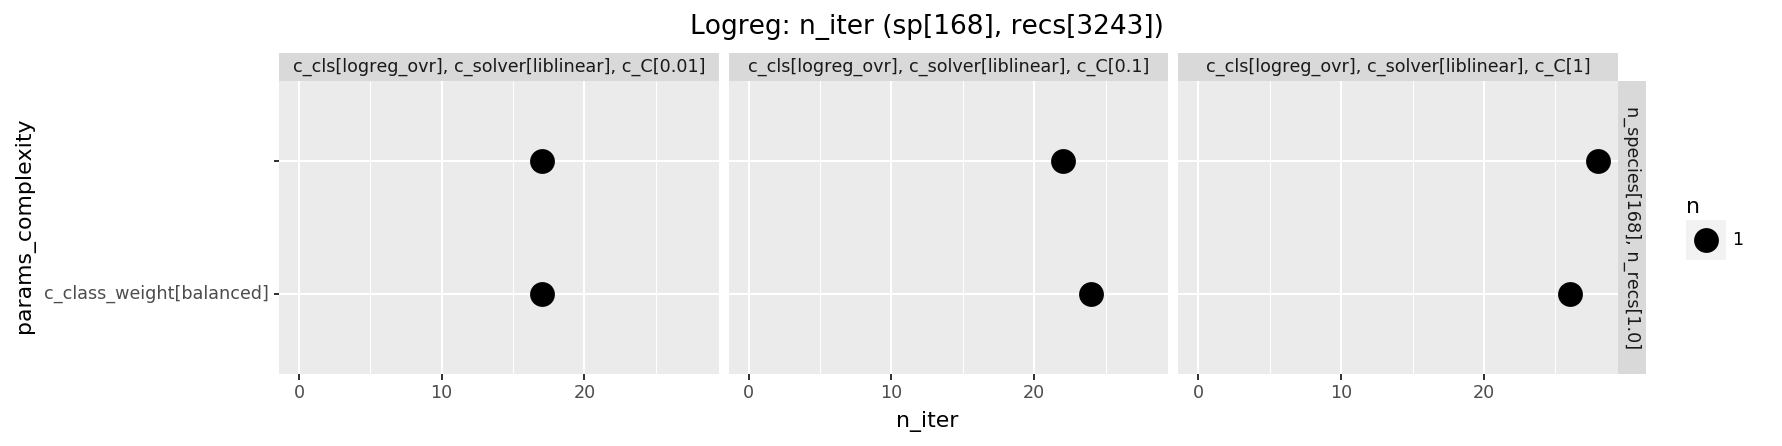

<ggplot: (315793854)>

In [ ]:
# TODO Tune logreg n_iter
(cv_models
    .merge(how='left', on='model_id', right=df_flatmap(cv_models, lambda row: (
        dict(model_id=row.model_id, n_iter=n_iter)
        for n_iter in coalesce(row.logreg_n_iter, [0])
    )))
    # Manually compute y.mean() per group
    # .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_count(aes(y='n_iter', size='..n..')) + scale_size_area()
    + expand_limits(y=0)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Logreg: n_iter ({recs_stats})')
)

In [ ]:
# TODO Very slow with ~200 models
cv_models_proc_stats = (cv_models
    # Enable these as needed (at the cost of mem usage)
    [[
        'model_id',
        'params',
        # 'params_dict',
        'params_data',
        'params_complexity',
        'params_model',
        'fold',
        # 'train_score',
        # 'test_score',
        # 'fit_time',
        # 'score_time',
        'mem_rss_delta',
        # 'mem_vms_delta',
        # 'train_evals',
        # 'test_evals',
        'proc_stats',
    ]]
    # TODO Faster way to do this? (.merge is >2x slower)
    .pipe(df_flatmap, lambda row: [
        row.append(pd.Series(dict(**stats)))
        for stats in row.proc_stats.stats
    ])
    # .pipe(lambda df: (df
    #     .merge(how='left',
    #         right=DF(
    #             OrderedDict(model_id=row.model_id, **stats)
    #             for row in df_rows(df)
    #             for stats in row.proc_stats.stats
    #         )
    #     )
    # ))
    # HACK Restore the cats that the df_flatmap just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
    )
    .assign(
        cpu_user=lambda df: df.cpu_user.diff() * 100,
        cpu_system=lambda df: df.cpu_system.diff() * 100,
    )
    .pipe(tap, f=lambda df: display(
        df_summary(df).T,
        df[:5],
    ))
)

[skip]

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


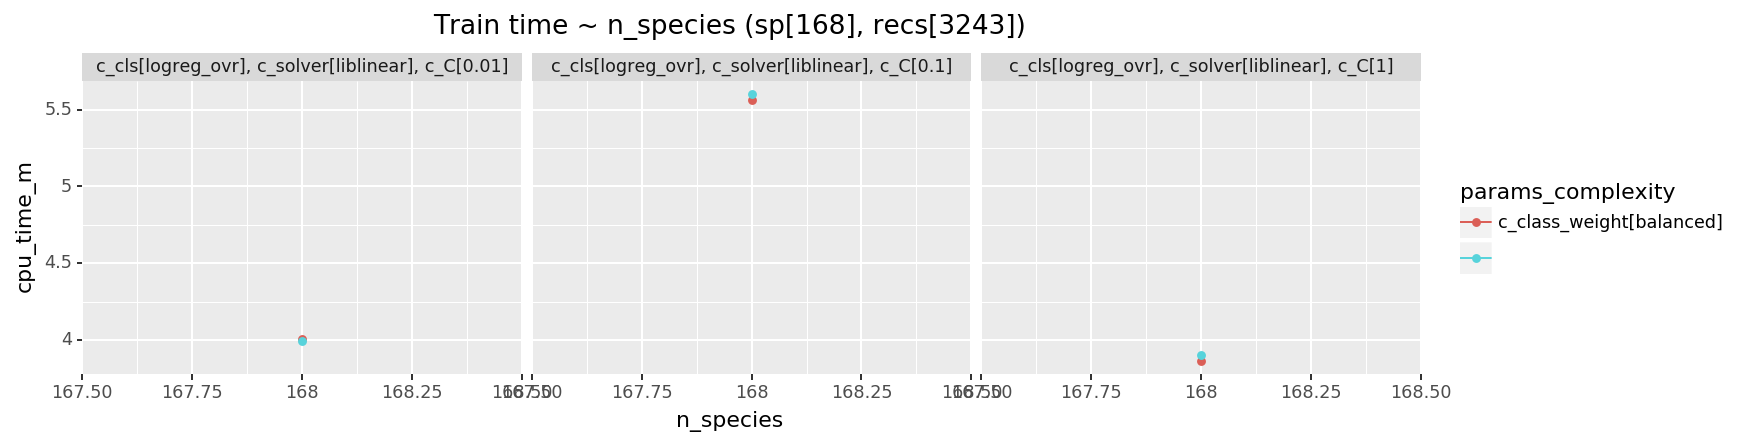

<ggplot: (-9223372036514902426)>

In [ ]:
# Train time ~ n_species
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='n_species', y='cpu_time_m', color='params_complexity')
    + facet_wrap('params_model', nrow=1)
    + geom_point()
    + geom_line()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_species ({recs_stats})')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:81: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


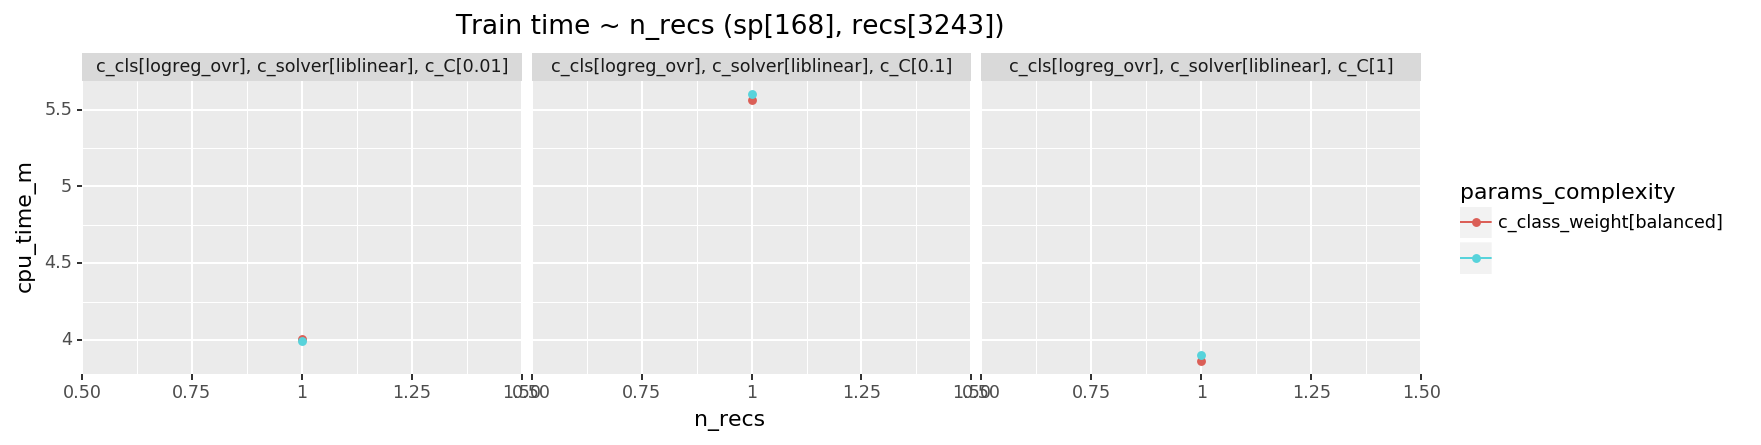

<ggplot: (324492303)>

In [ ]:
# Train time ~ n_recs
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='n_recs', y='cpu_time_m', color='params_complexity')
    + facet_wrap('params_model', nrow=1)
    + geom_point()
    + geom_line()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_recs ({recs_stats})')
)

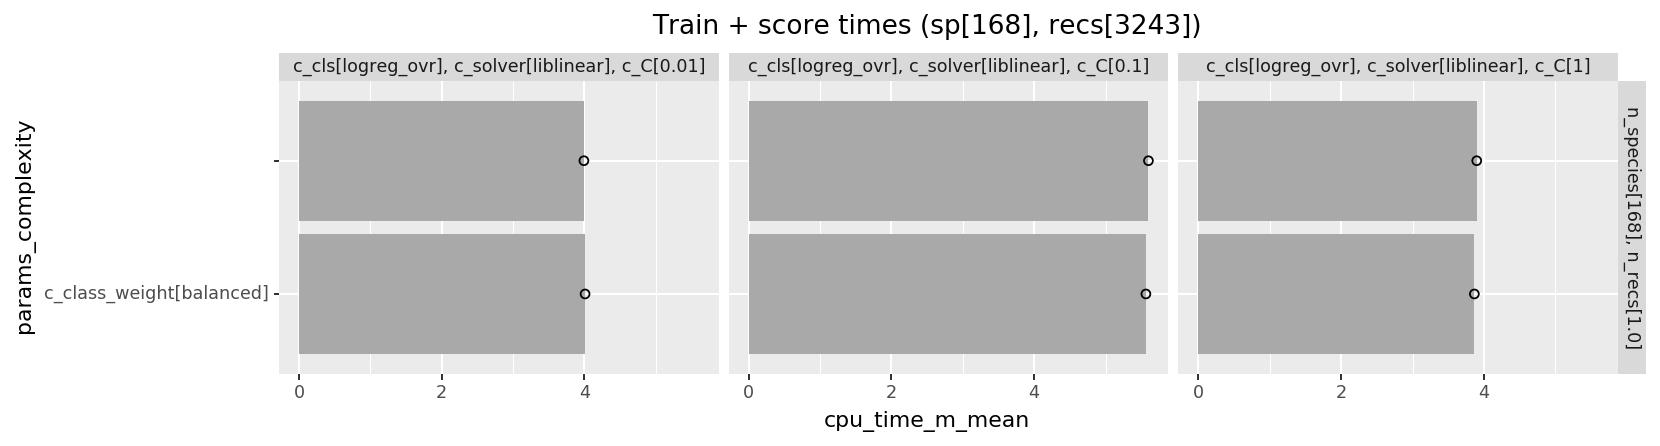

<ggplot: (315788359)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_col(aes(y='cpu_time_m_mean'), fill='darkgray', position=position_dodge())
    + geom_point(aes(y='cpu_time_m'), color='black', fill='none', size=2)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train + score times ({recs_stats})')
)

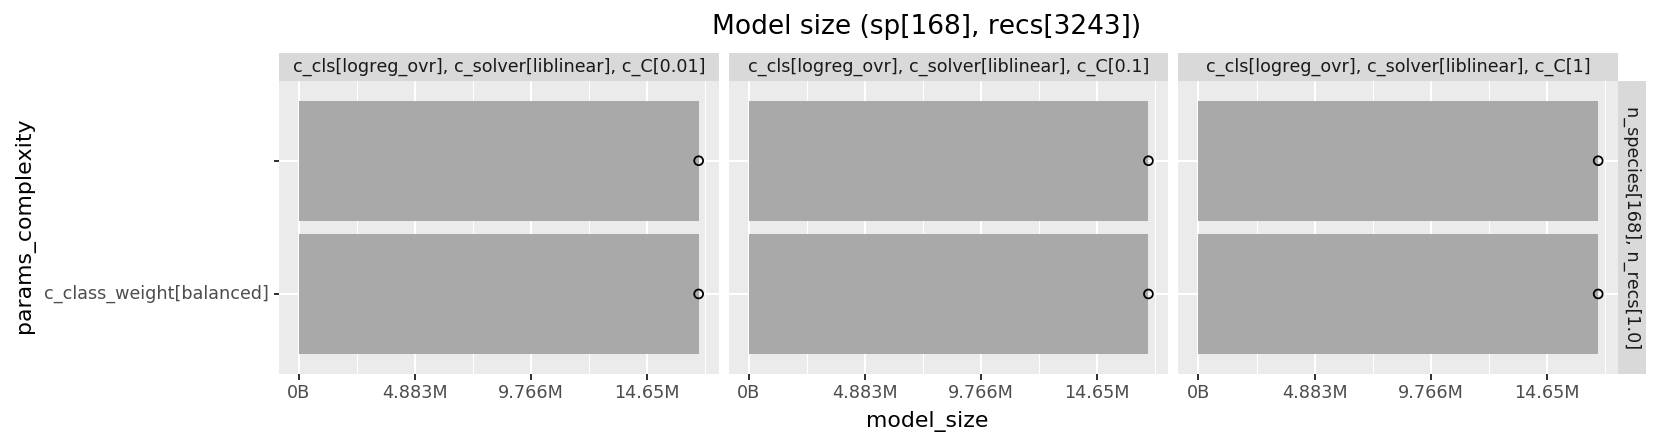

<ggplot: (317821227)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(model_size_mean=lambda df: df.model_size.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_col(aes(y='model_size_mean'), fill='darkgray', position=position_dodge()) # Summary per fold
    + geom_point(aes(y='model_size'), color='black', fill='none', size=2) # Distribution of folds
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + coord_flip()
    + ylab('model_size')
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Model size ({recs_stats})')
)

In [ ]:
# TODO Make not barf on non-tree models (blocks rest of notebook)
(cv_models
    # Manually compute boxplot stats, else it's _really_ slow (or you have to downsample, which misses outliers)
    #   - Based on stat_boxplot.compute_group
    .merge(how='left', on='params', right=cv_models.groupby('params').apply(lambda g: one(
        pd.Series(dict(
            params=g.name,
            ymin=boxplot['whislo'],
            lower=boxplot['q1'],
            middle=boxplot['med'],
            upper=boxplot['q3'],
            ymax=boxplot['whishi'],
            outliers=np.unique(boxplot['fliers']),  # np.unique else really slow, because lots of repeated (int) points
        ))
        for [boxplot] in [mpl.cbook.boxplot_stats(  # [boxplot] is 1 elem because X.ndim = 1
            X=np.concatenate([[] if x is None else x.depth for x in g.model_stats]),
            whis=1.5,
        )]
    )))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_boxplot(
        stat='identity',
        outlier_size=.5,
        mapping=aes(ymin='ymin', ymax='ymax', upper='upper', lower='lower', middle='middle', outliers='outliers',
            width=.8,  # Close enough to geom_boxplot defaults [TODO Maybe should compute based on num categorical x's?]
        ),
    )
    + ylab('tree_depth')
    + coord_flip()
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Tree depth ({recs_stats})')
)

[skip]

In [ ]:
# XXX Revive if insightful
(cv_models
    .pipe(df_reverse_cat, 'params_no_ns')
    .assign(n_species=lambda df: df.params_dict.str['n_species'])
    .pipe(ggplot, aes(x='n_species', y='forest_depth_mean', color='params_no_ns'))
    # + facet_wrap('params_no_ns', ncol=2)
    + geom_point()
    + geom_pointrange(aes(ymin='forest_depth_mean - 2*forest_depth_std', ymax='forest_depth_mean + 2*forest_depth_std'))
    + geom_smooth(method='lm', se=False)  # Disable se because it only knows forest_depth_mean, no measure of spread
    + expand_limits(x=0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    # + theme_figsize(aspect_ratio=1/3)
    + theme_figsize(aspect_ratio=1/3)
    + ggtitle(f'RF depth vs. n_species ({recs_stats})')
)

[skip]

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(mem_rss_delta_mean=lambda df: df.mem_rss_delta.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='mem_rss_delta_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='mem_rss_delta'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Mem rss spread ($max-min$) ({recs_stats})')
)

[skip]

In [ ]:
# TODO Might need to stack/geom_area for overlapping runs
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='cpu_system'), linetype='dashed', size=.5)
    + geom_line(aes(y='cpu_system + cpu_user'), linetype='solid', size=.5)
    + expand_limits(y=0)
    + ylab('cpu')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=lambda labels: ['%.3g%%' % x for x in labels])
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('cpu over time (system + user)')
)

[skip]

In [ ]:
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='mem_rss'), linetype='solid', size=.5)
    + geom_line(aes(y='mem_vms'), linetype='dashed', size=.5)
    + expand_limits(y=0)
    + ylab('mem')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes(pow=3))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('Mem over time (rss, vms)')
)

[skip]

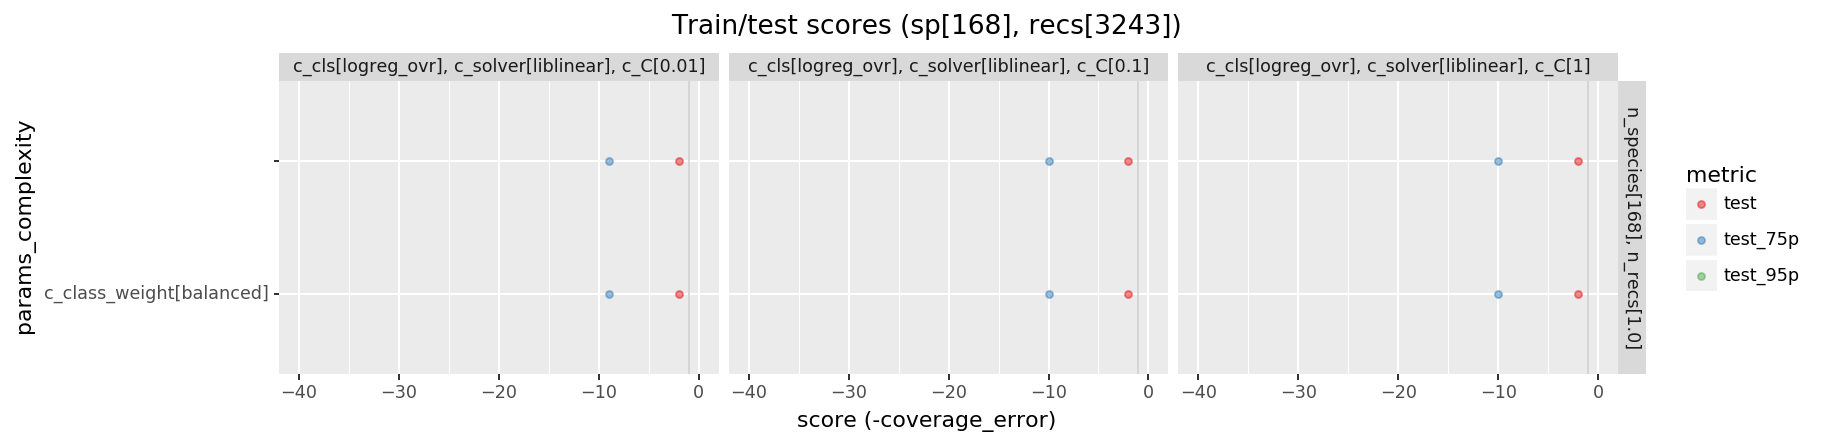

<ggplot: (-9223372036515955326)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(lambda df: pd.melt(df,
        id_vars=[
            'params', 'params_data', 'params_model', 'params_complexity',
            'params_data_and_model', 'params_model_and_complexity',
            'n_species', 'n_recs',
            'fold',
        ],
        value_vars=[
            # 'train_score',  # Boring
            'test_score',
            'test_75p_score',
            'test_95p_score',
        ],
        var_name='metric',
        value_name='score'),
    )
    .assign(
        metric=lambda df: df.metric.str.replace('_score', ''),
        group=lambda df: df.params_complexity.str.cat(df.metric, '/'),
    )
    .pipe(df_ordered_cat,
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(ggplot)
    + aes(x='params_complexity')
    + aes(y='score')
    + aes(color='metric')
    # + facet_grid('params_data ~ params_model')
    + facet
    + geom_hline(yintercept=-1, color='lightgrey')  # -1 is the max score (1 is the min coverage_error)
    + geom_point(alpha=.5)
    # + geom_jitter(fill='none', size=3, height=1e-9, width=.05)
    # + geom_count(aes(size='..n..')) + scale_size_area()
    # + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + coord_flip(
        ylim=(-40, 0),
    )
    # + scale_color_cmap_d('tab10')
    + scale_color_cmap_d('Set1')
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ylab('score (-coverage_error)')
    + ggtitle(f'Train/test scores ({recs_stats})')
)

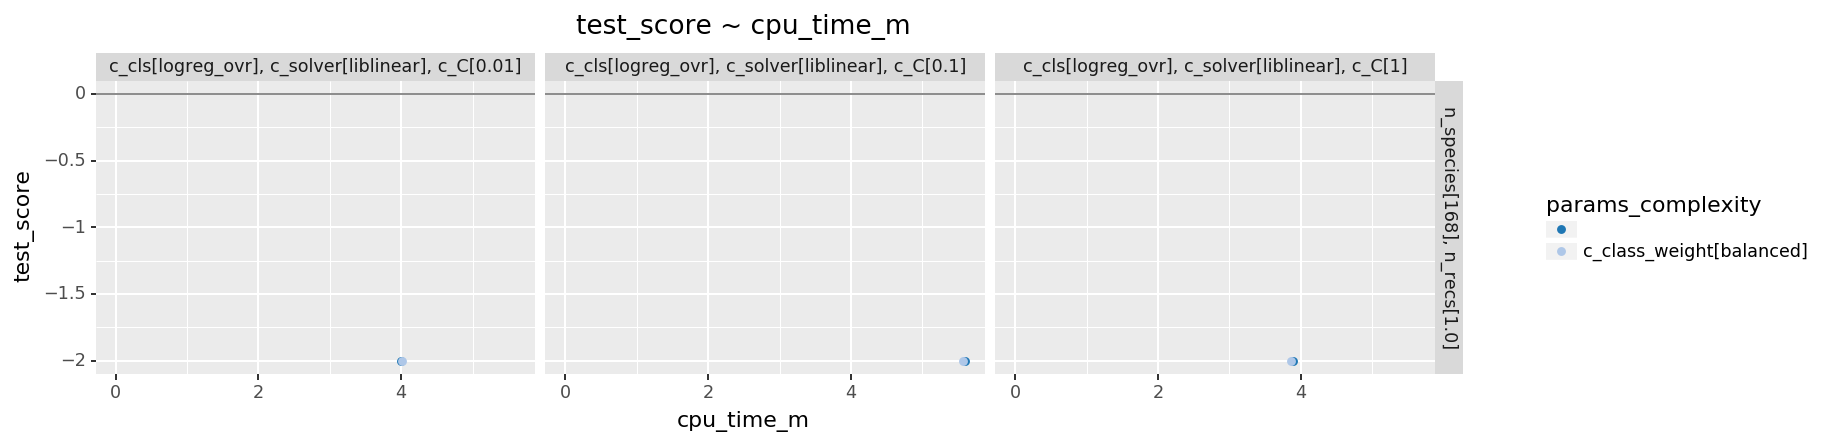

<ggplot: (-9223372036537079387)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='cpu_time_m', y='test_score')
    + aes(color='params_complexity')
    + facet
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + expand_limits(x=0)
    # + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ cpu_time_m')
)

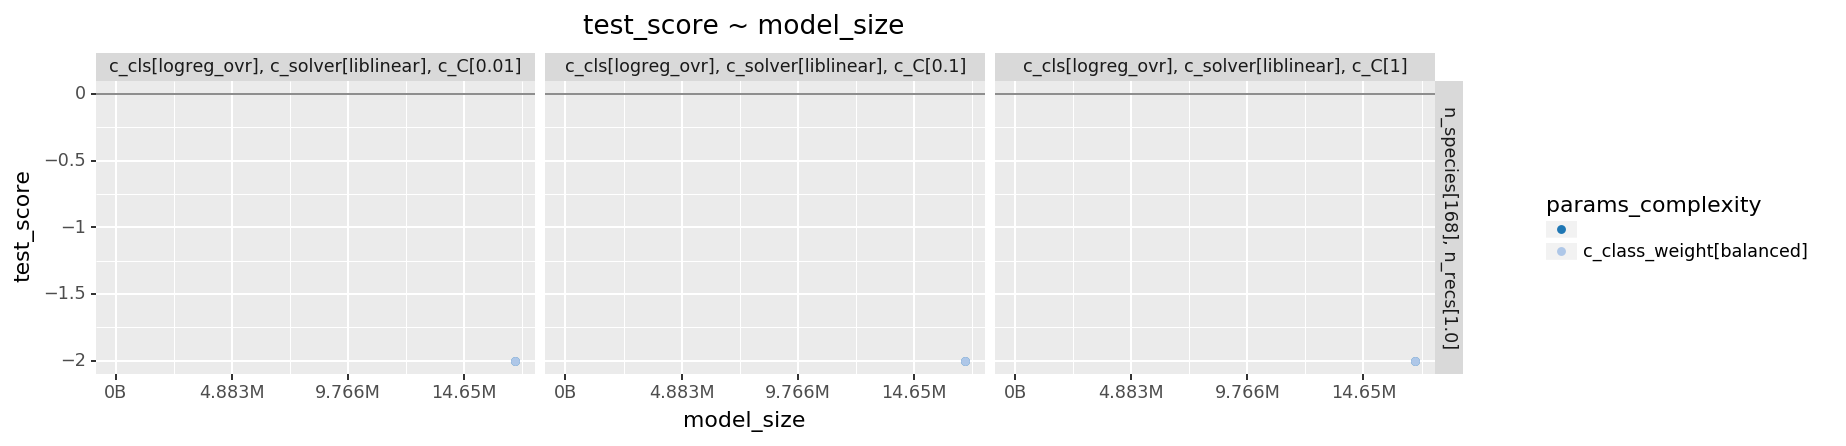

<ggplot: (-9223372036527691667)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='model_size', y='test_score')
    + aes(color='params_complexity')
    + facet
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    # + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ model_size')
)

In [ ]:
SLOW_PLOTS_NEXT

NameError: name 'SLOW_PLOTS_NEXT' is not defined

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(cv_models.params.cat.categories))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/6]
  fold[*/1]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            params_data=row.params_data,
            params_model=row.params_model,
            params_complexity=row.params_complexity,
            params_data_and_model=row.params_data_and_model,
            params_model_and_complexity=row.params_model_and_complexity,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
    .astype(dict(
        model_id=cv_models.model_id.dtype,
        params=cv_models.params.dtype,
        params_data=cv_models.params_data.dtype,
        params_model=cv_models.params_model.dtype,
        params_complexity=cv_models.params_complexity.dtype,
        params_data_and_model=cv_models.params_data_and_model.dtype,
        params_model_and_complexity=cv_models.params_model_and_complexity.dtype,
    ))
    .pipe(tap, lambda df: display(
        df_summary(df).T,
        df[:10],
    ))
)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 2/6 [00:00<00:00, 15.82it/s]

 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00, 16.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.08it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,category,565279,3894,3894,6,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01],c_class_weight[balanced], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1],c_class_weight[balanced], fold[0]"
params,category,530233,3894,3894,6,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01],c_class_weight[balanced]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[1],c_class_weight[balanced]"
params_data,category,732072,3894,3894,1,NaN,NaN,"n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]"
params_model,category,1134452,3894,3894,3,NaN,NaN,"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]","c_cls[logreg_ovr], c_solver[liblinear], c_C[1]","c_cls[logreg_ovr], c_solver[liblinear], c_C[1]"
params_complexity,category,440022,3894,3894,2,NaN,NaN,,,,c_class_weight[balanced],c_class_weight[balanced]
params_data_and_model,category,485452,3894,3894,3,NaN,NaN,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[1]","n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[1]"
params_model_and_complexity,category,427042,3894,3894,6,NaN,NaN,"c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\nc_class_weight[balanced]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]\n","c_cls[logreg_ovr], c_solver[liblinear], c_C[1]\n","c_cls[logreg_ovr], c_solver[liblinear], c_C[1]\nc_class_weight[balanced]"
fold,int64,93456,3894,3894,1,0.000,0.000,0,0,0,0,0
i,int64,109032,3894,3894,649,1622.072,938.236,4,805,1624,2429,3238


,model_id,params,params_data,params_model,params_complexity,params_data_and_model,params_model_and_complexity,fold,i,y_true,coverage_error
0,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,1549,GRPE,4.0
1,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,1284,WTSW,94.0
2,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,1512,YHPA,1.0
3,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,1341,LUHU,1.0
4,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,2945,PABU,7.0
5,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,1390,GKIN,80.0
6,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,304,HOGR,126.0
7,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,1646,PSFL,3.0
8,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]",,"n_species[168], n_recs[1.0]\nc_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]","c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]\n",0,3116,PIGR,8.0
9,"n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[logreg_ovr], c_solver[lib

In [ ]:
[print(x) for x in coverage_errors_all_all.params_data.unique()];
params_data = (
    'n_species[168], n_recs[1.0]'
    # 'n_species[336], n_recs[1.0]'
)
n_species = parse.search('n_species[{n_species:d}], n_recs[{n_recs:f}]', params_data)['n_species']

n_species[168], n_recs[1.0]


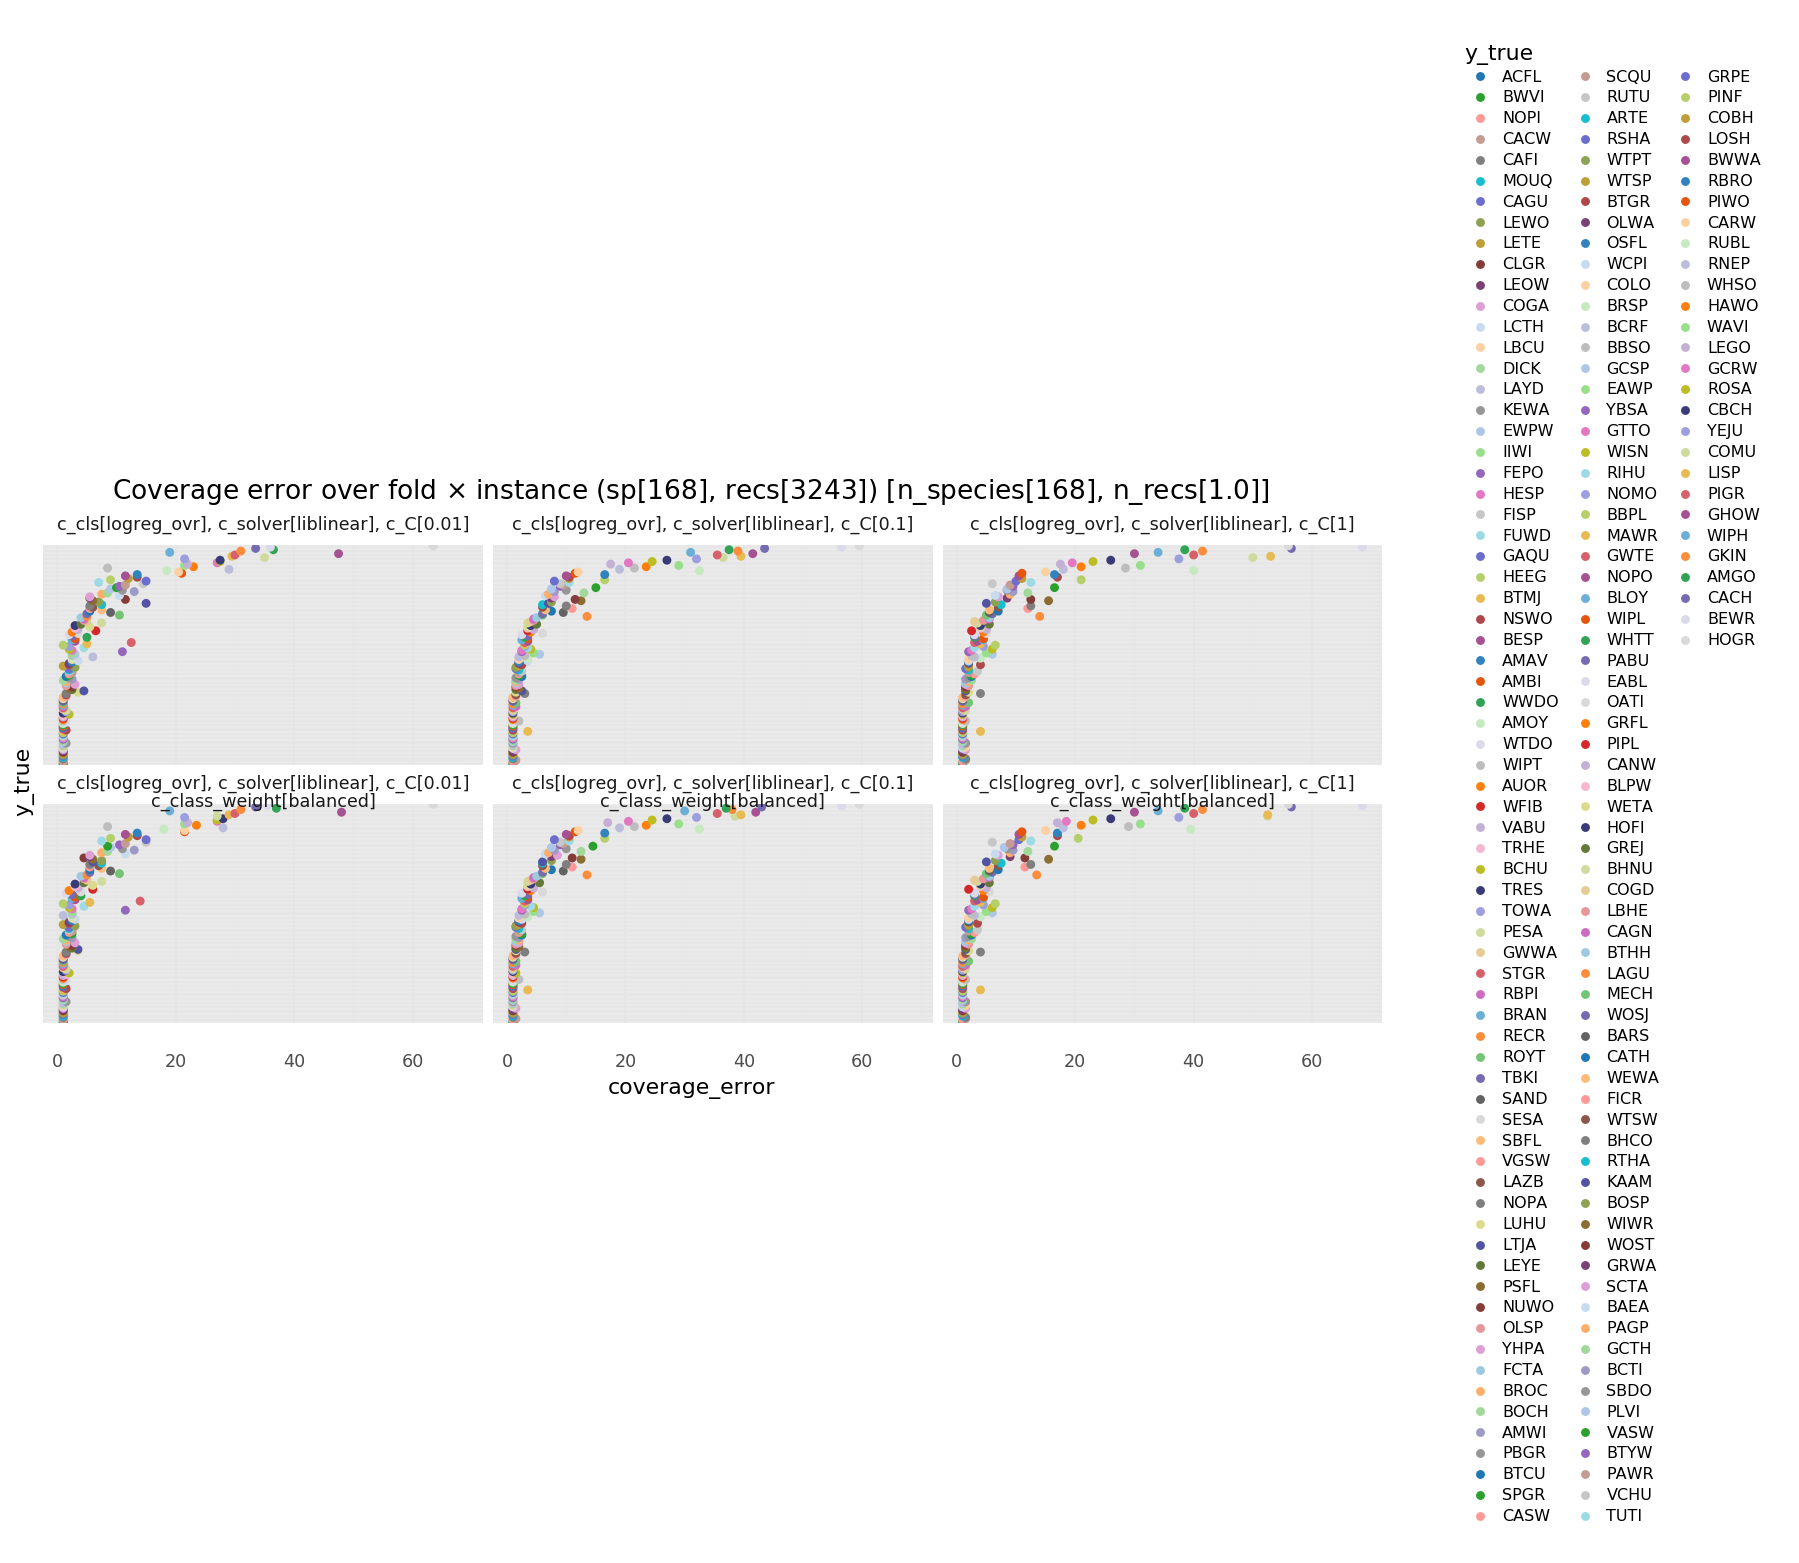

<ggplot: (317696376)>

In [ ]:
# Facet by params_no_ns, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    # .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
    )
    .pipe(ggplot)
    + aes(x='y_true', y='coverage_error')
    + aes(color='y_true')
    # + facet_grid('params_complexity ~ params_model')
    + facet_wrap('params_model_and_complexity', dir='v',
        nrow=coverage_errors_all_all.params_model.nunique(),  # Bug: nrow instead of ncol [https://github.com/has2k1/plotnine/issues/163]
    )
    # + geom_line(aes(group='params'), stat='summary', fun_y=np.median)  # TODO Bad interpolation with n_species
    + geom_point(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + theme_minimal()  # Before other theme()
    + guides(color=guide_legend(nrow=70))
    + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8, legend_text=element_text(size=8))
    + theme(axis_text_y=element_blank())
    + theme_figsize(width=12*1, aspect_ratio=1/2)
    + ggtitle(rf'Coverage error over fold $\times$ instance ({recs_stats}) [{params_data}]')
)

c_cls[logreg_ovr], c_solver[liblinear], c_C[0.01]
c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]
c_cls[logreg_ovr], c_solver[liblinear], c_C[1]


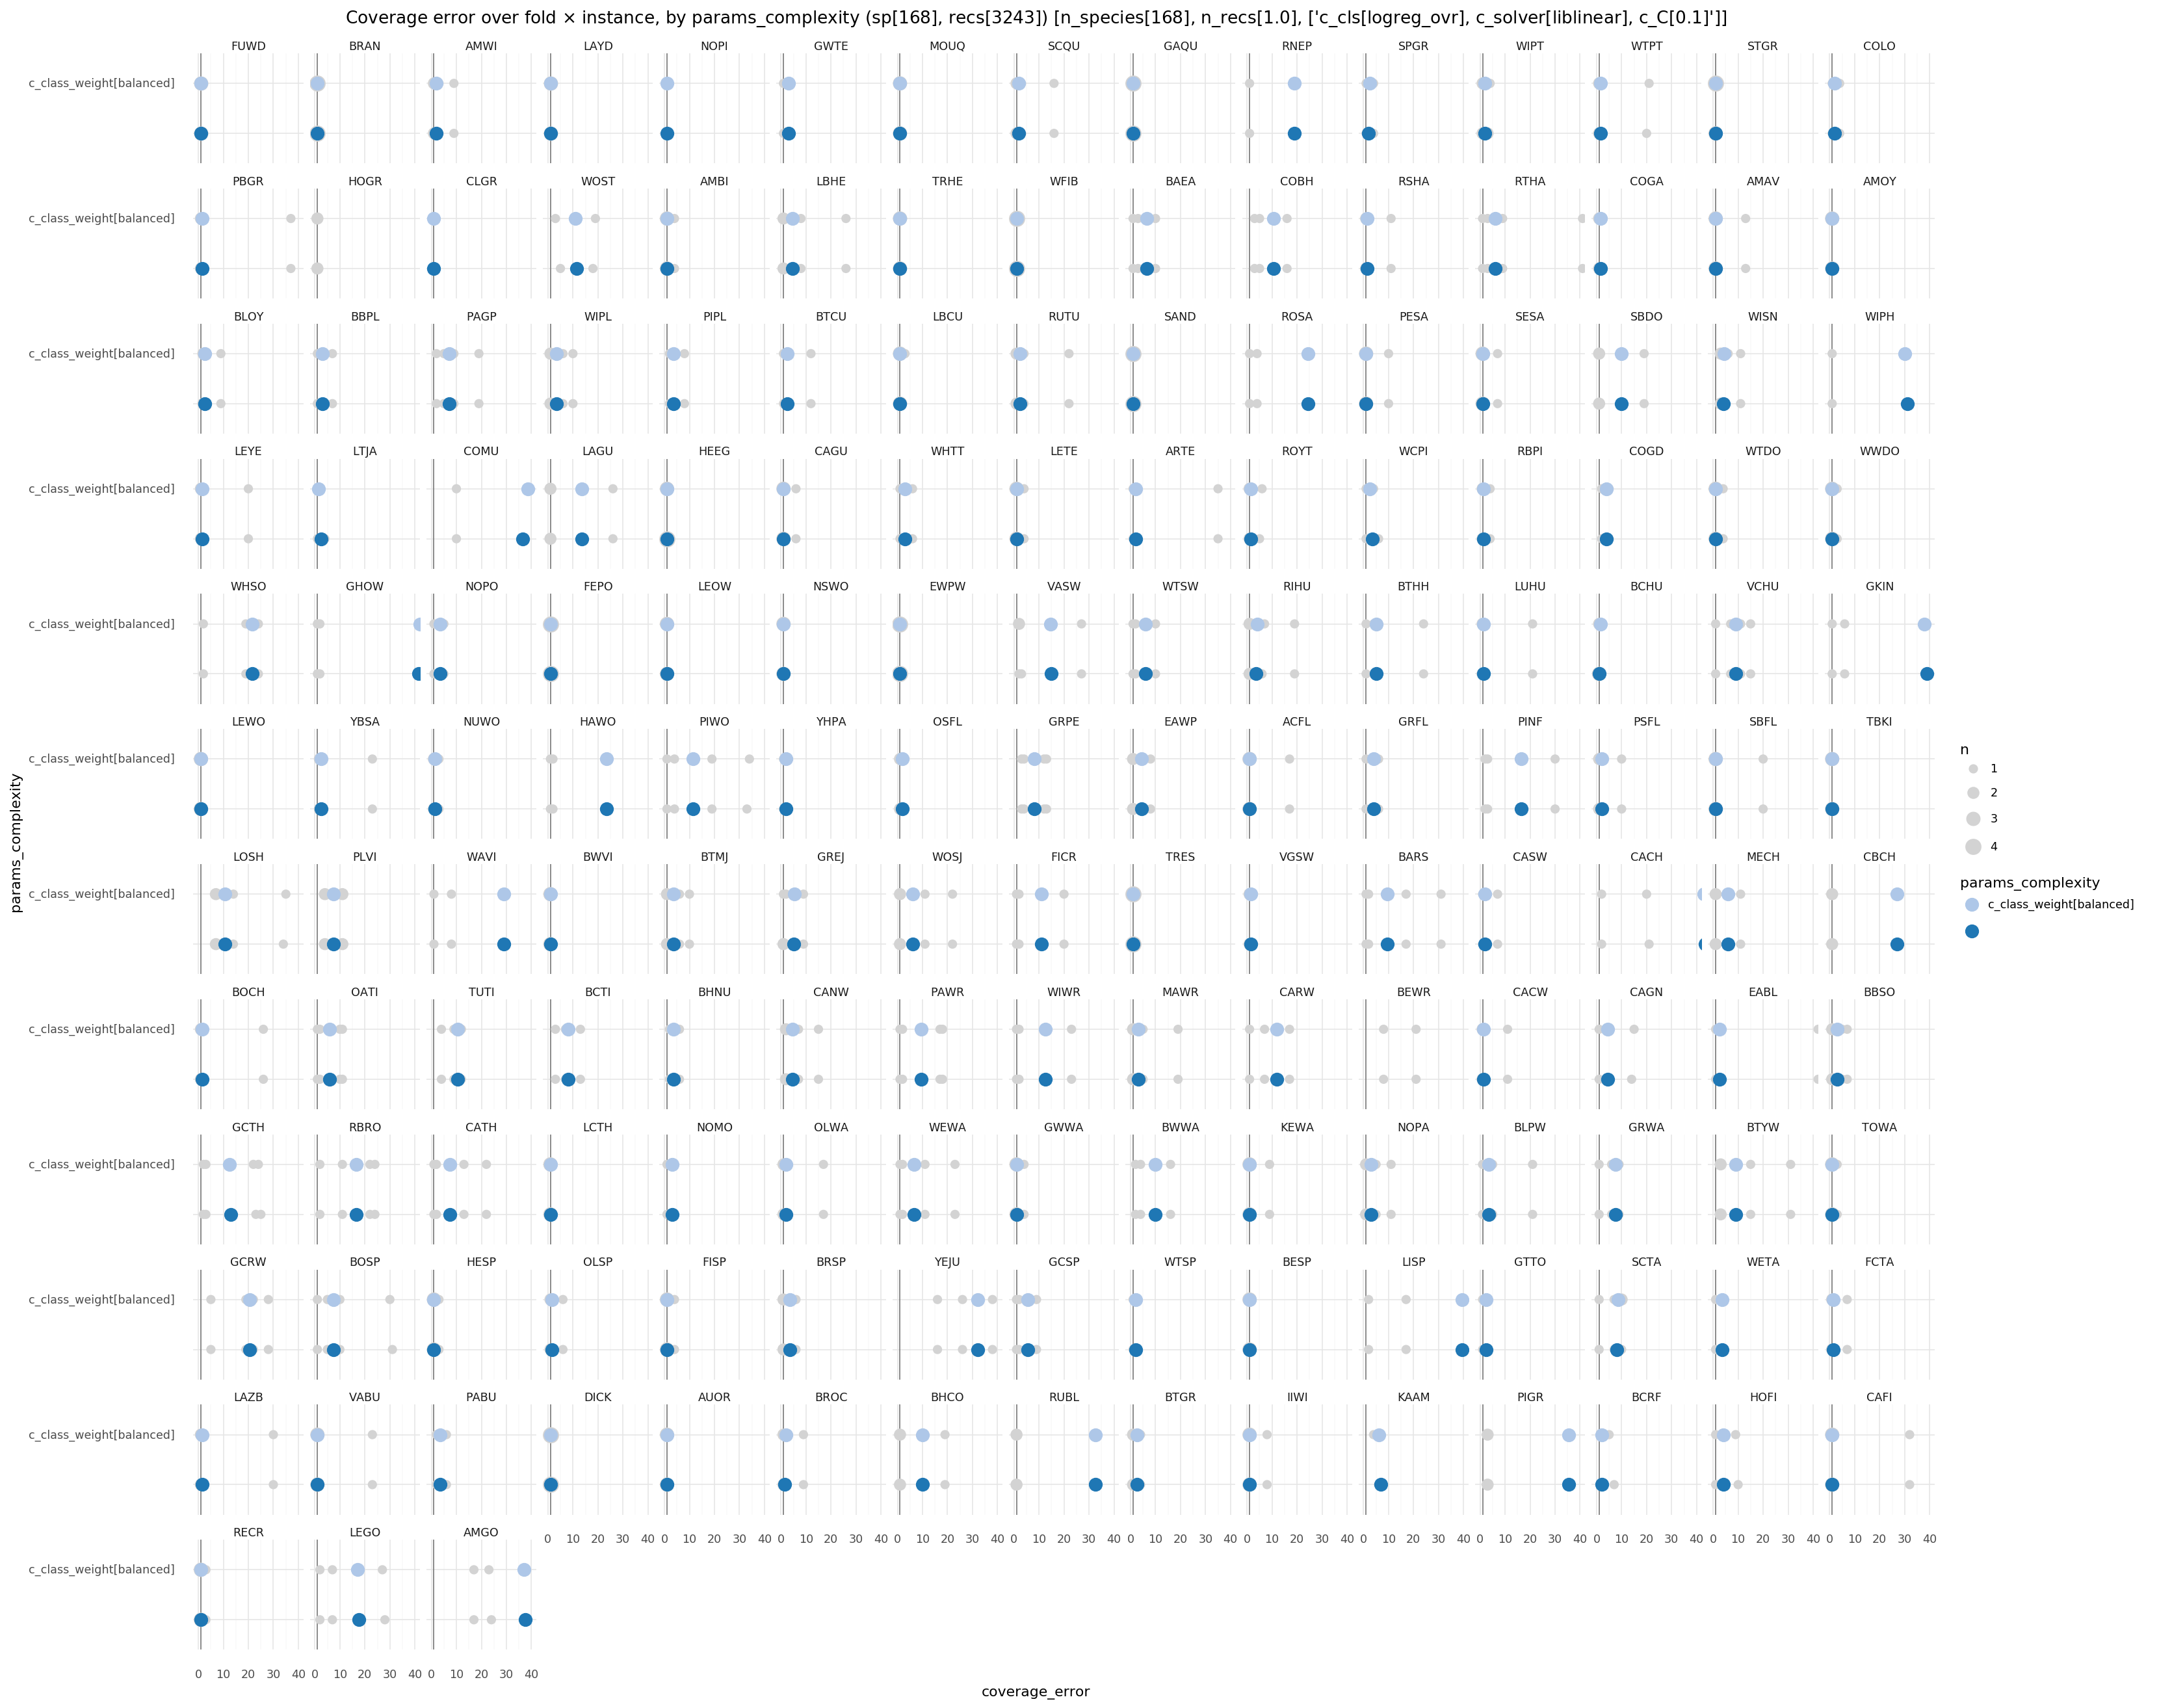

<ggplot: (317741355)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
[print(x) for x in coverage_errors_all_all.params_model.unique()];
params_model = [
    # 'c_cls[rf], c_n_estimators[100]',
    # 'c_cls[logreg_multi], c_solver[newton-cg]',
    # 'c_cls[logreg_ovr], c_solver[liblinear]',
    # 'c_cls[xgb_rf], c_n_estimators[100]',
    'c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]',
]
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_model.isin(params_model)]
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    # .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity', y='coverage_error')
    + aes(color='params_complexity')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    # + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab10'))  # Strong
    + scale_color_cmap_d(mpl_cmap_repeat(1, 'tab20', 'tab20b', 'tab20c'))  # FIXME repeat(10) makes lots of blue/gray
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=12*2, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_complexity ({recs_stats}) [{params_data}, {params_model}]')
)

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
[print(x) for x in coverage_errors_all_all.params_complexity.unique()];
params_complexity = [
    # 'c_max_depth[46]',
    'c_max_depth[1]',
    'c_C[0.01]',
]
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_complexity.isin(params_complexity)]
    # [lambda df: df.params.astype(str).str.contains(r'c_n_estimators\[100\]')]  # XXX Subset models
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    # .pipe(df_reverse_cat, 'params_model')
    .pipe(ggplot)
    + aes(x='params_model', y='coverage_error')
    + aes(color='params_model')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    + scale_color_cmap_d(mpl_cmap_repeat(1, 'tab20', 'tab20b', 'tab20c'))  # FIXME repeat(10) makes lots of blue/gray
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=12*2, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_model ({recs_stats}) [{params_data}, {params_complexity}]')
)

In [ ]:
ONE_MODEL_PLOTS_NEXT

# Model diagnostics: one model, all folds

In [ ]:
params_i = 1
params = cv_models.params.cat.categories[params_i]
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), params))
print('  fold[*/%s]' % cv.cv.n_splits)

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:5],
)

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=10, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance ({params}) ({recs_stats})')
)

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
            title=f'({recs_stats})',
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = cv_models.params.cat.categories[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id}) ({recs_stats})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
        title=f'({recs_stats})',
    )

[skip]